In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import numpy as np
from pathlib import Path

## Part 1 - Sign Detector Analysis + Comparison

Successfully loaded 39 epochs from file


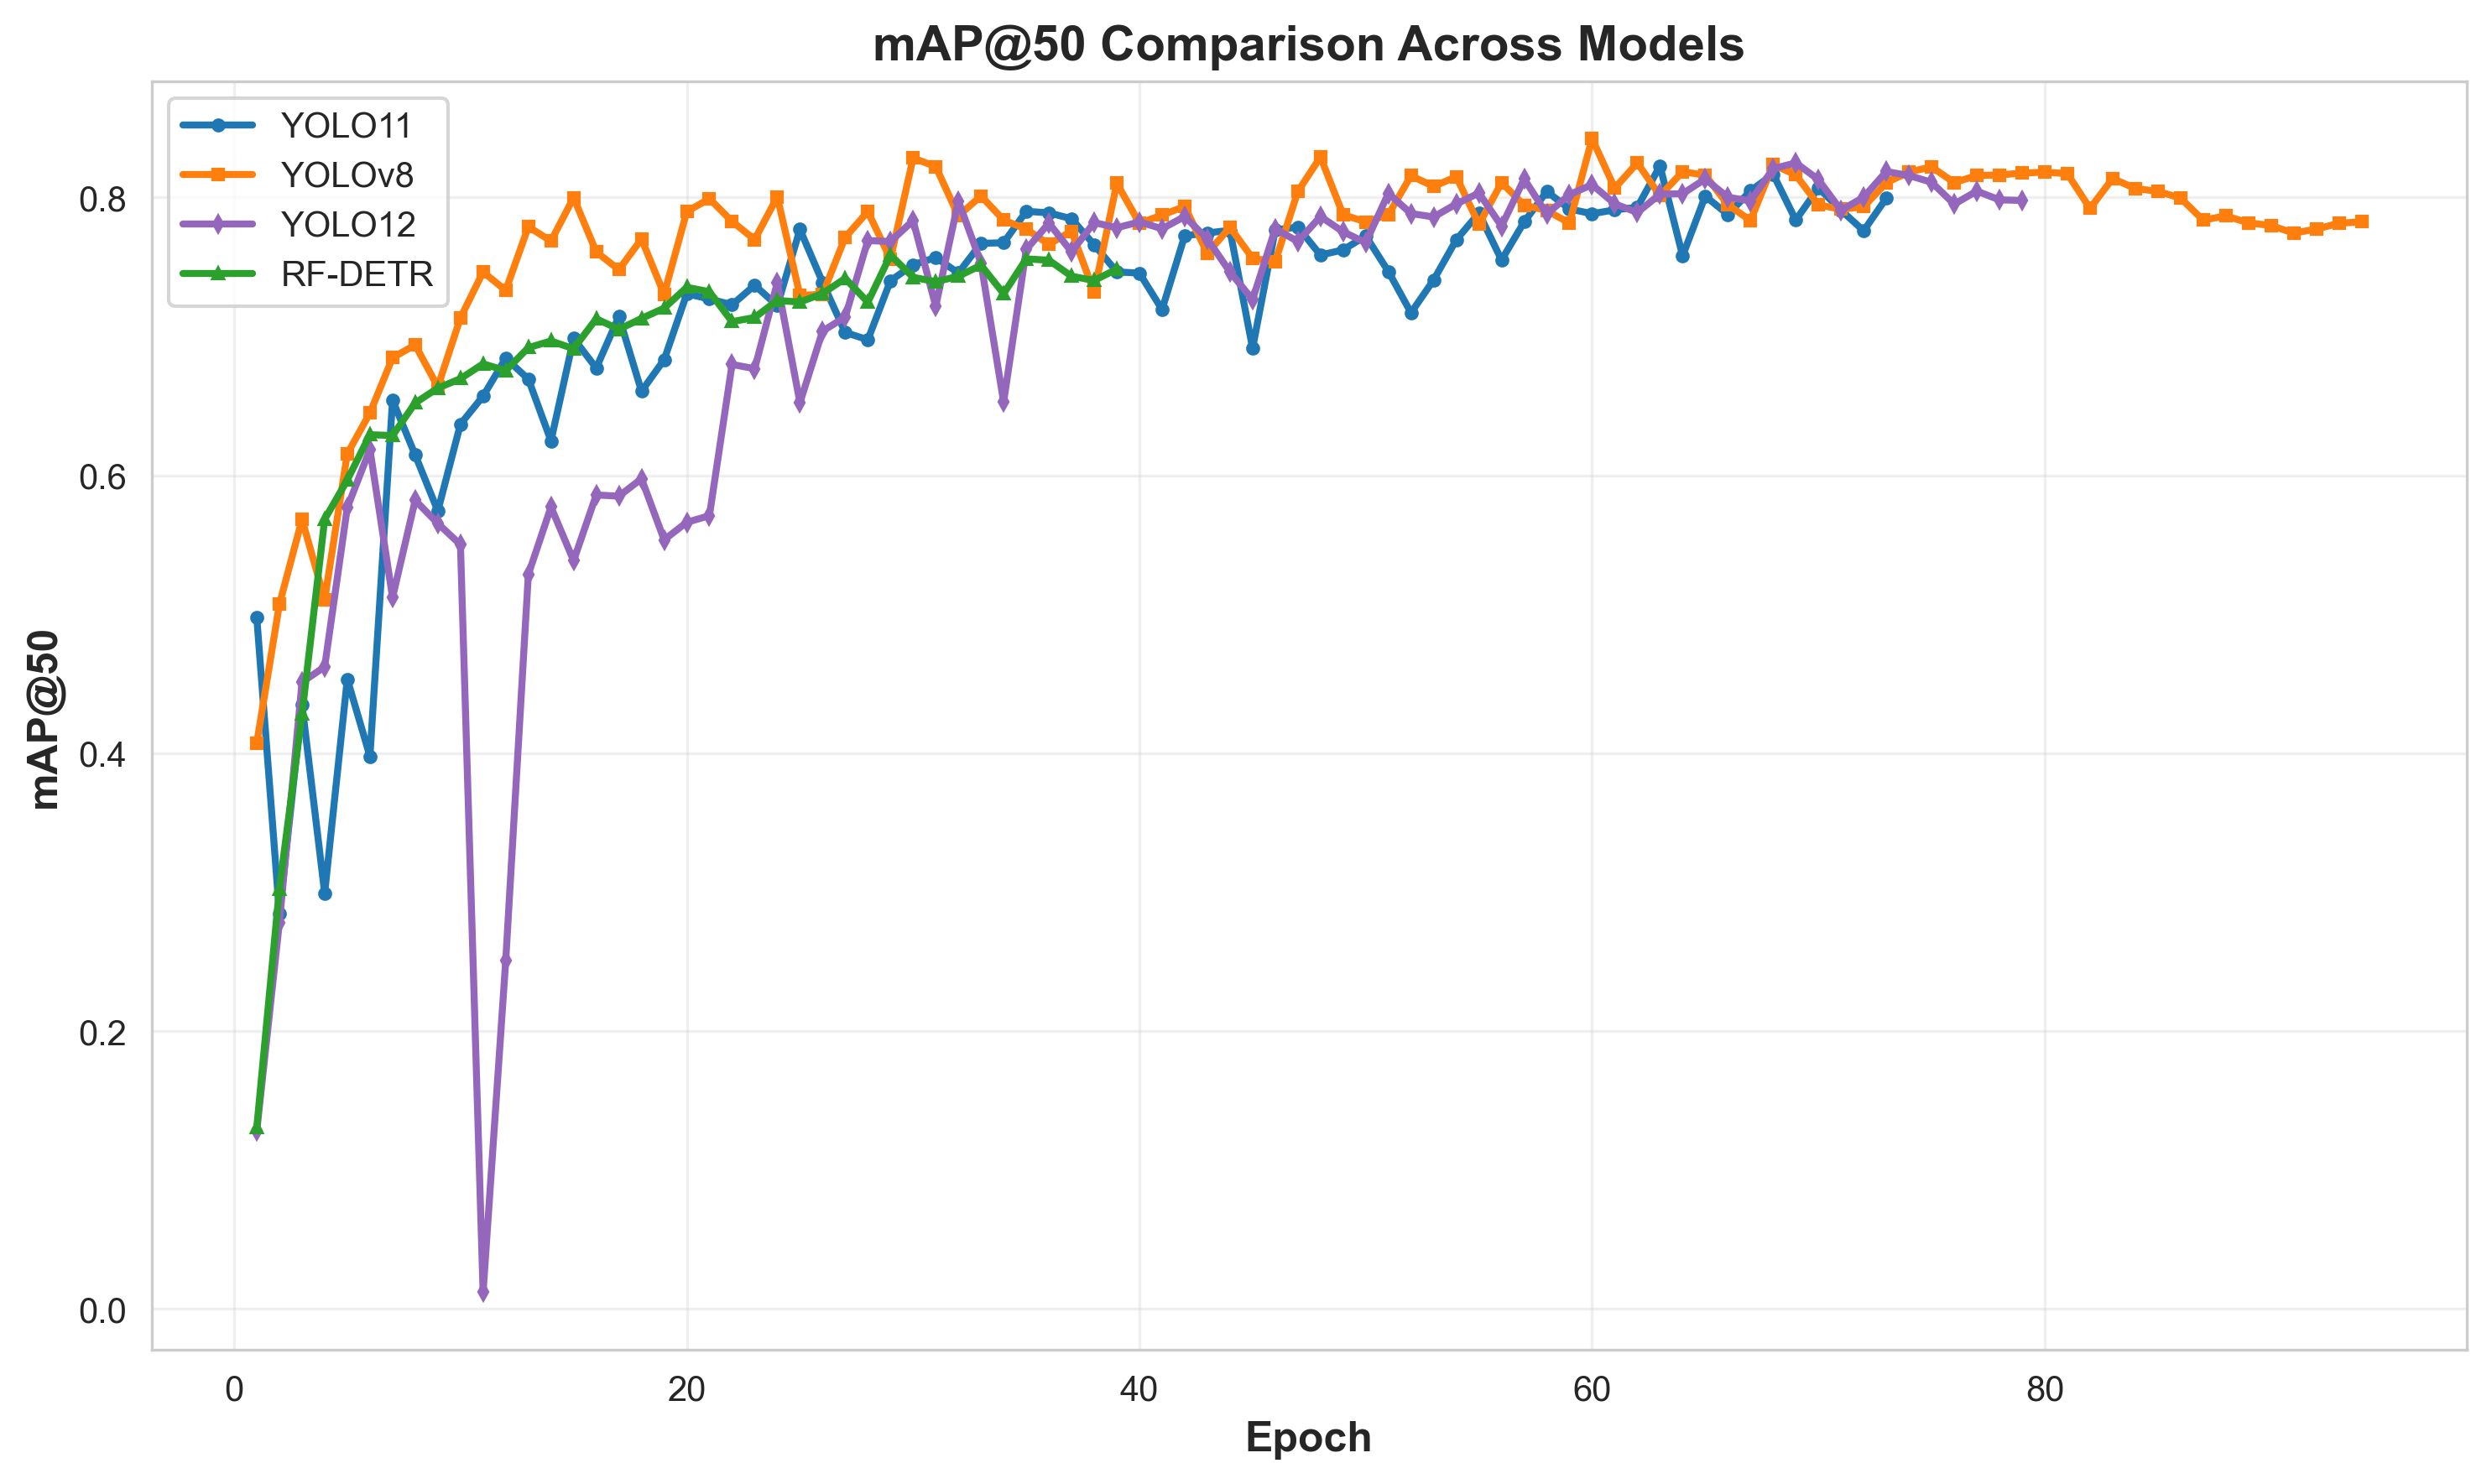

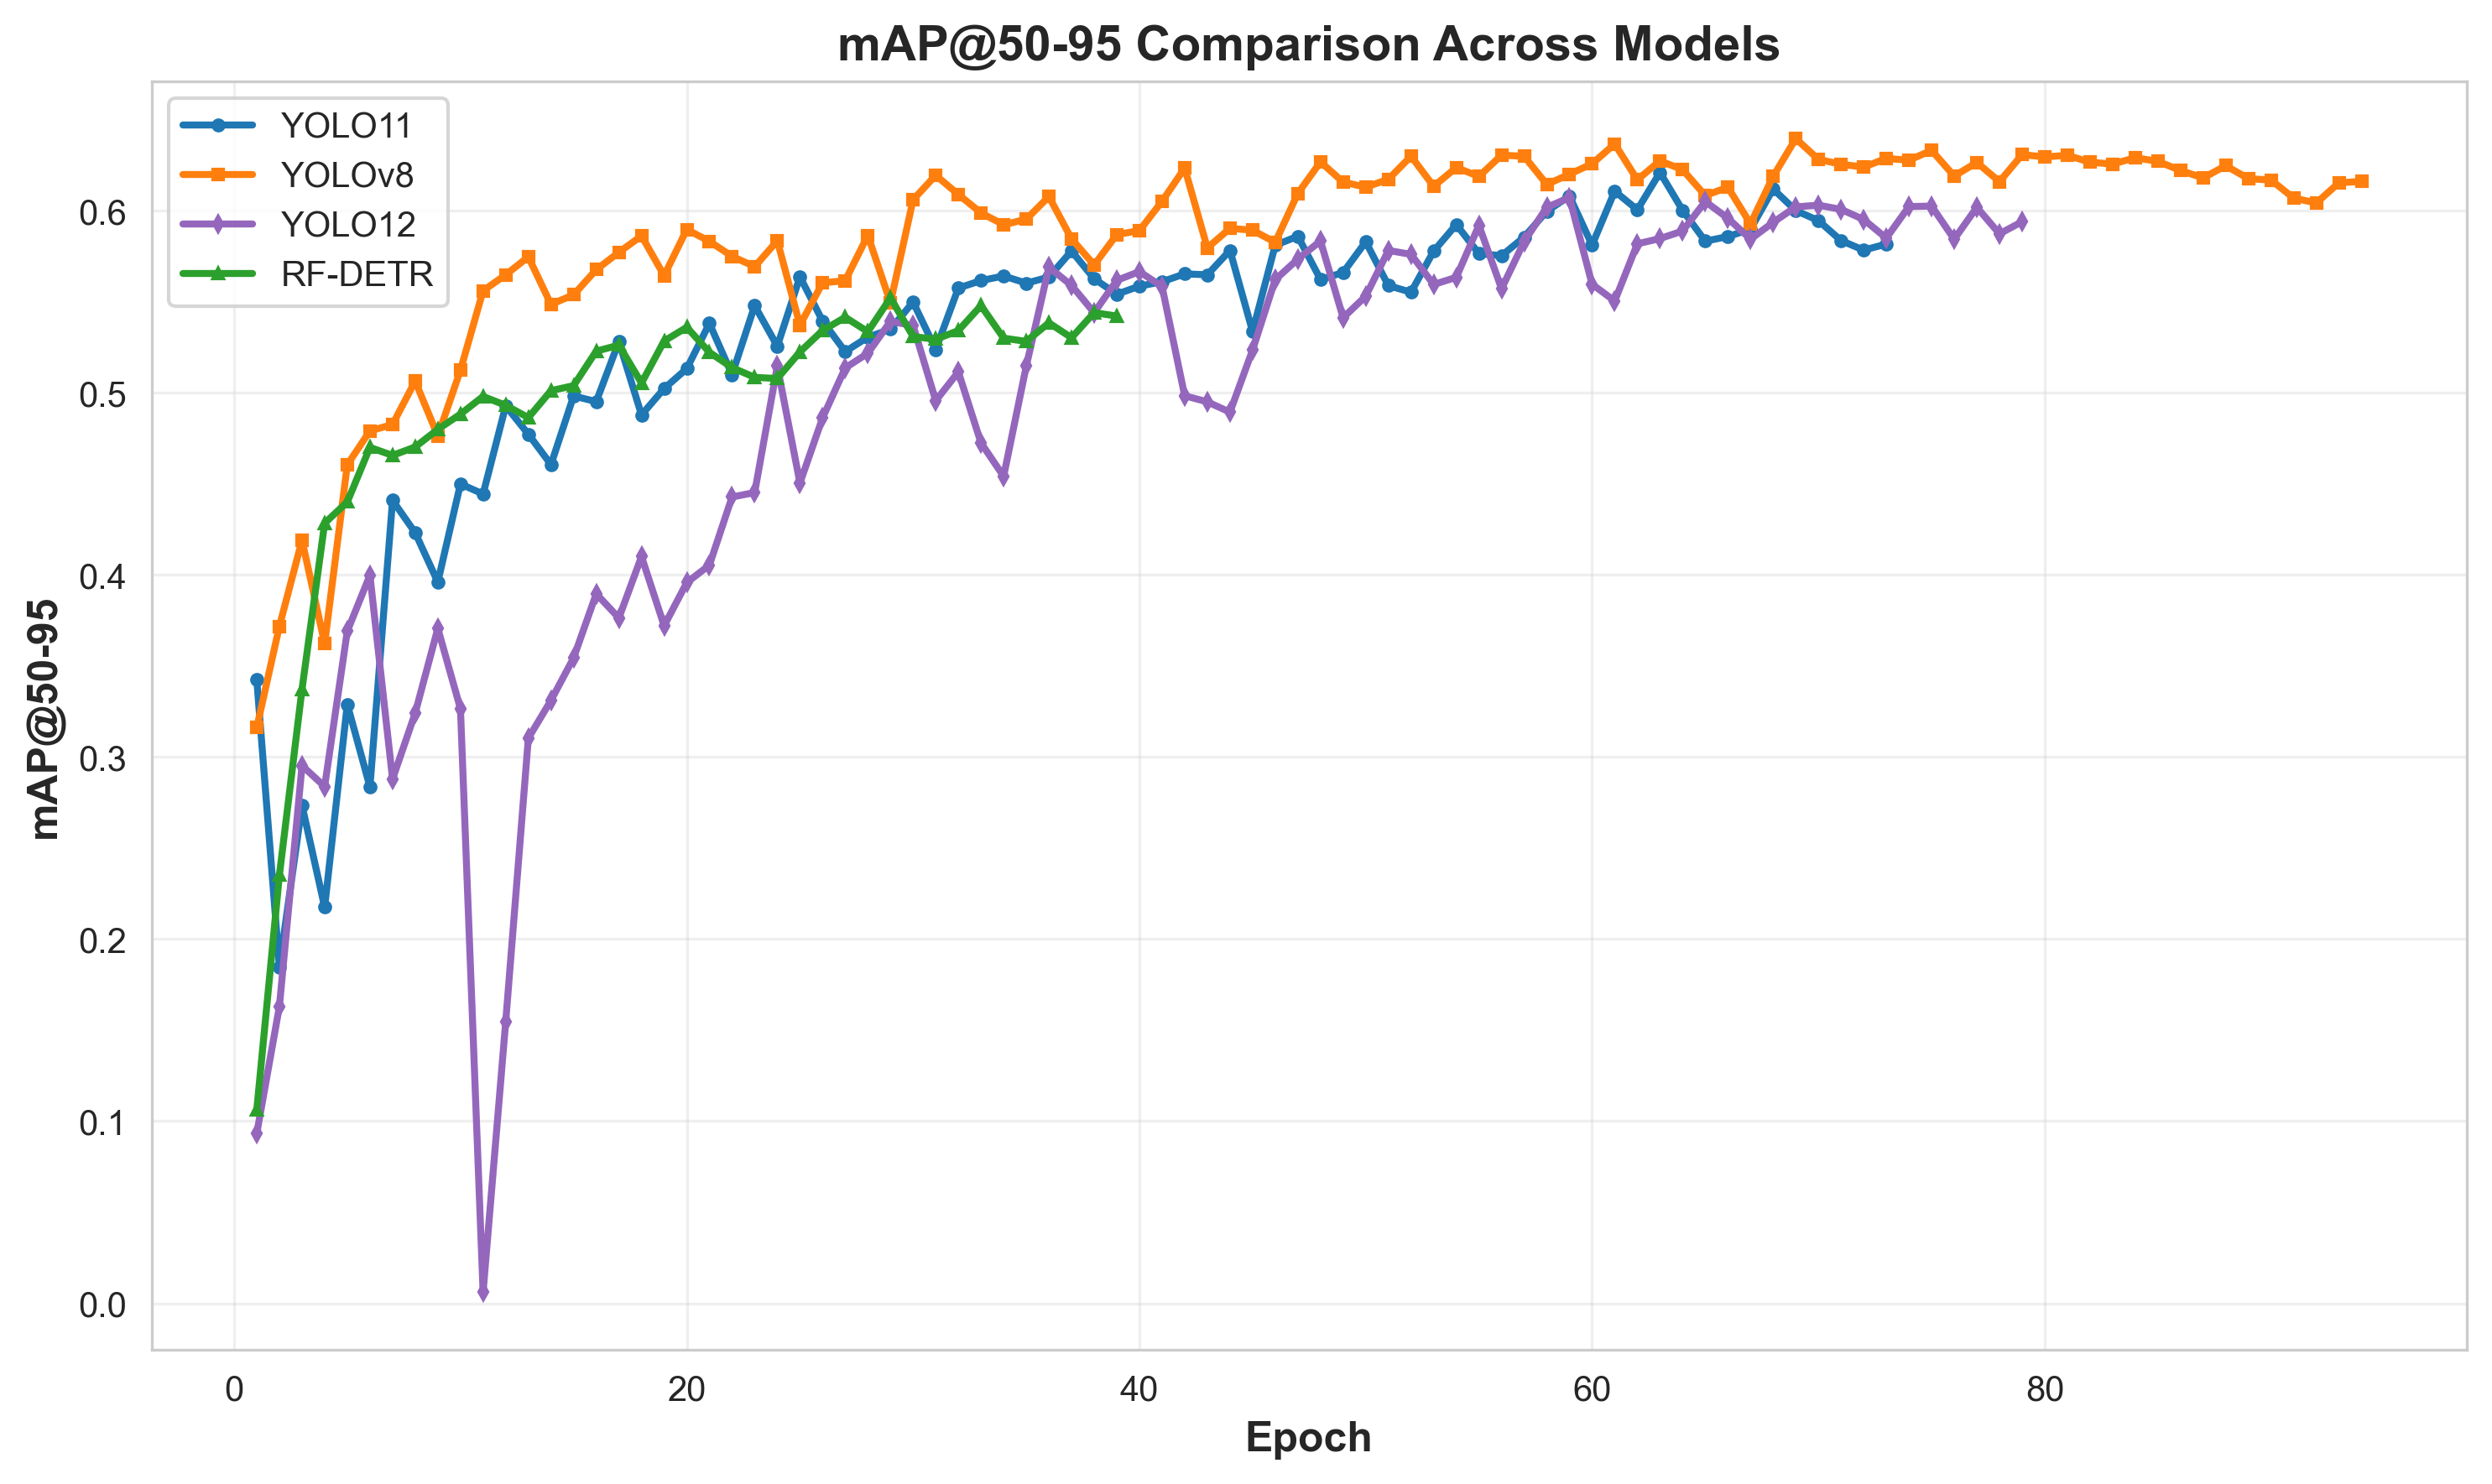

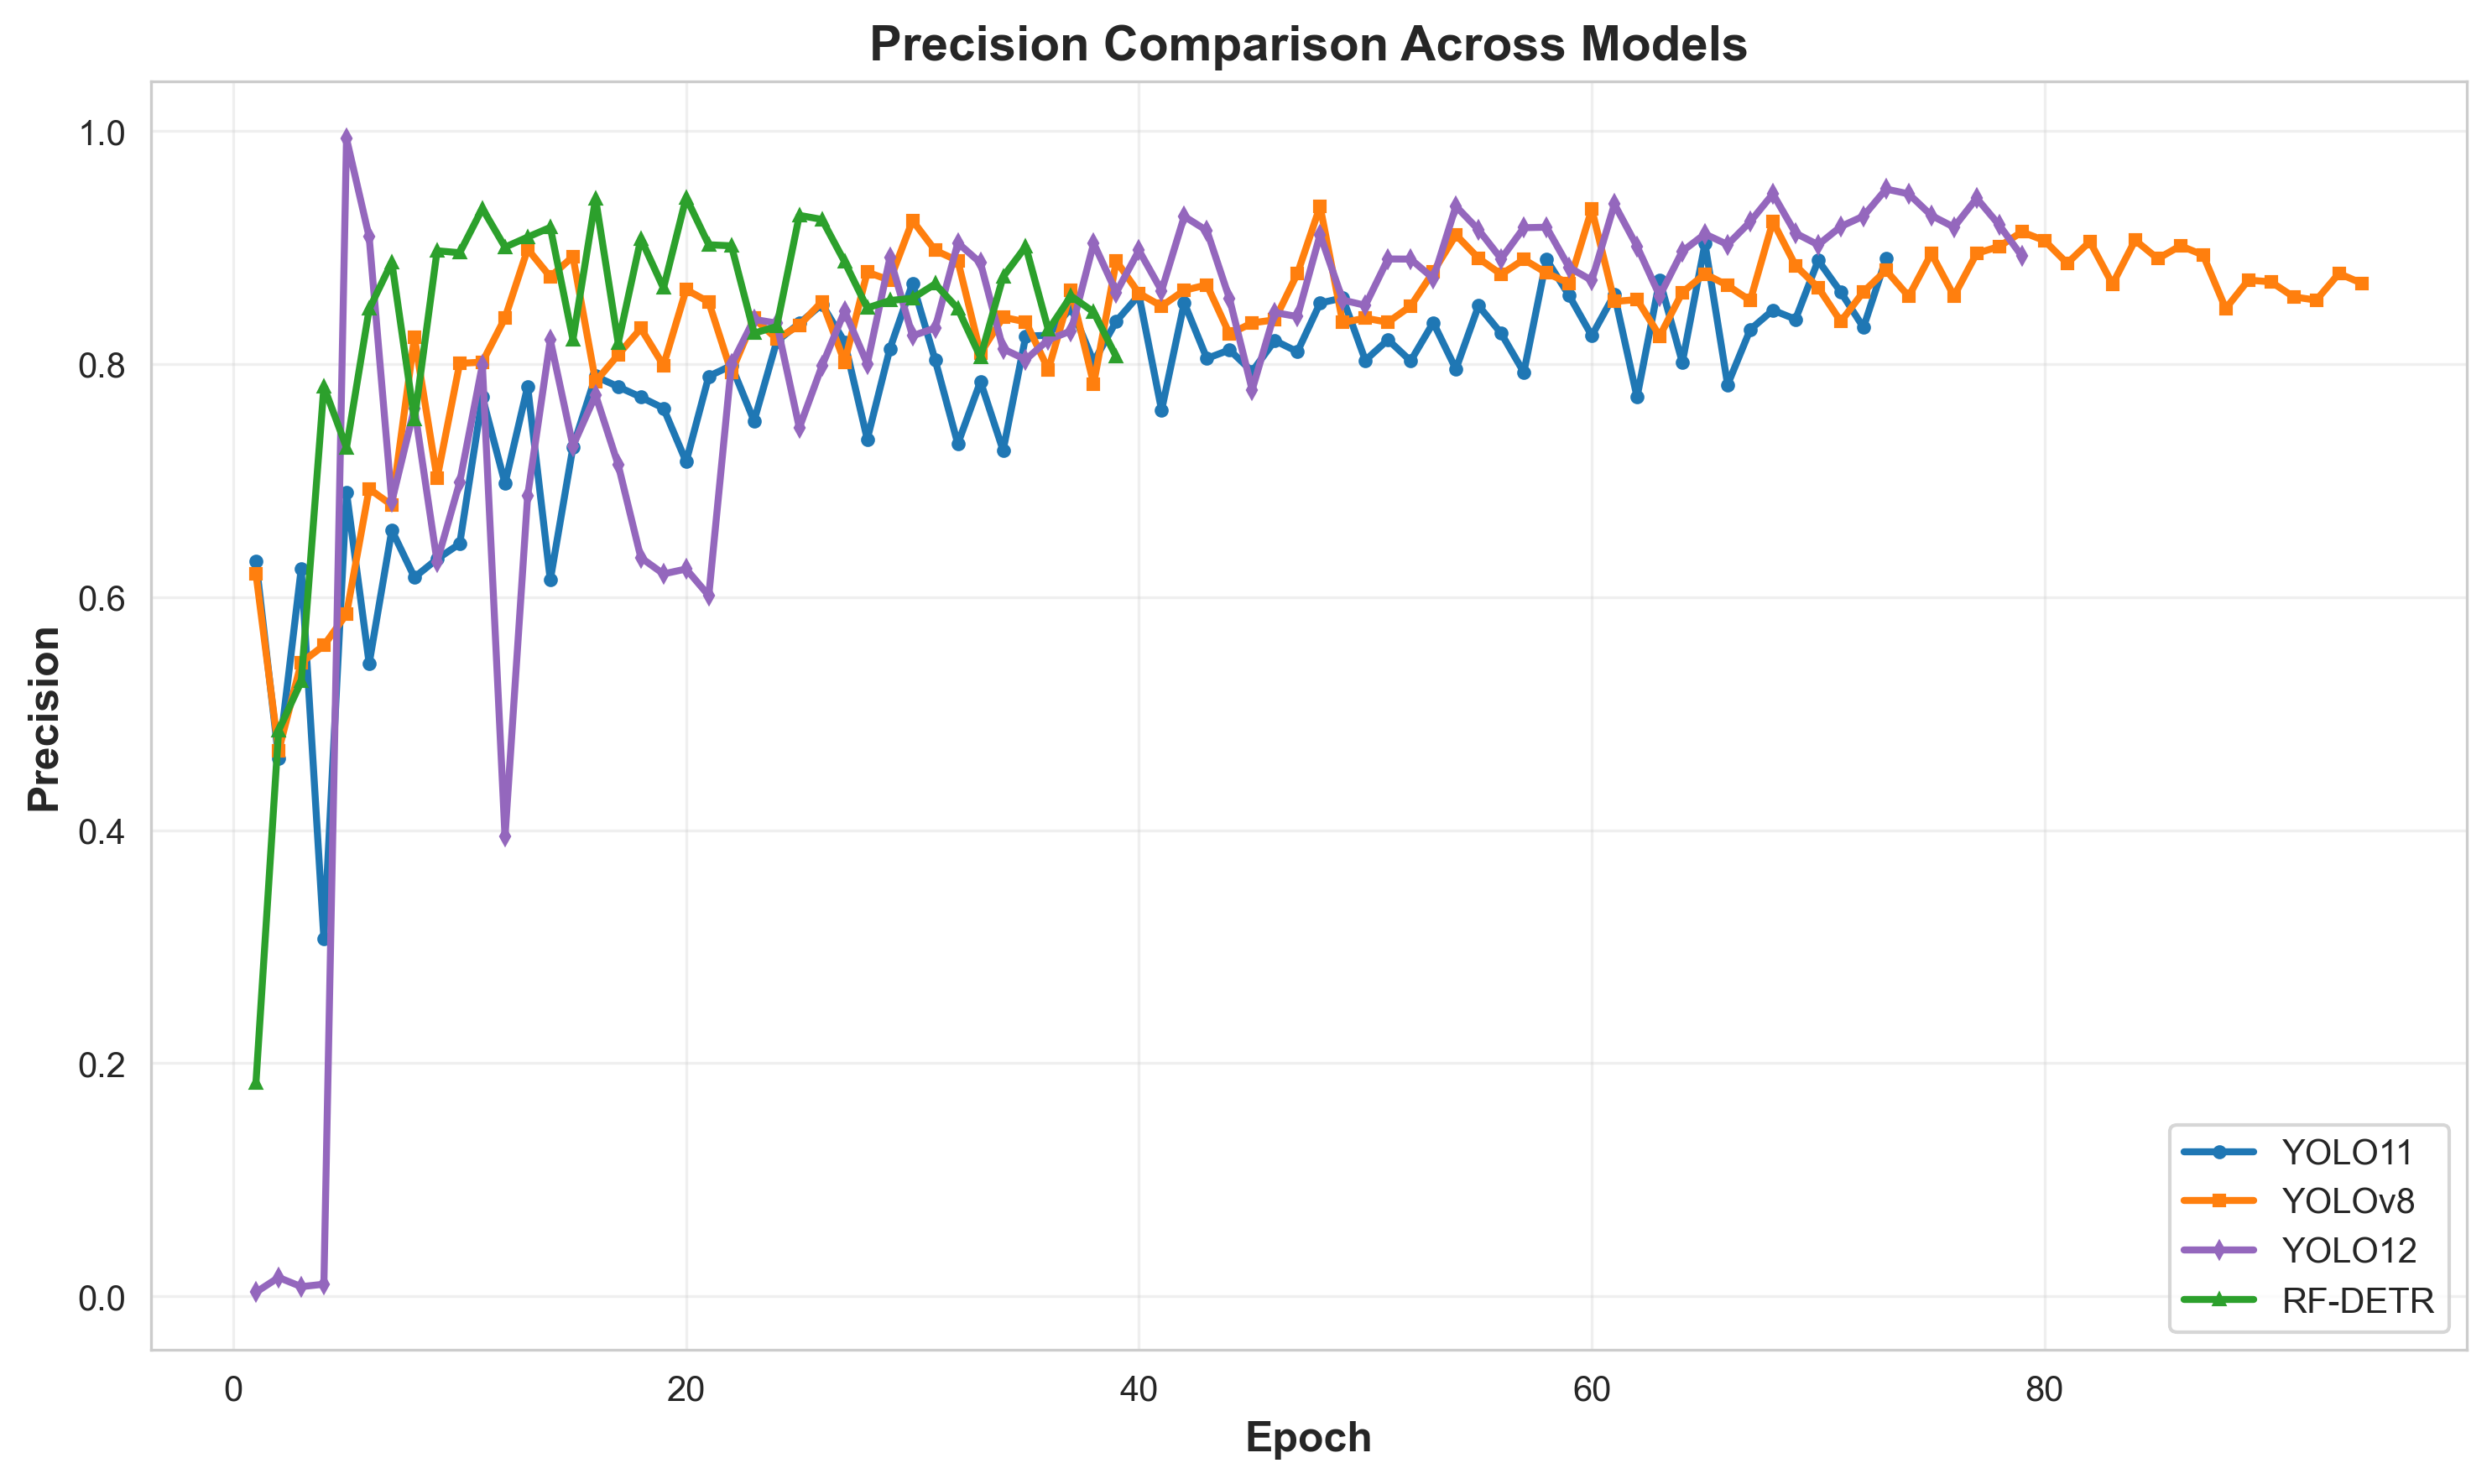

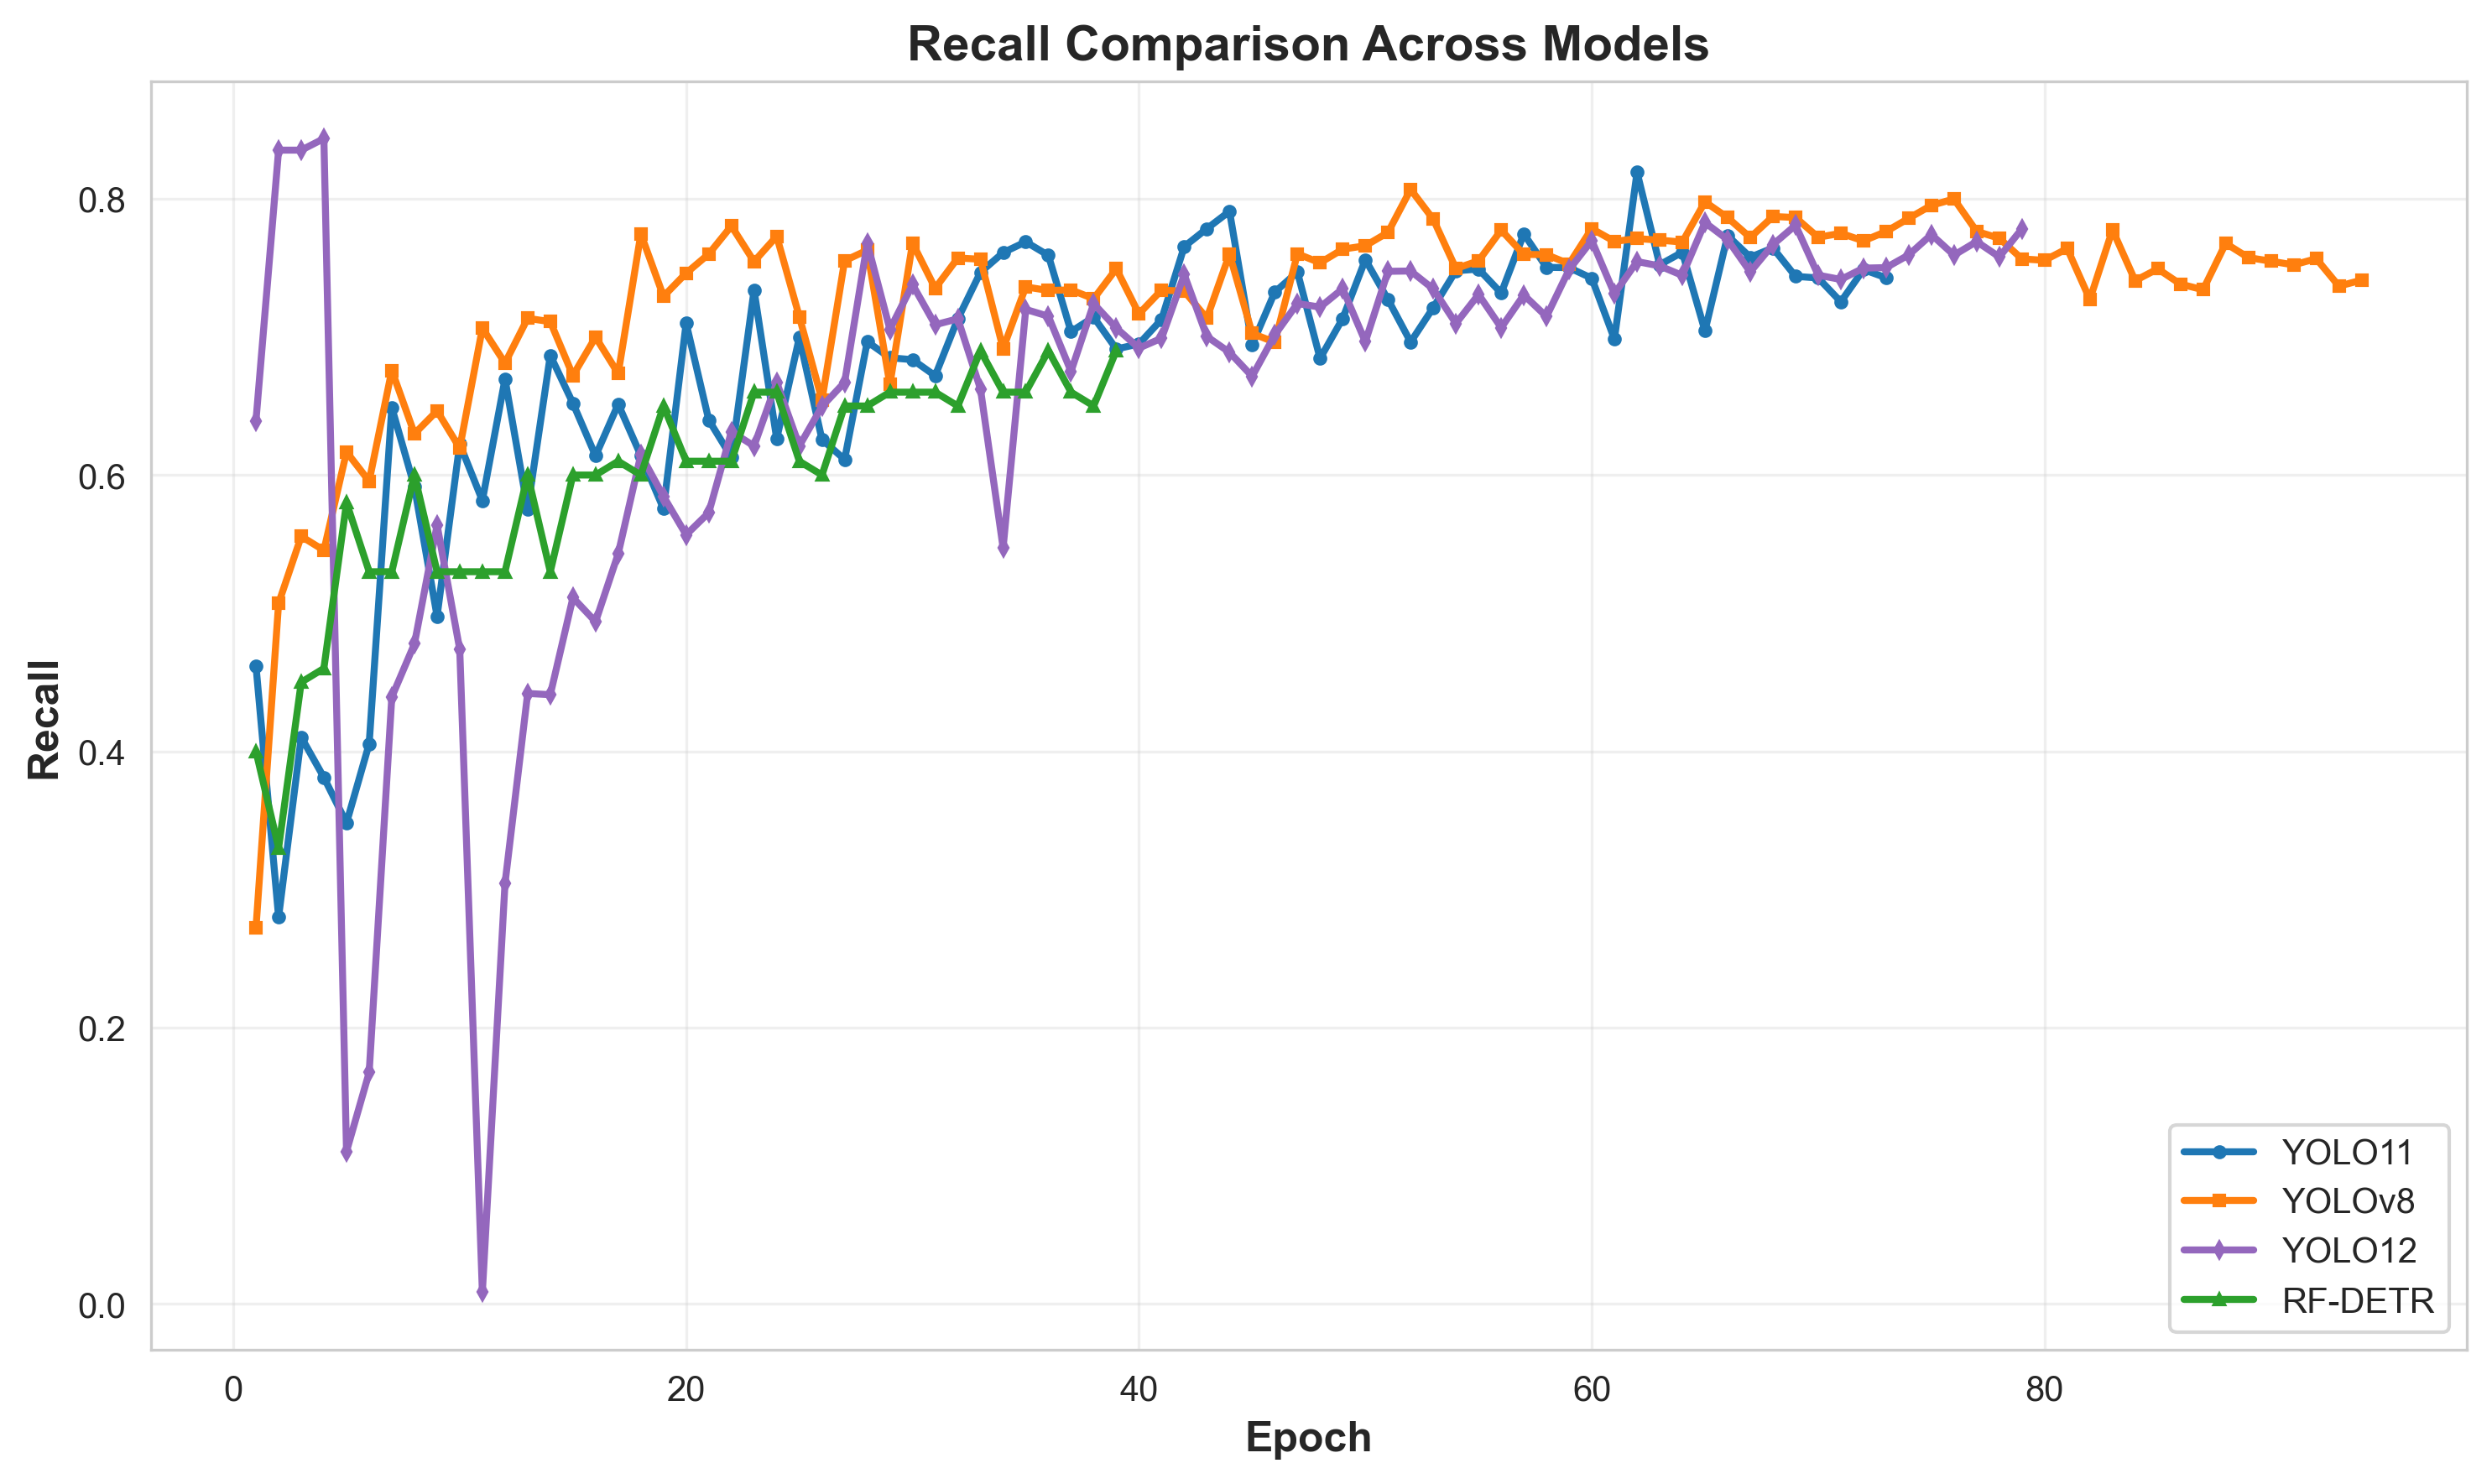

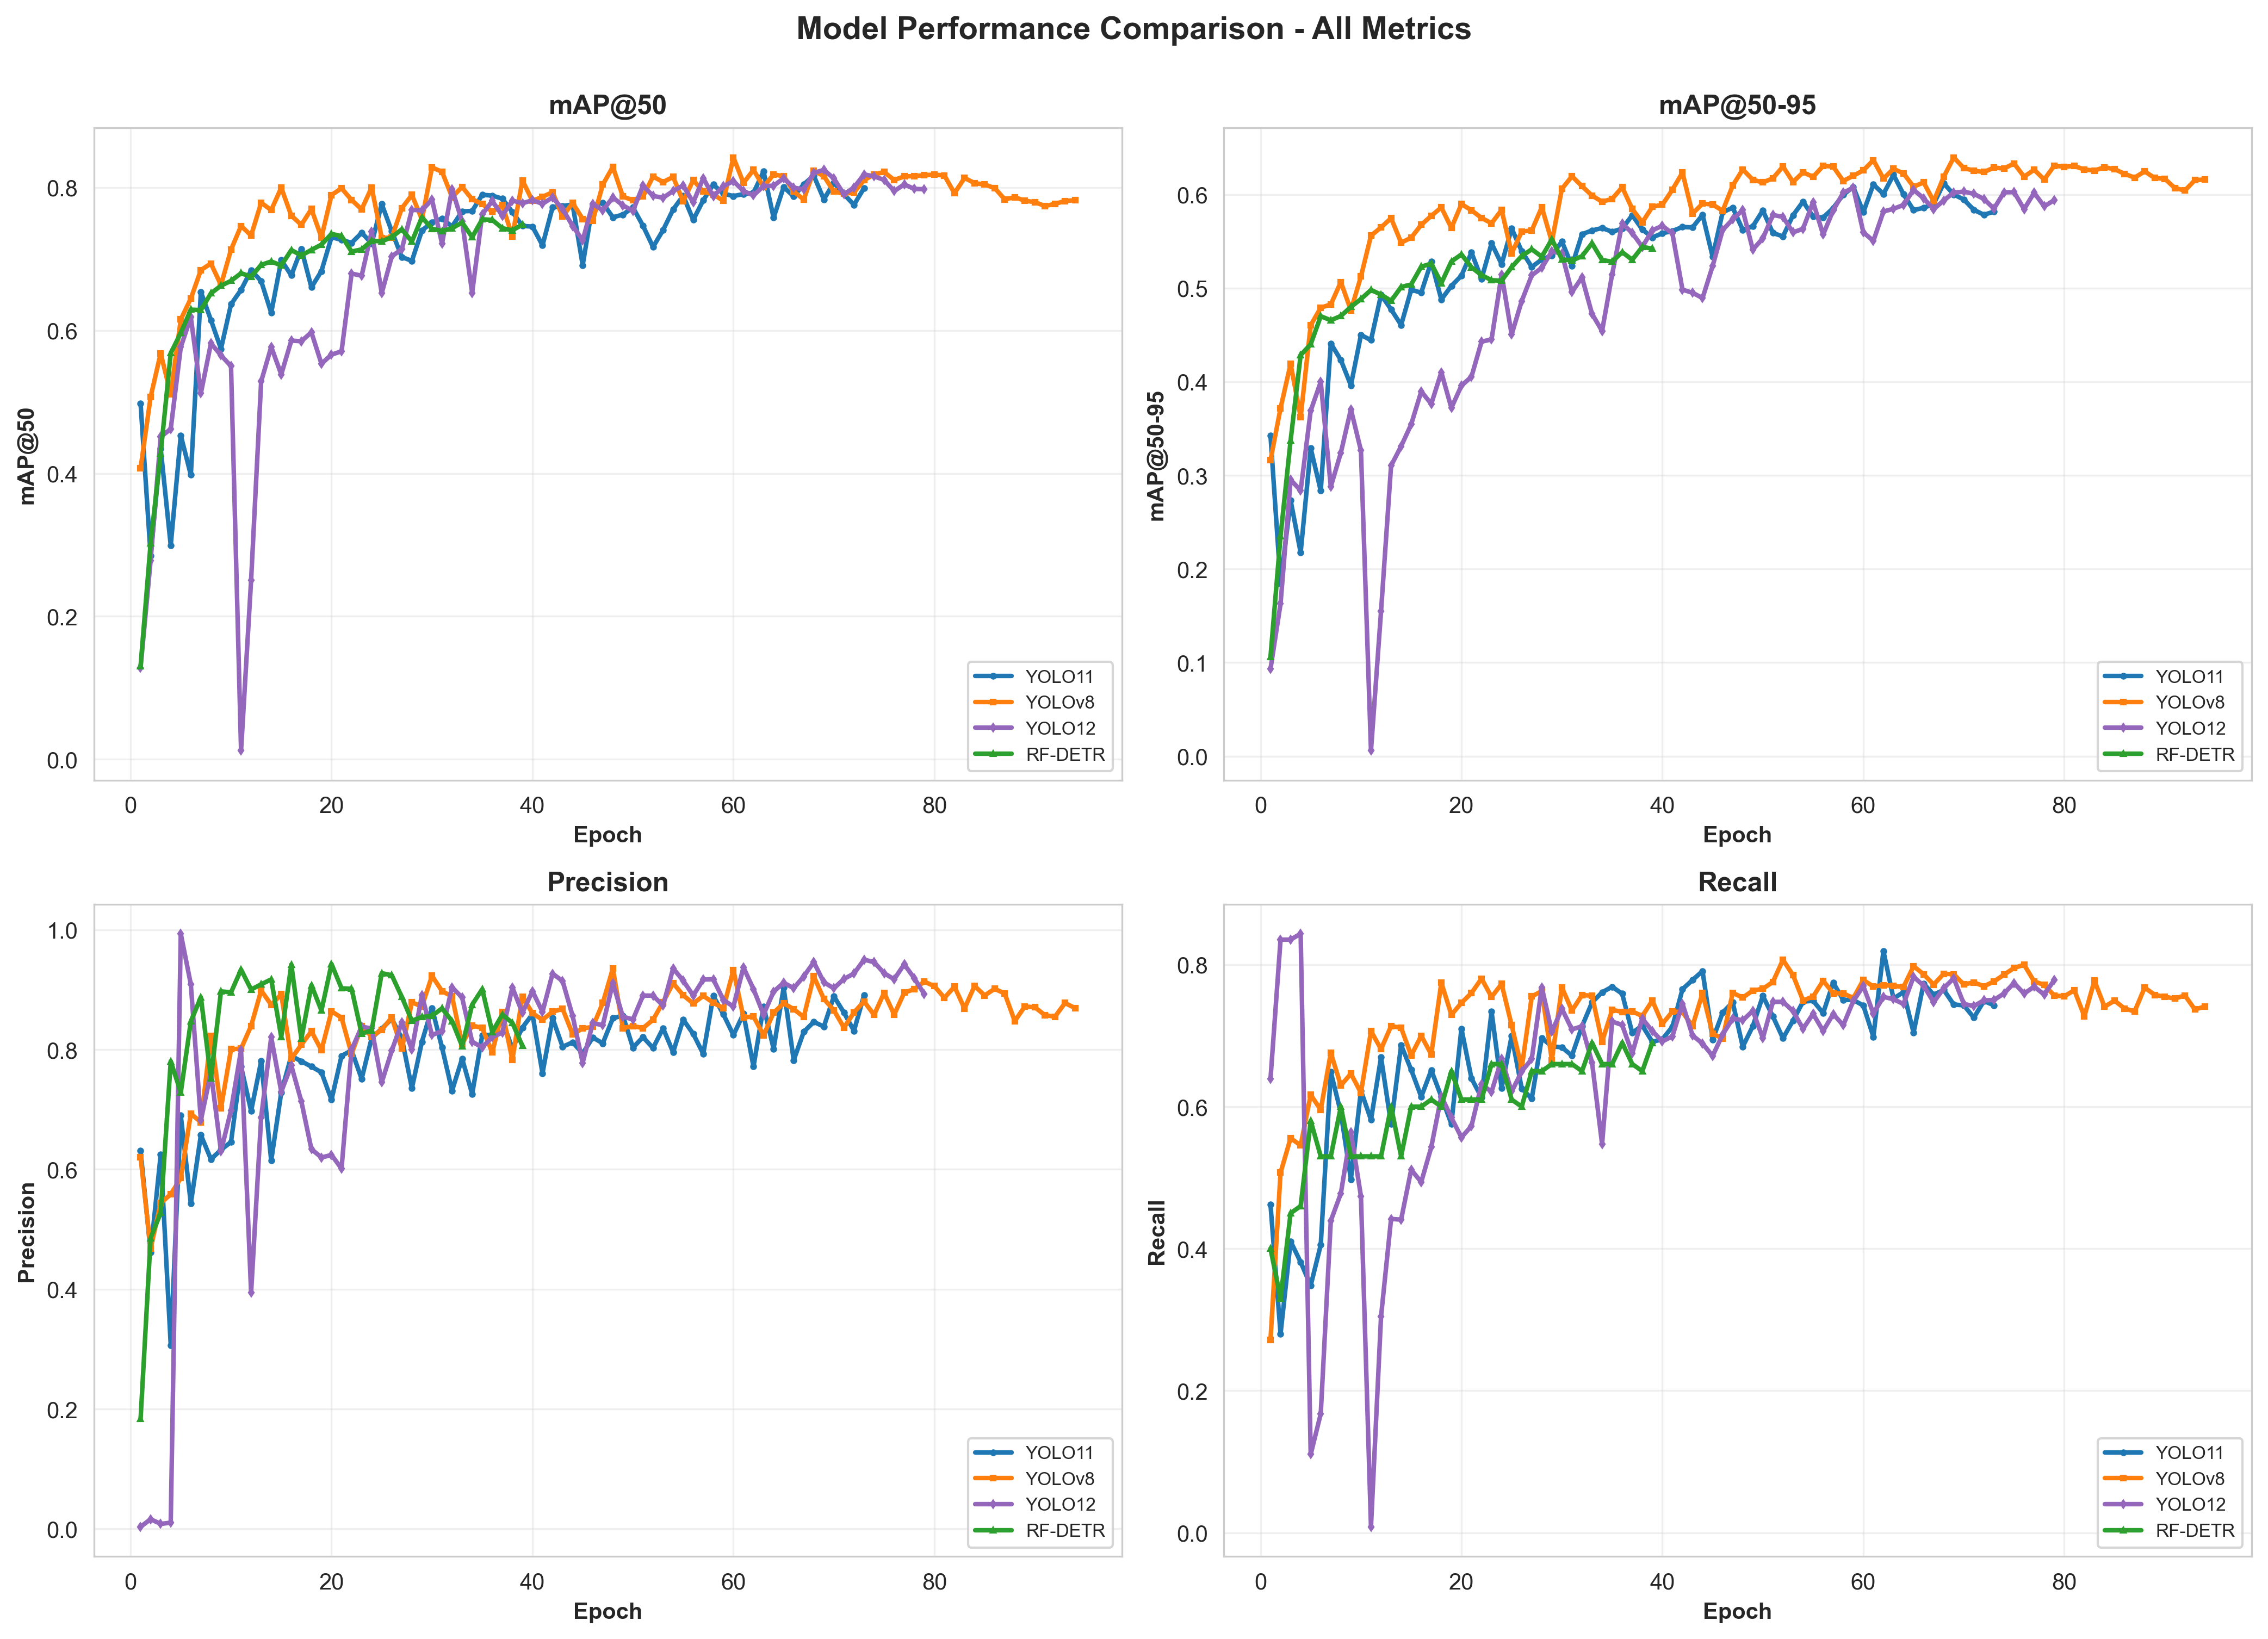

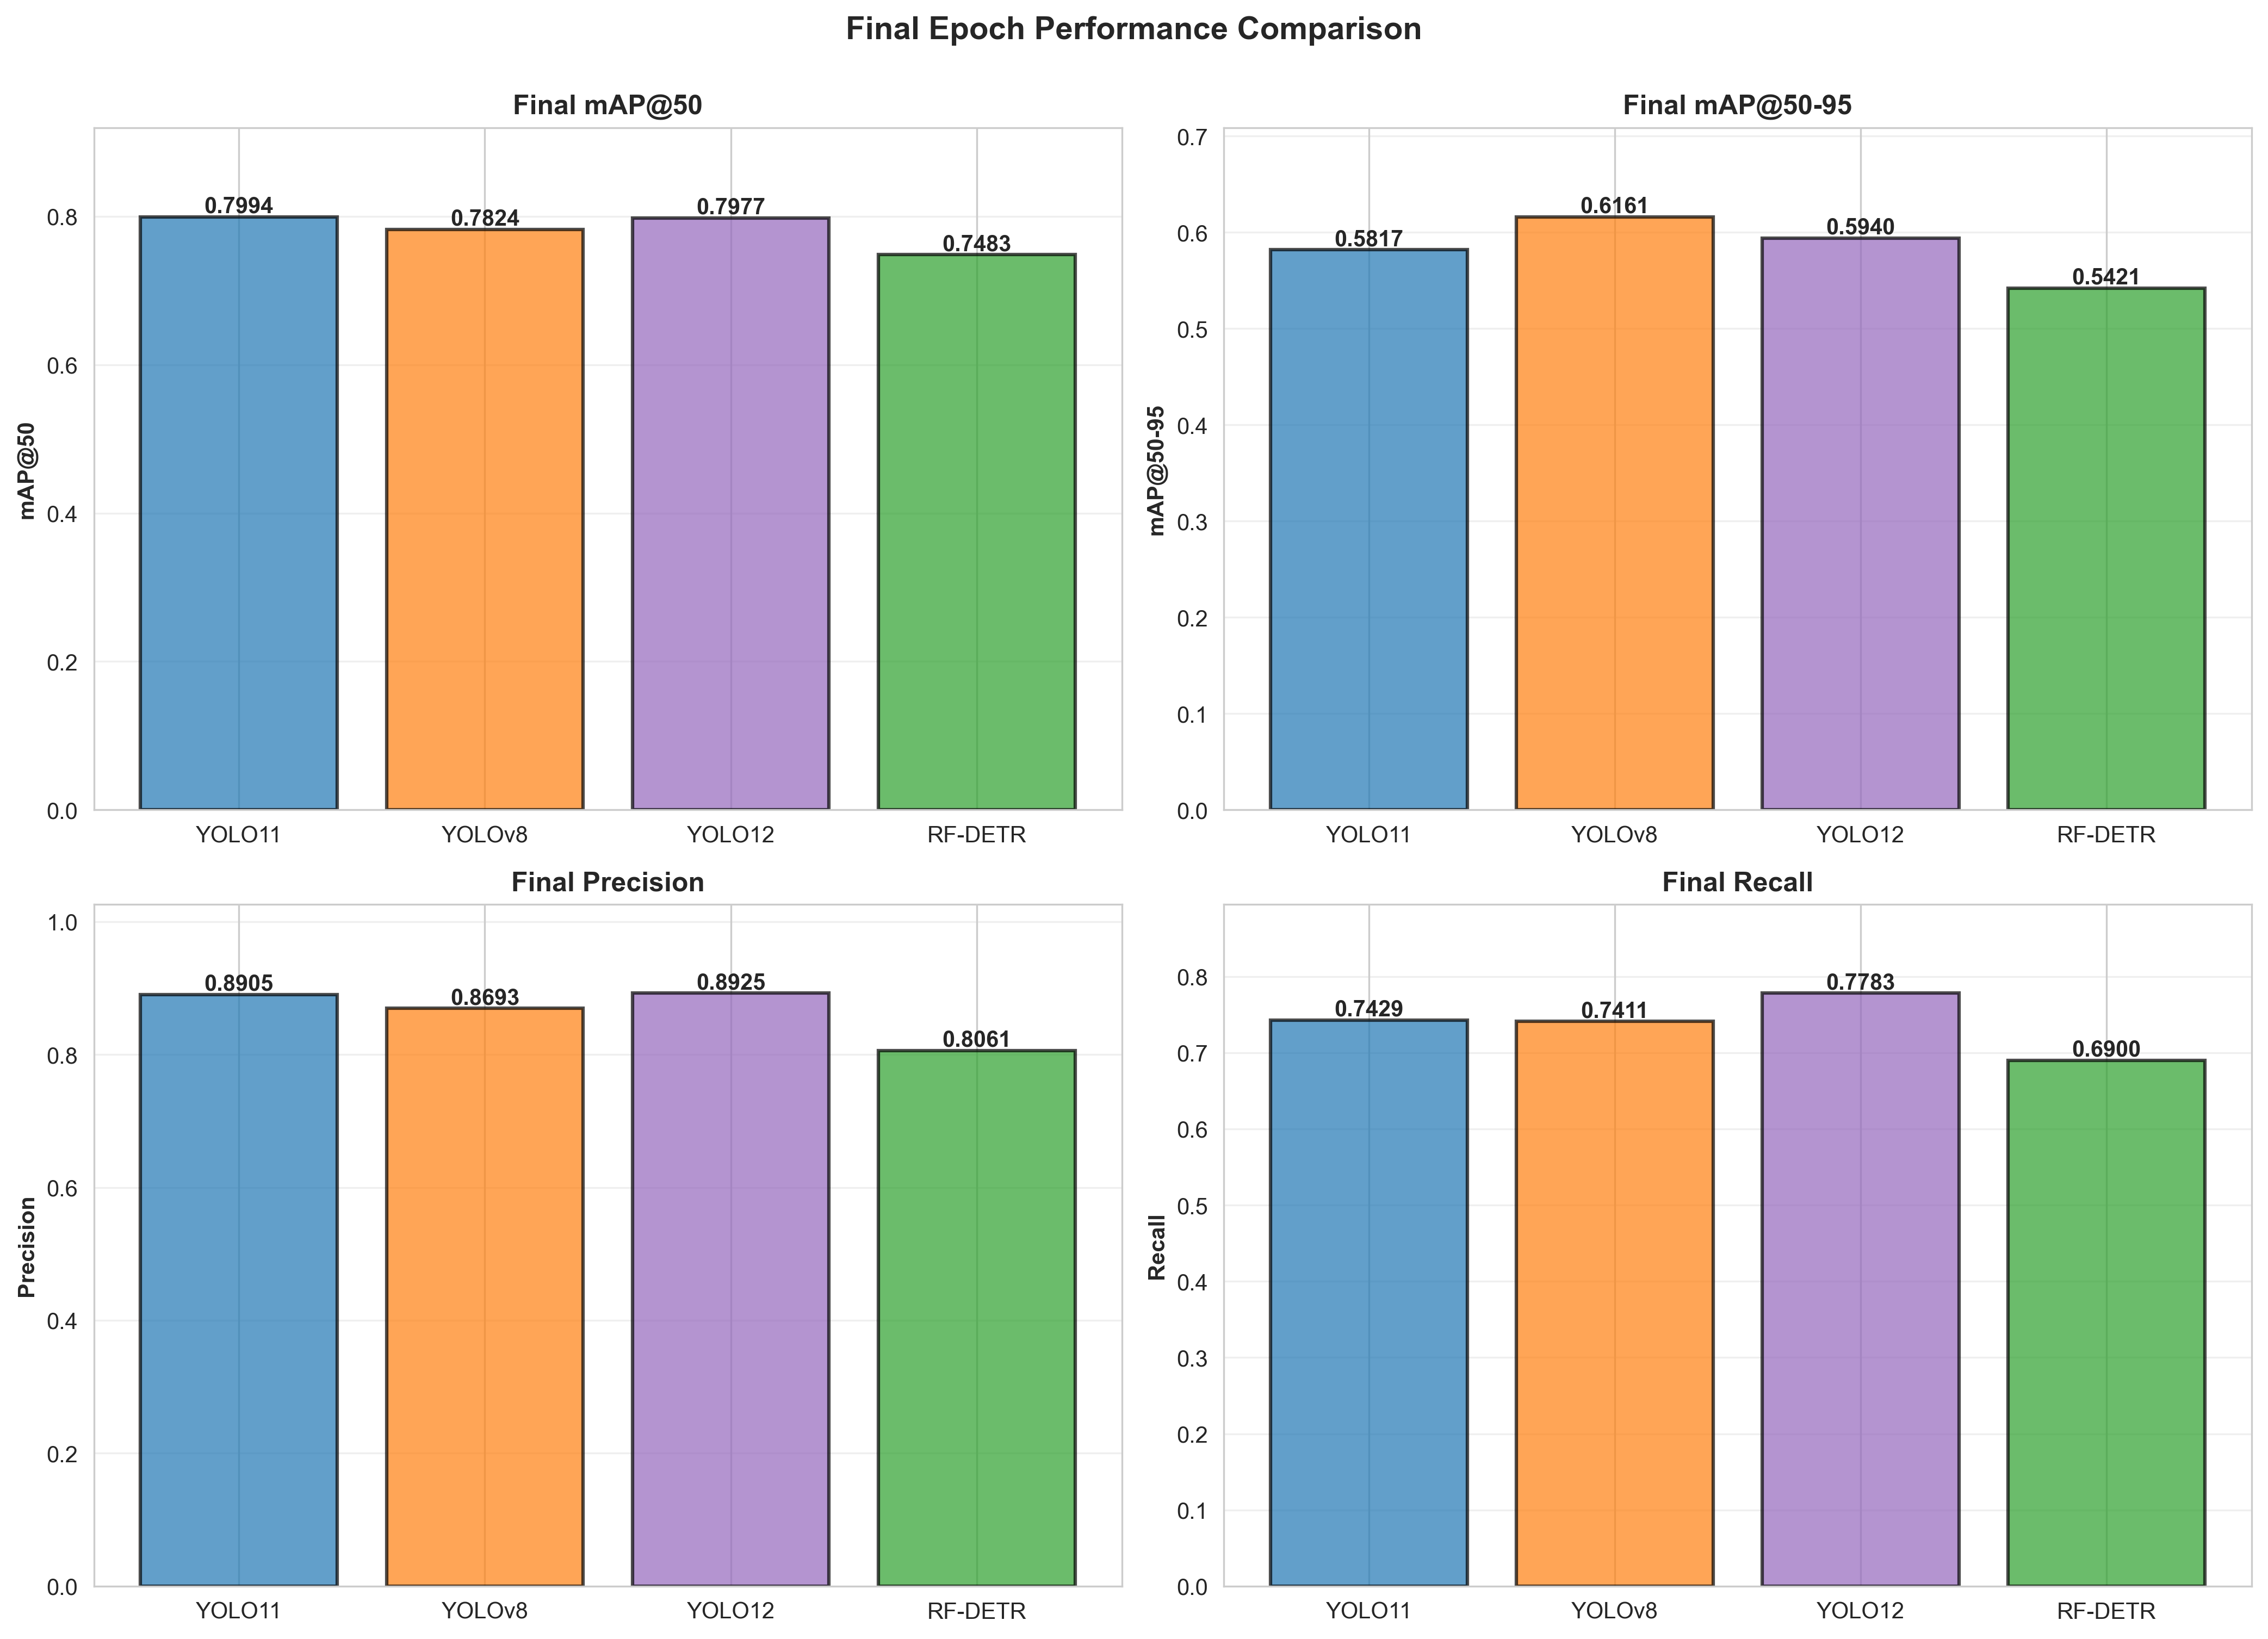

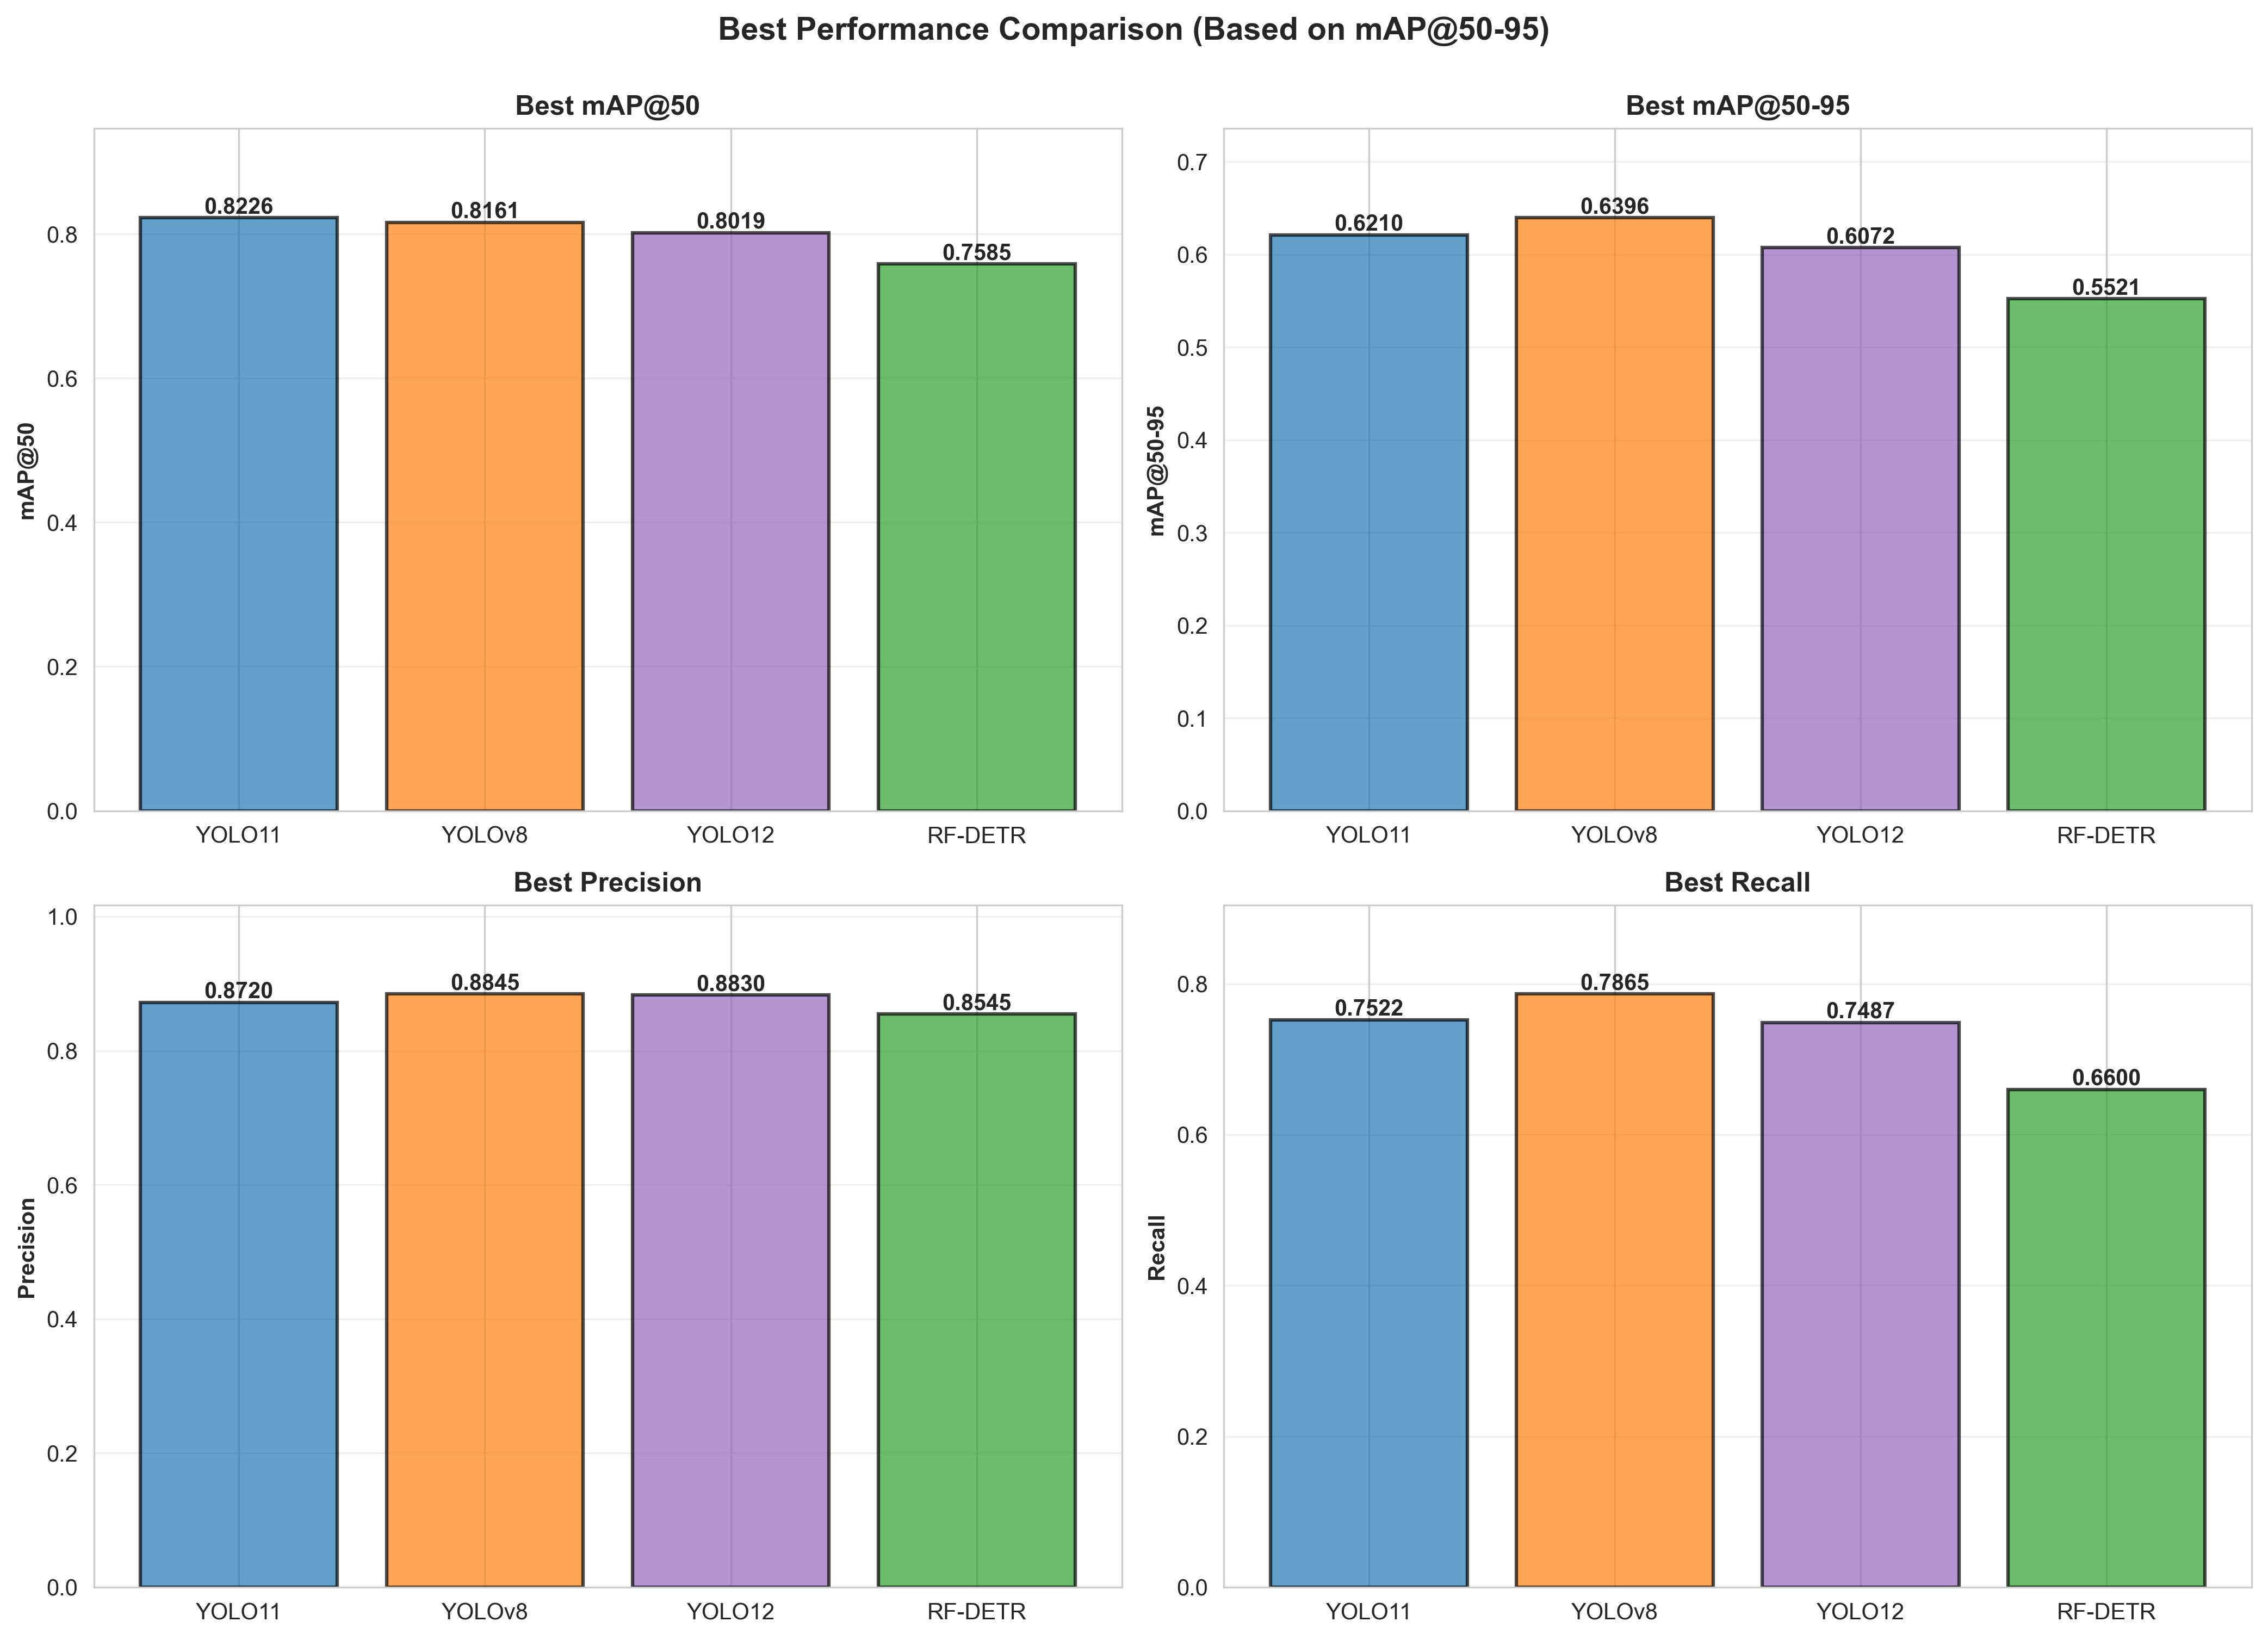

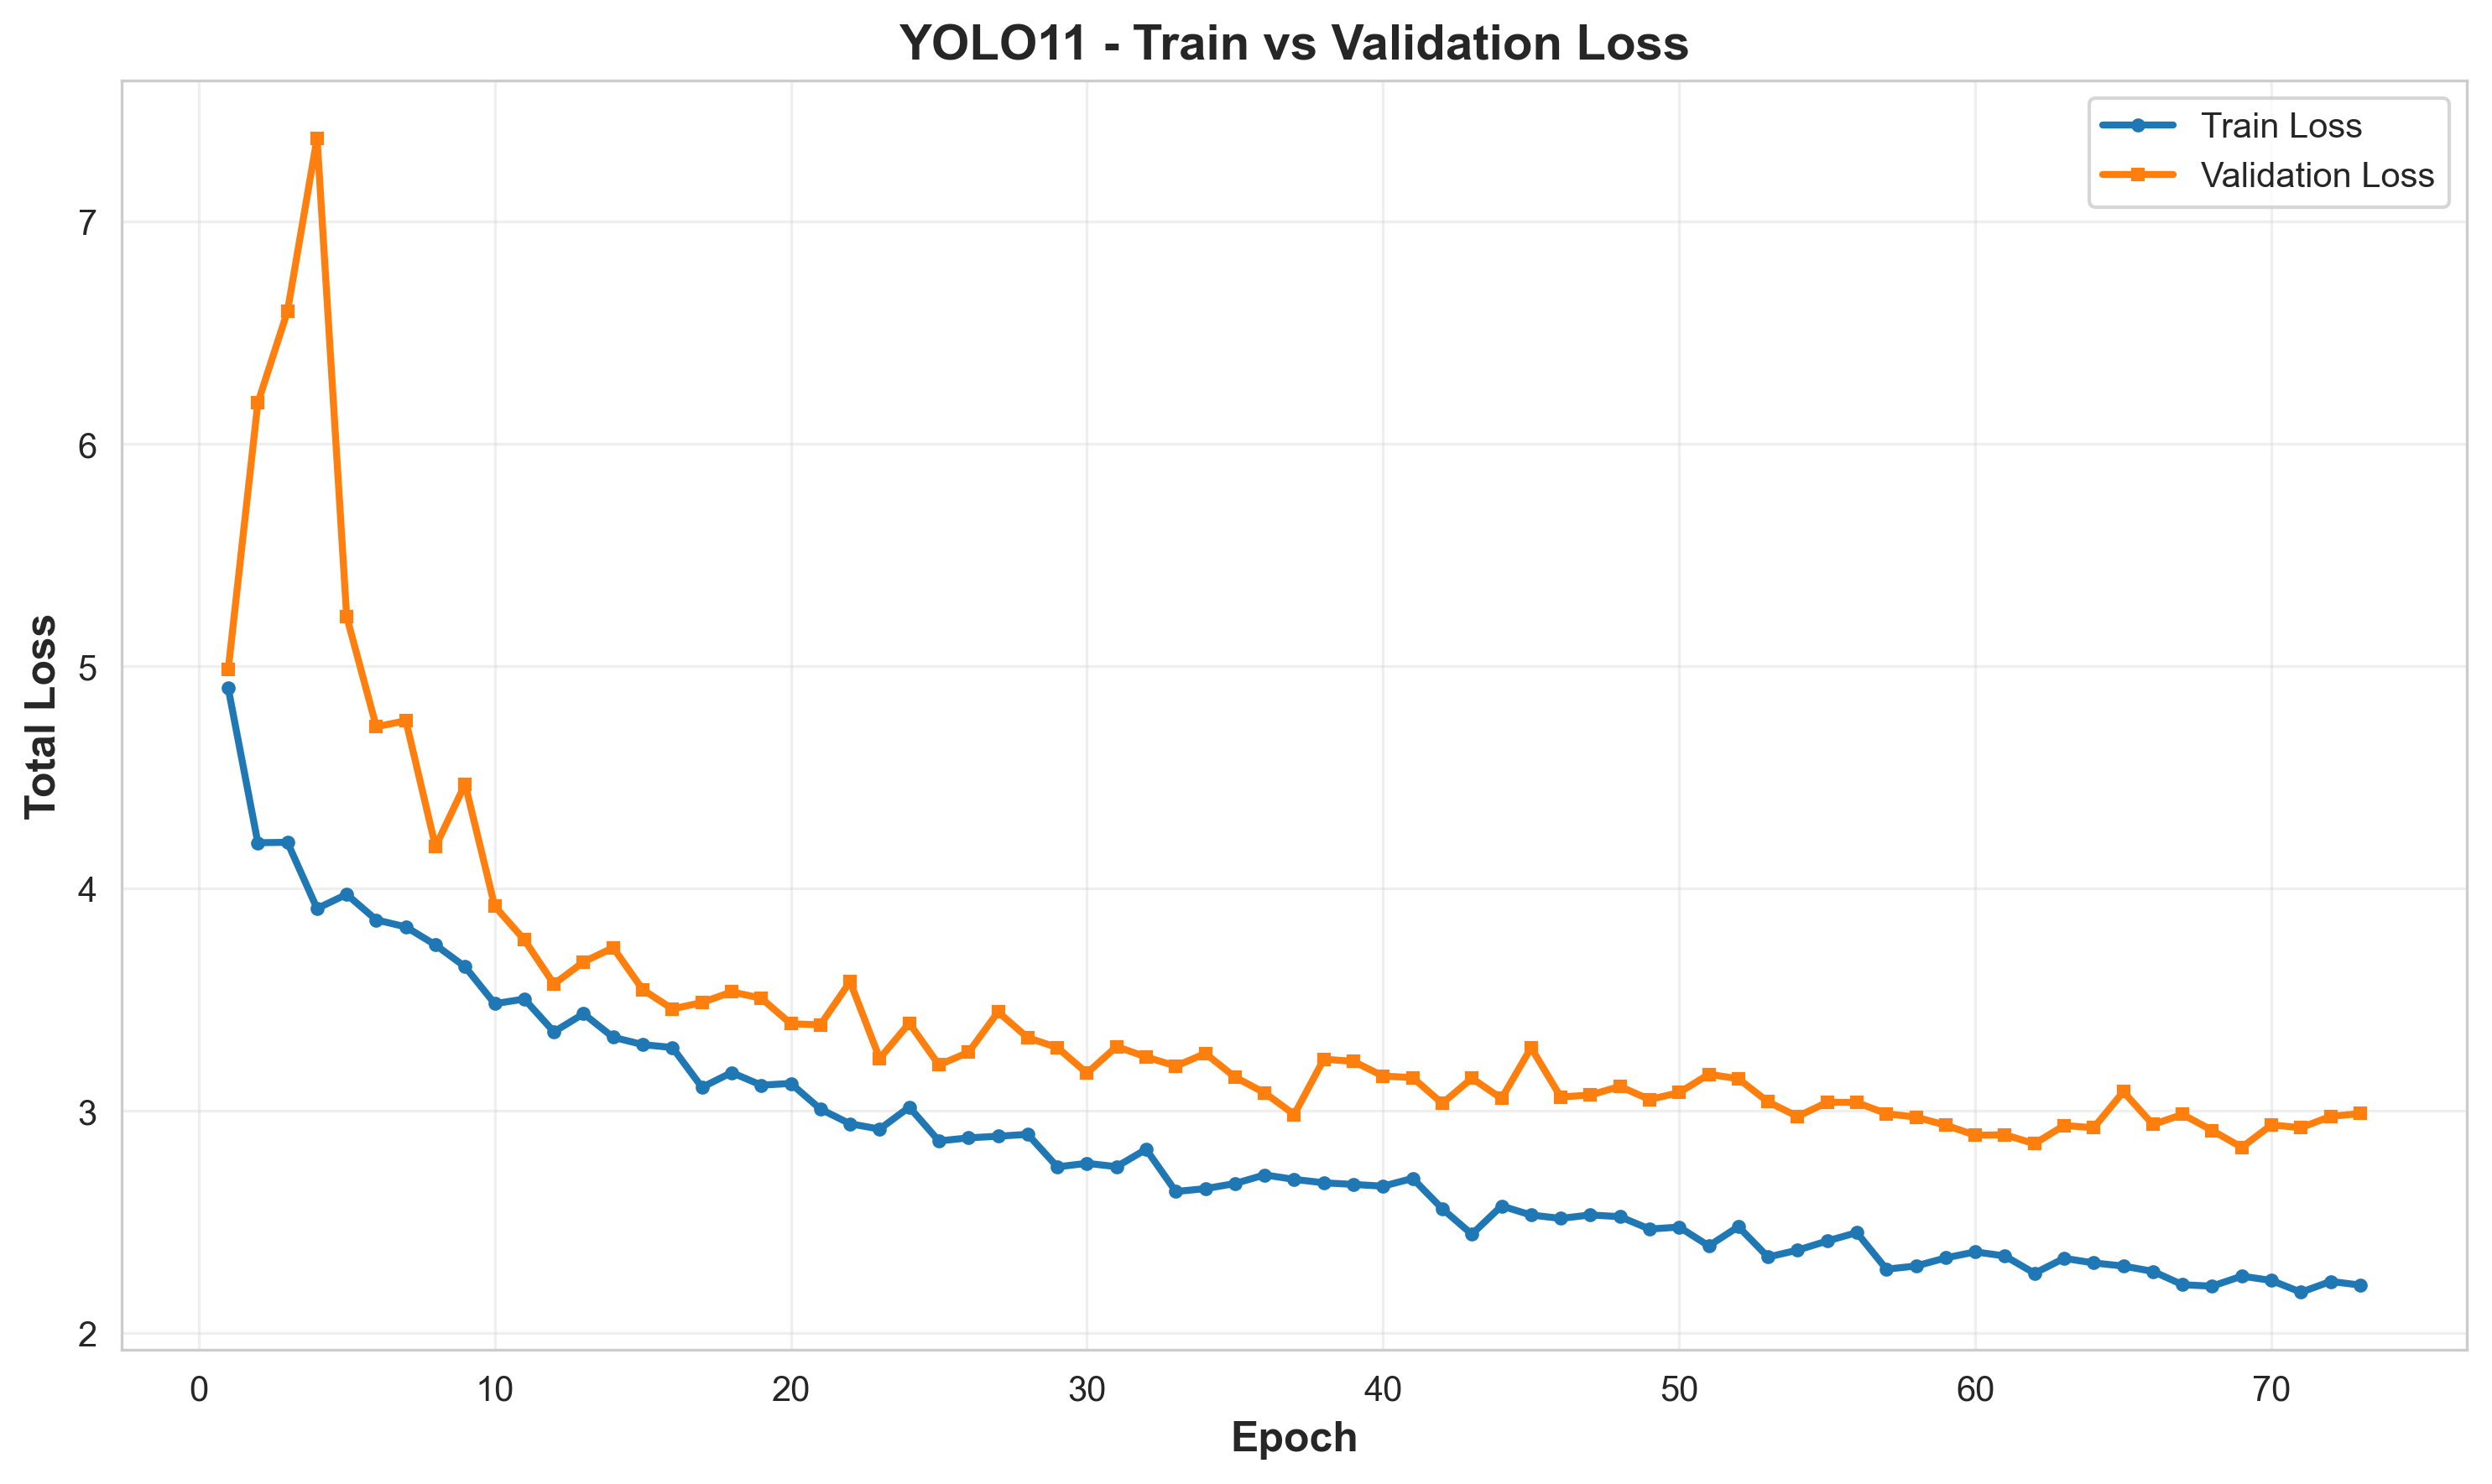

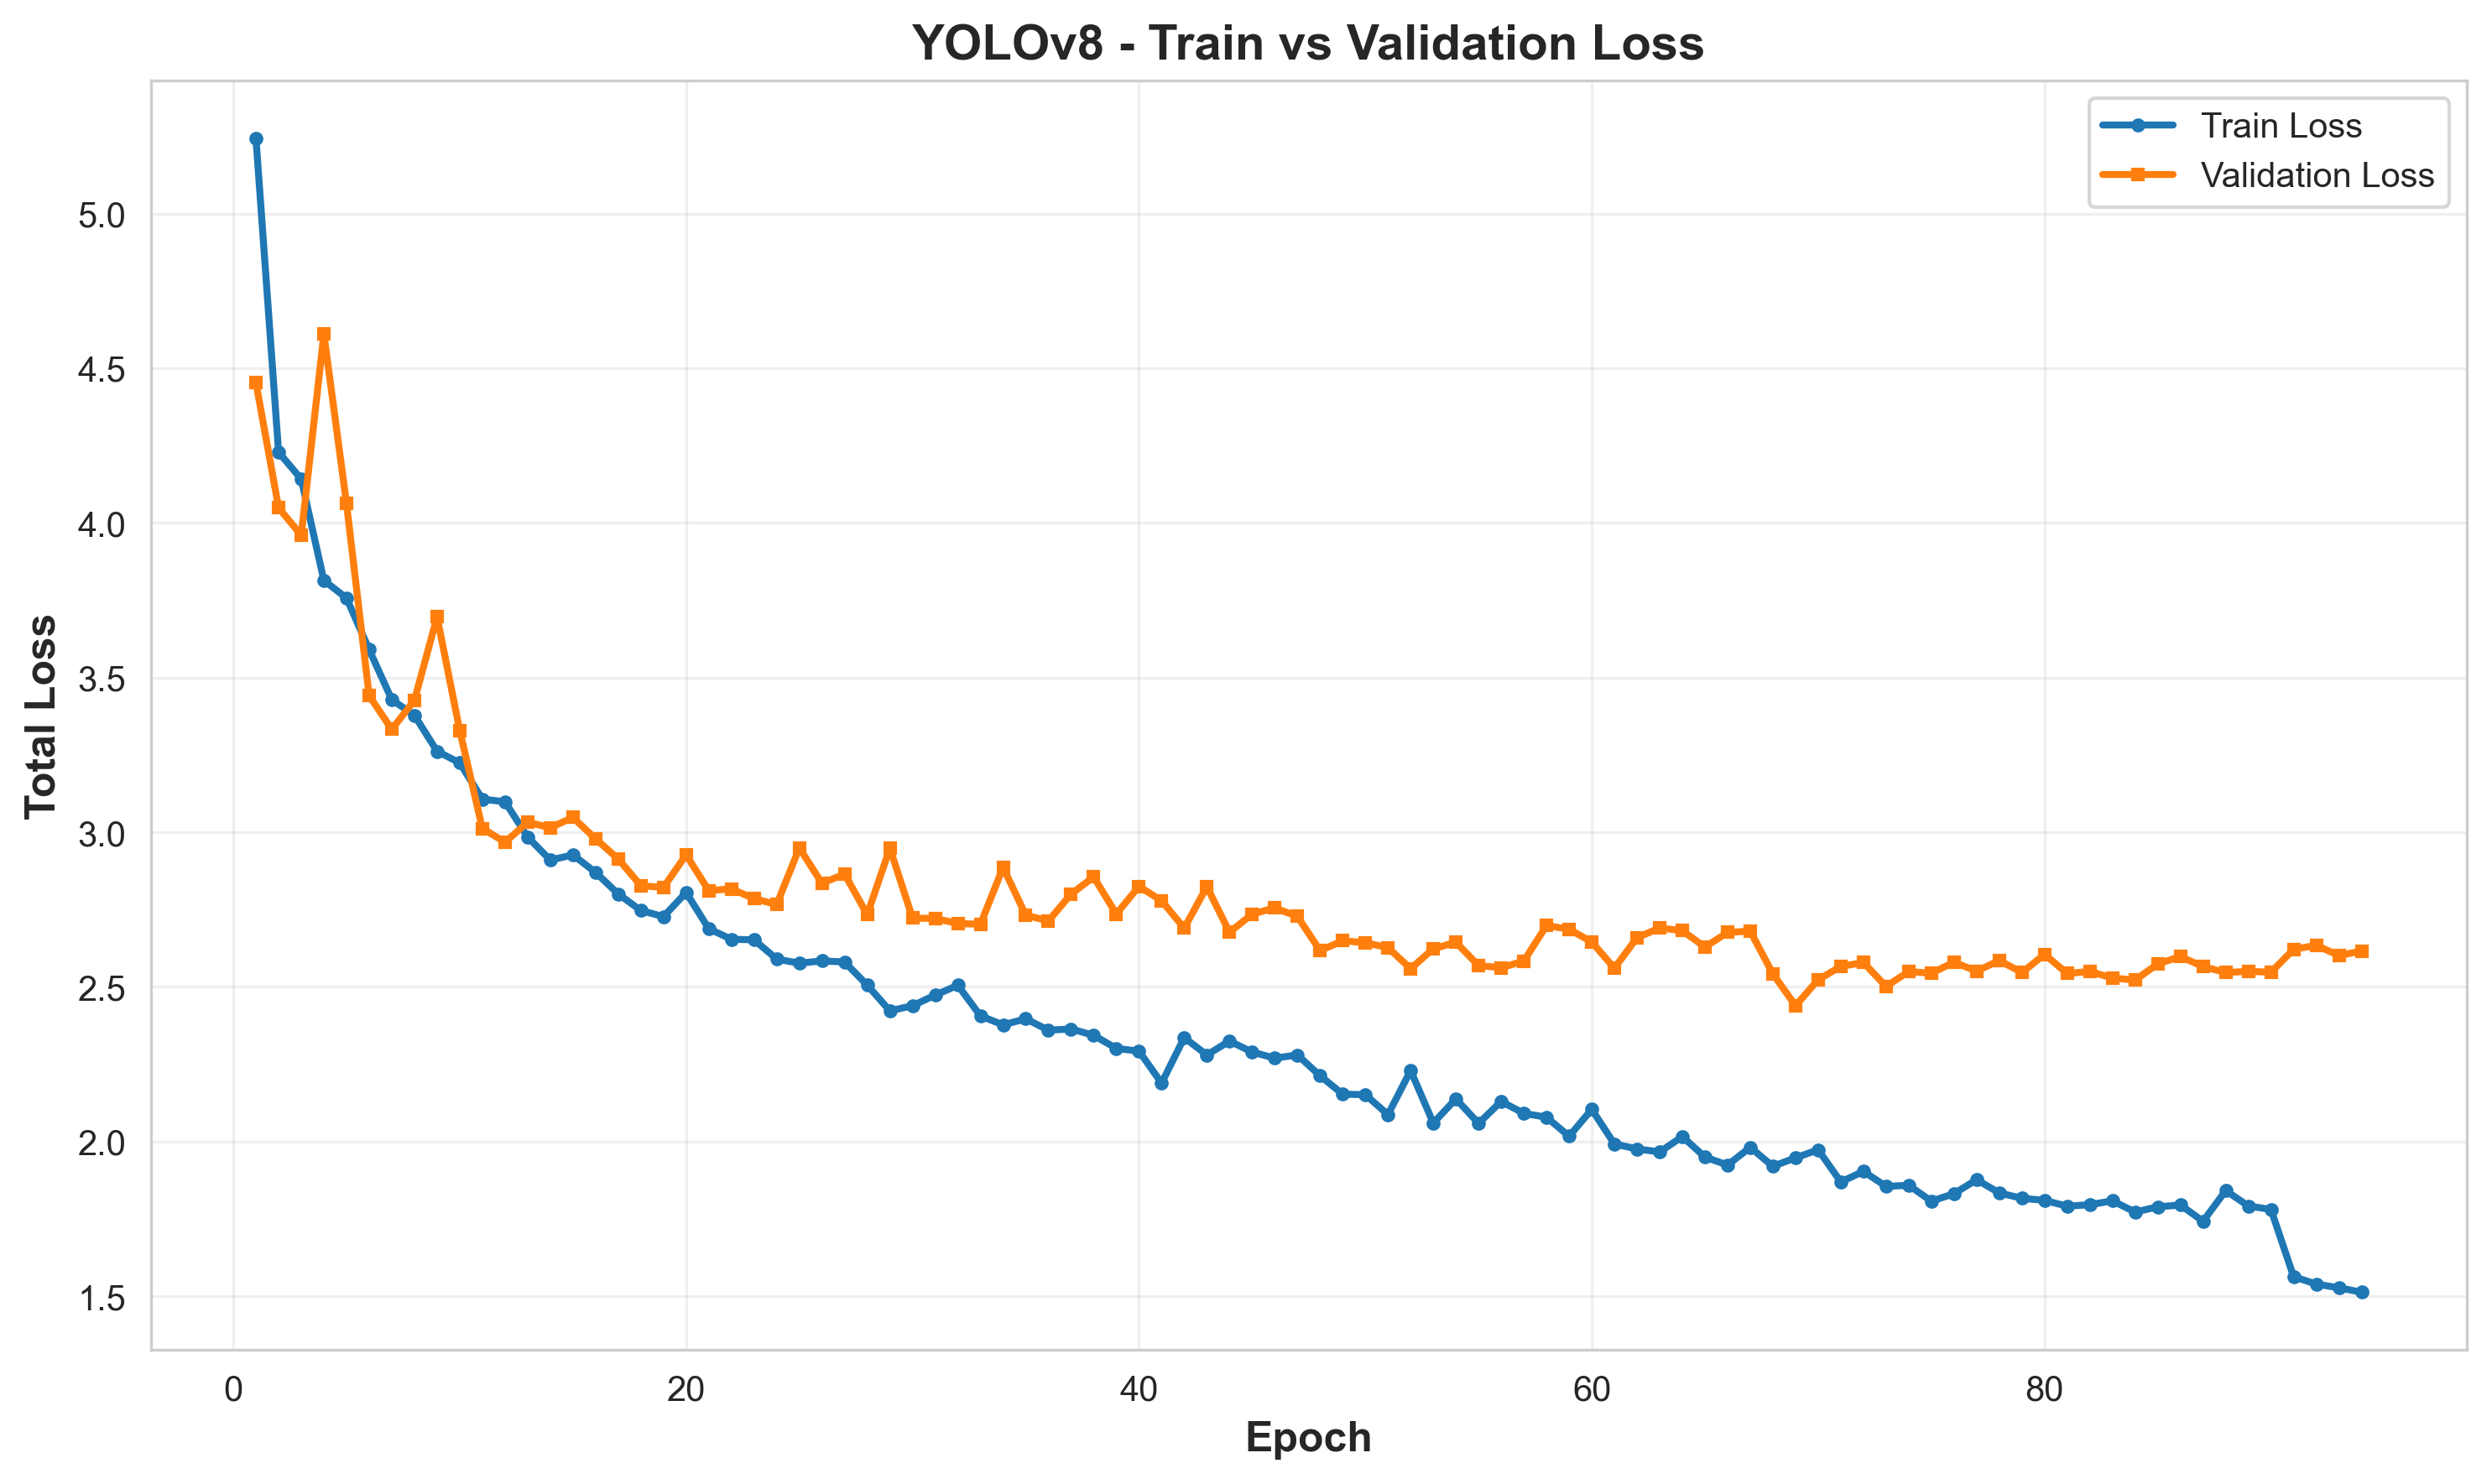

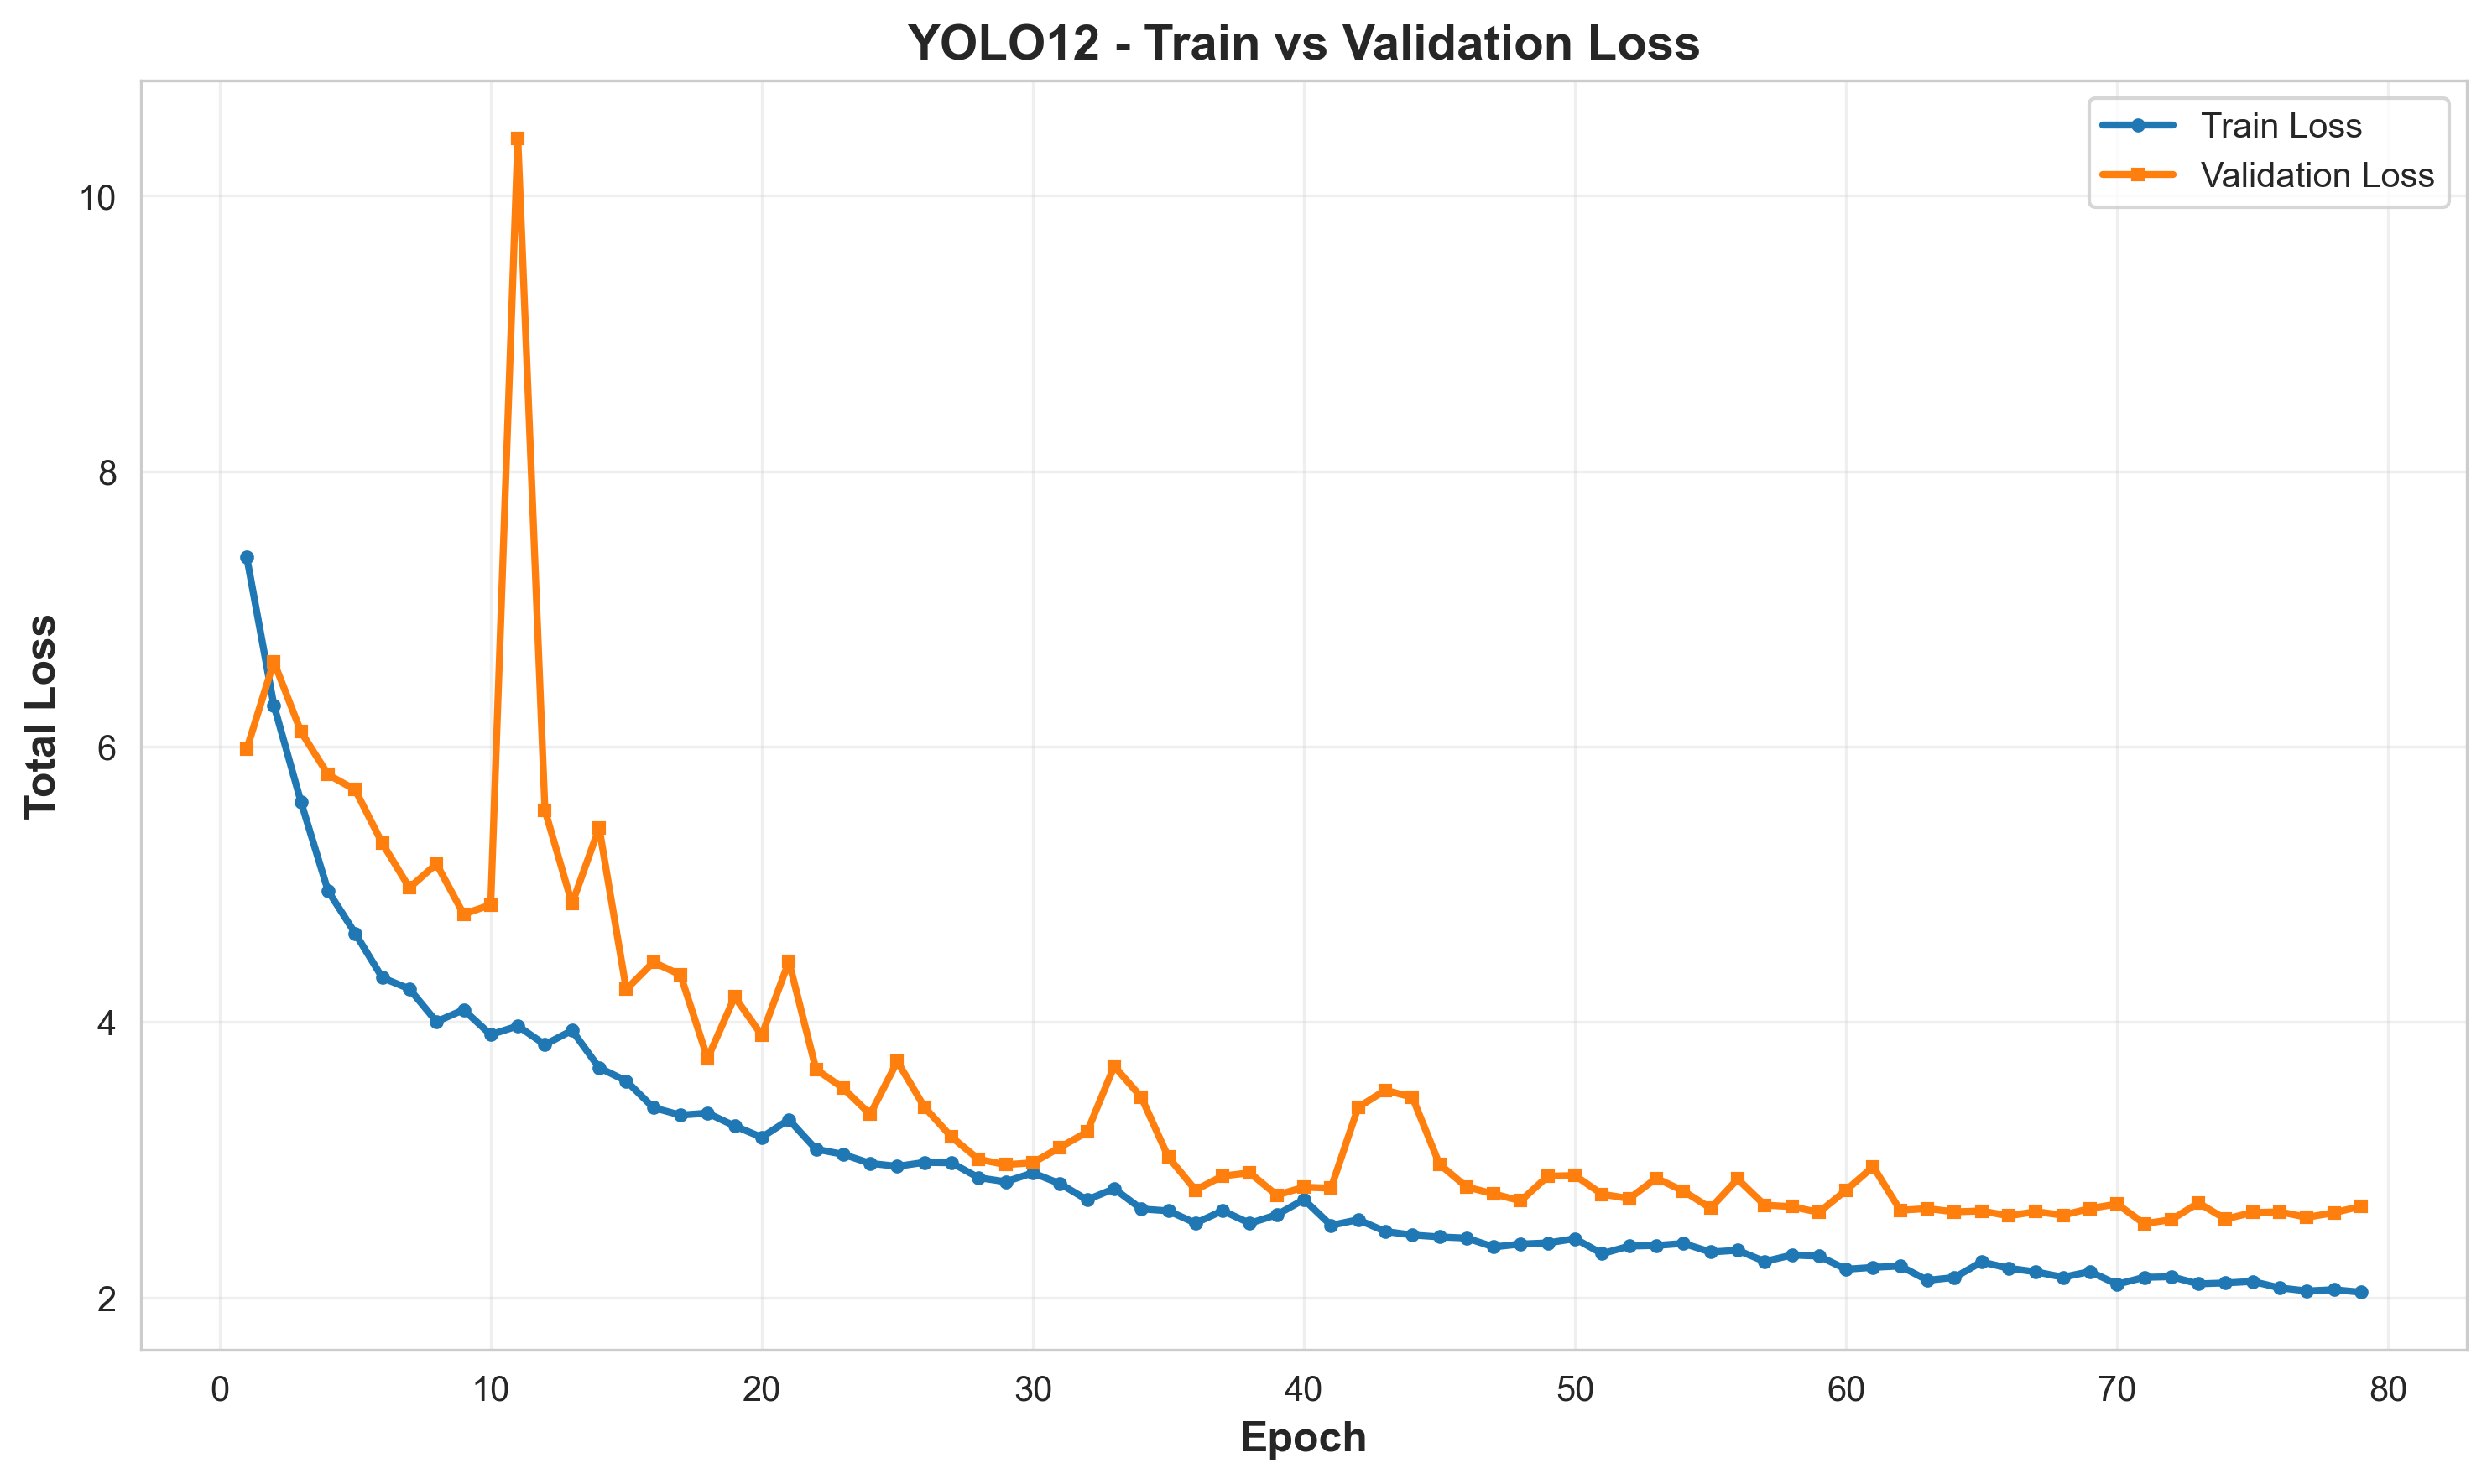

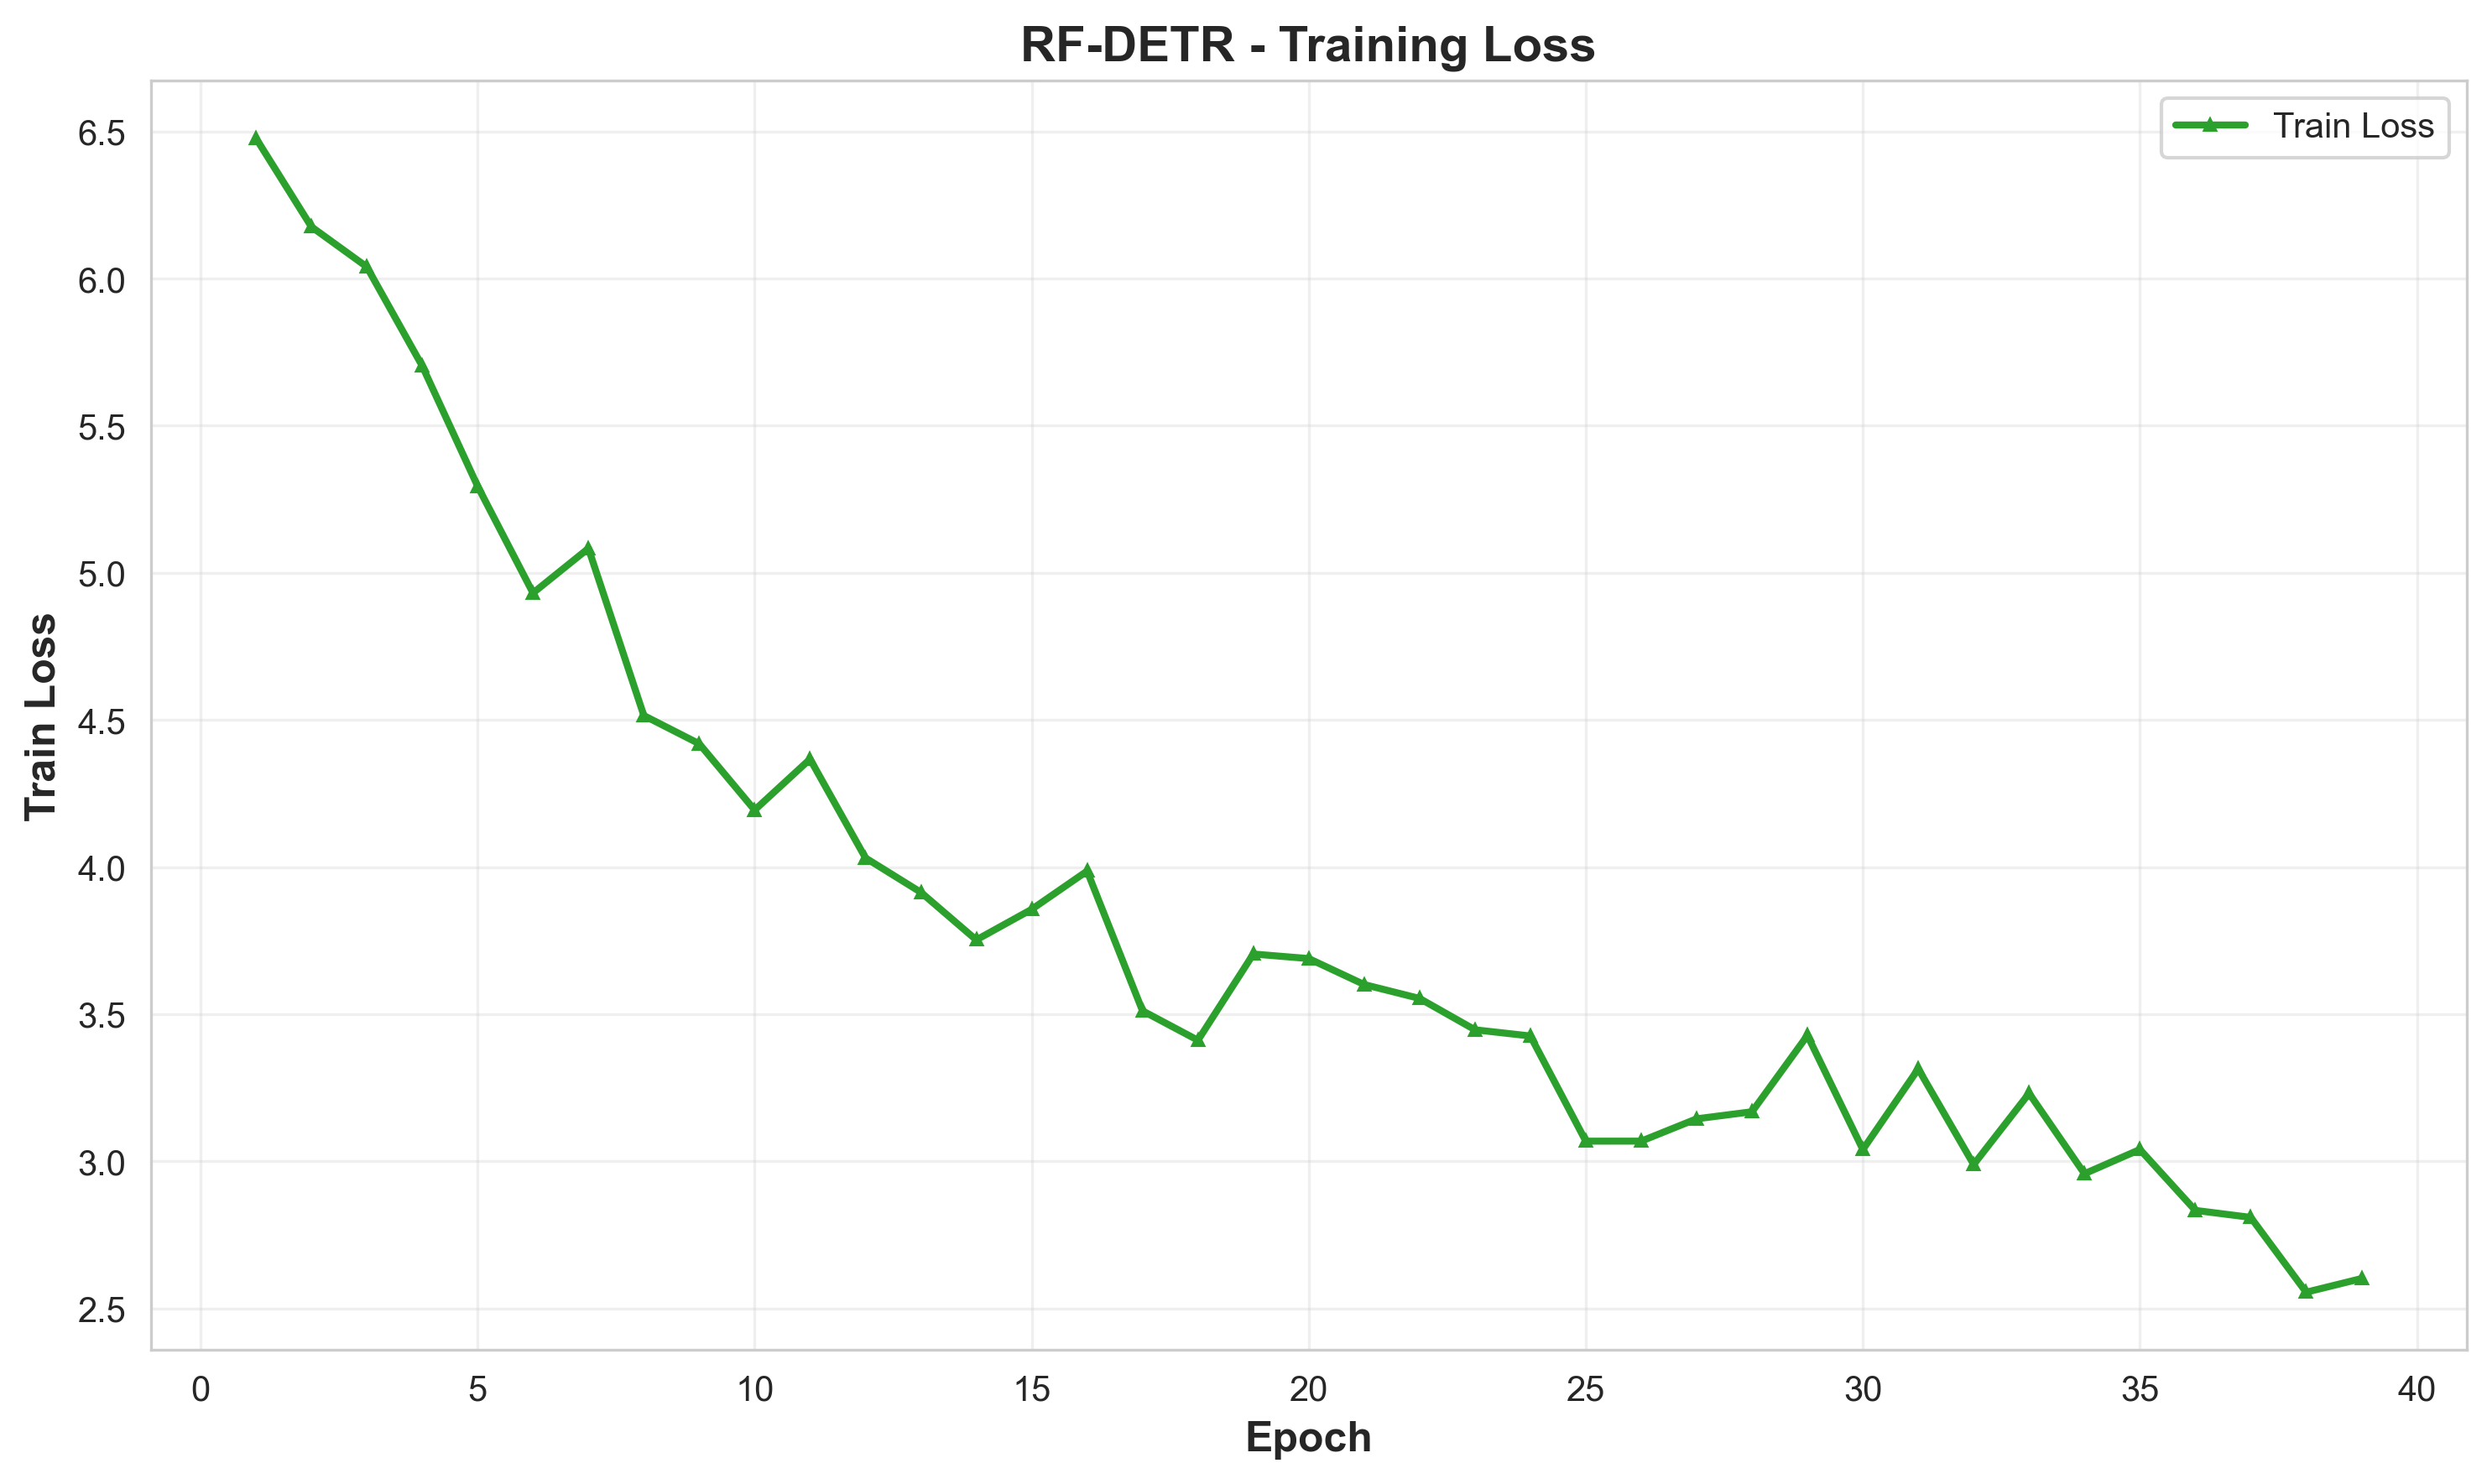

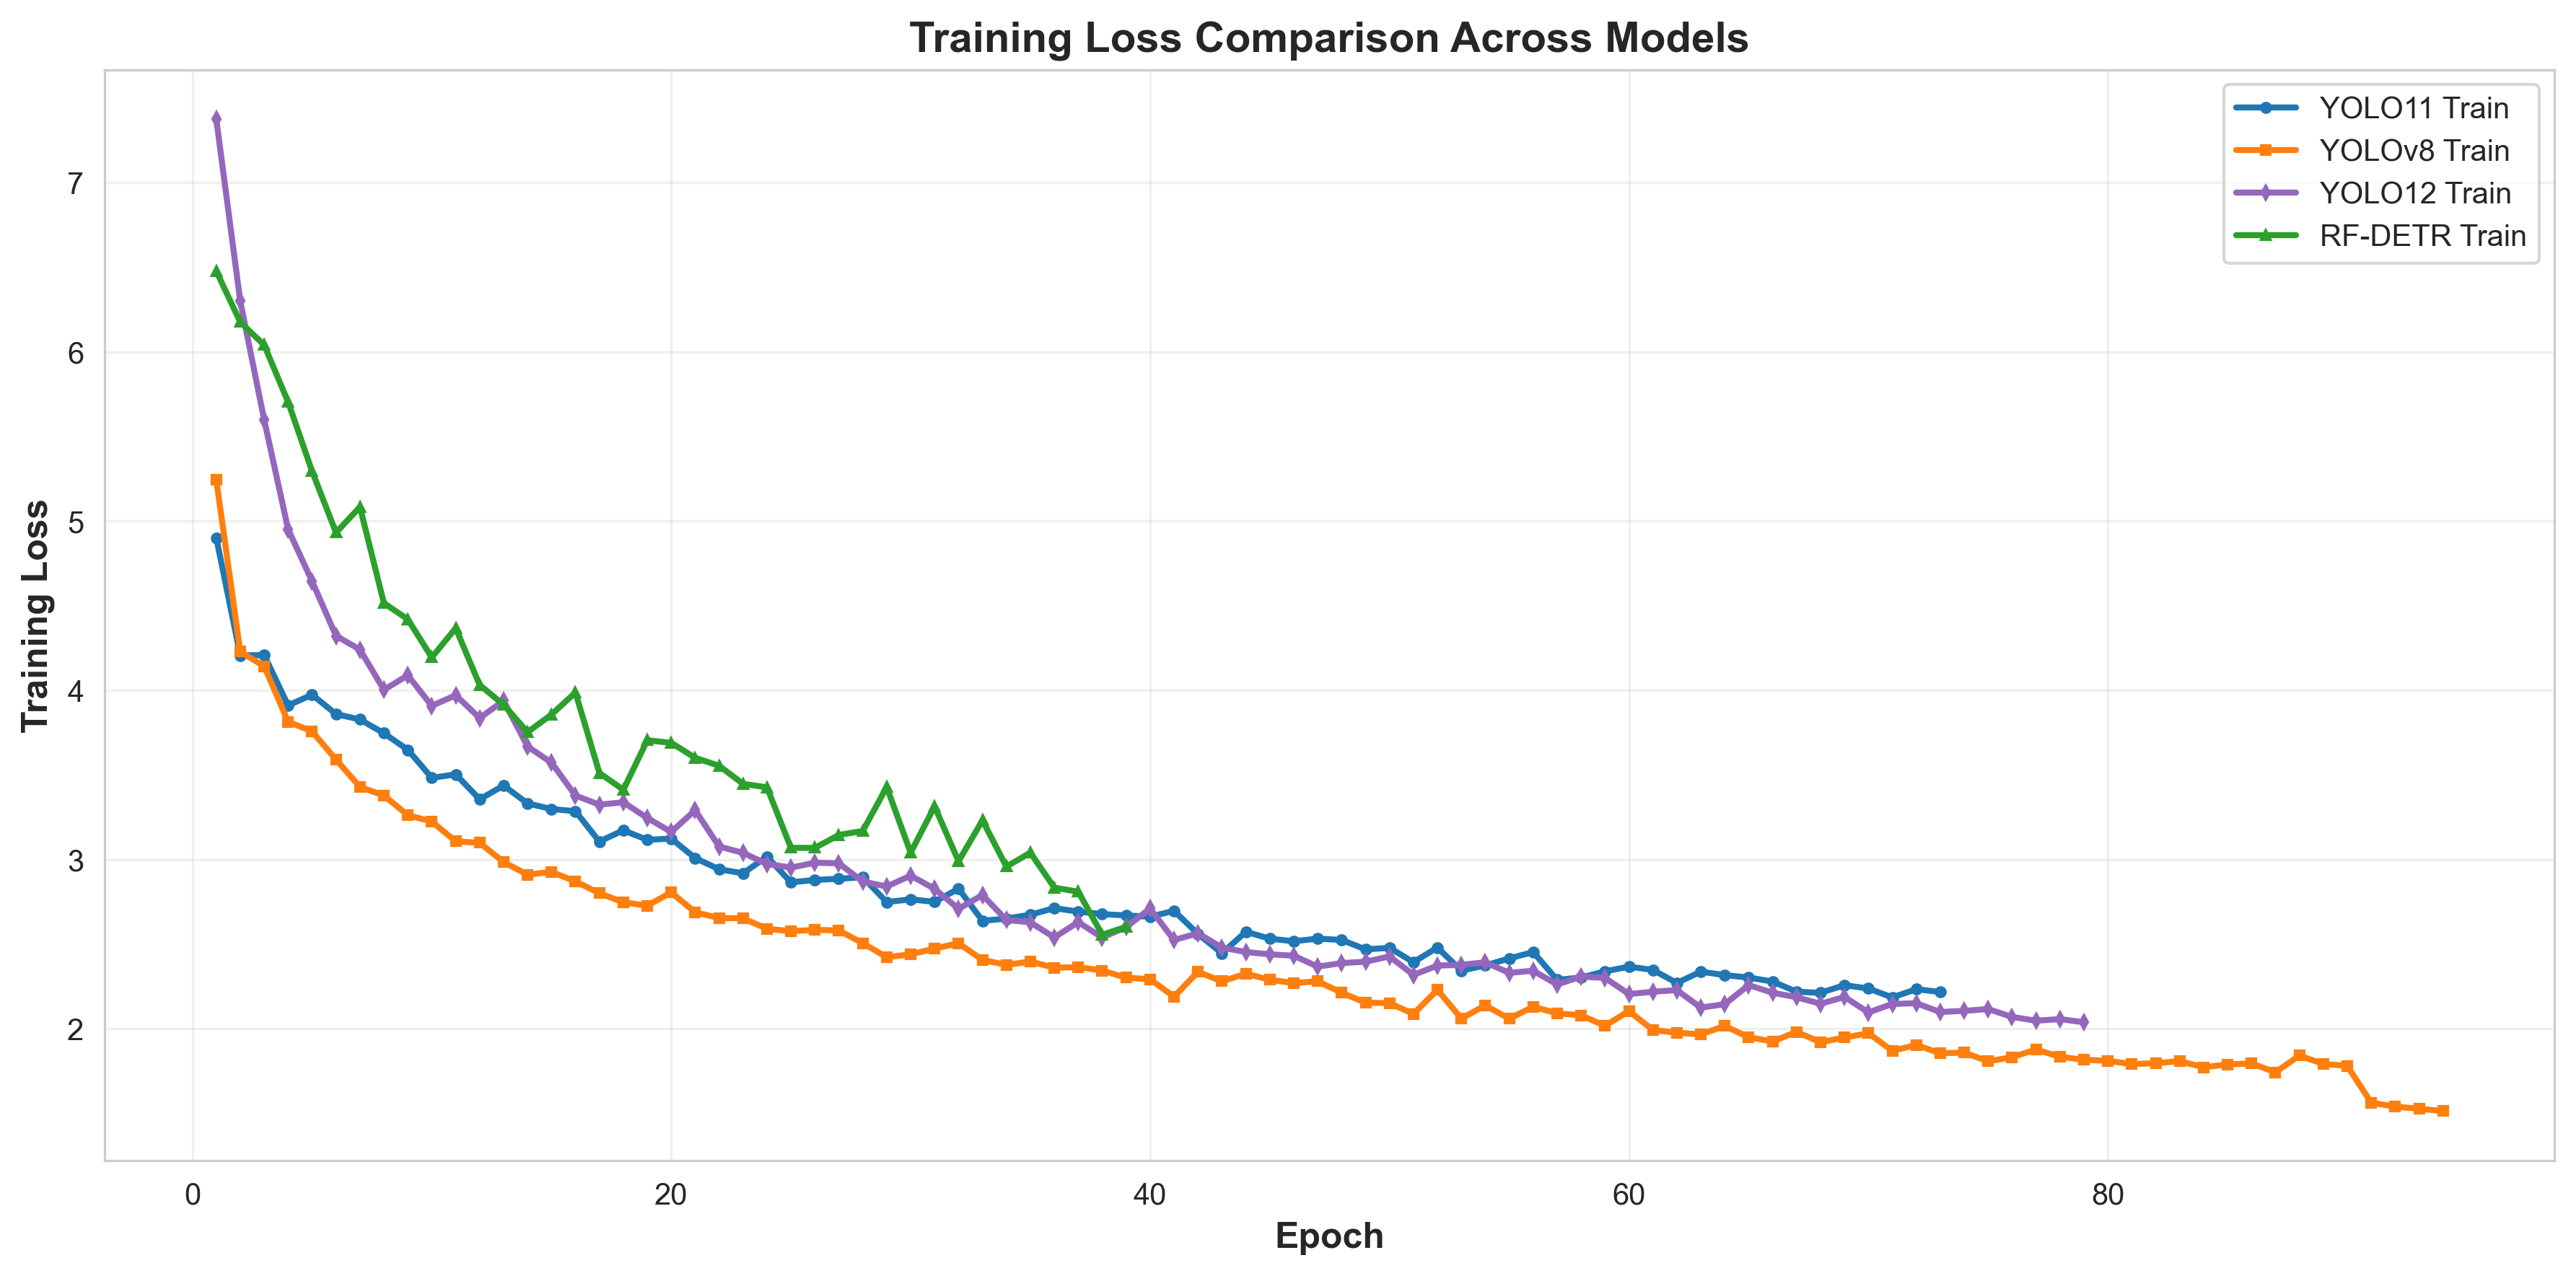

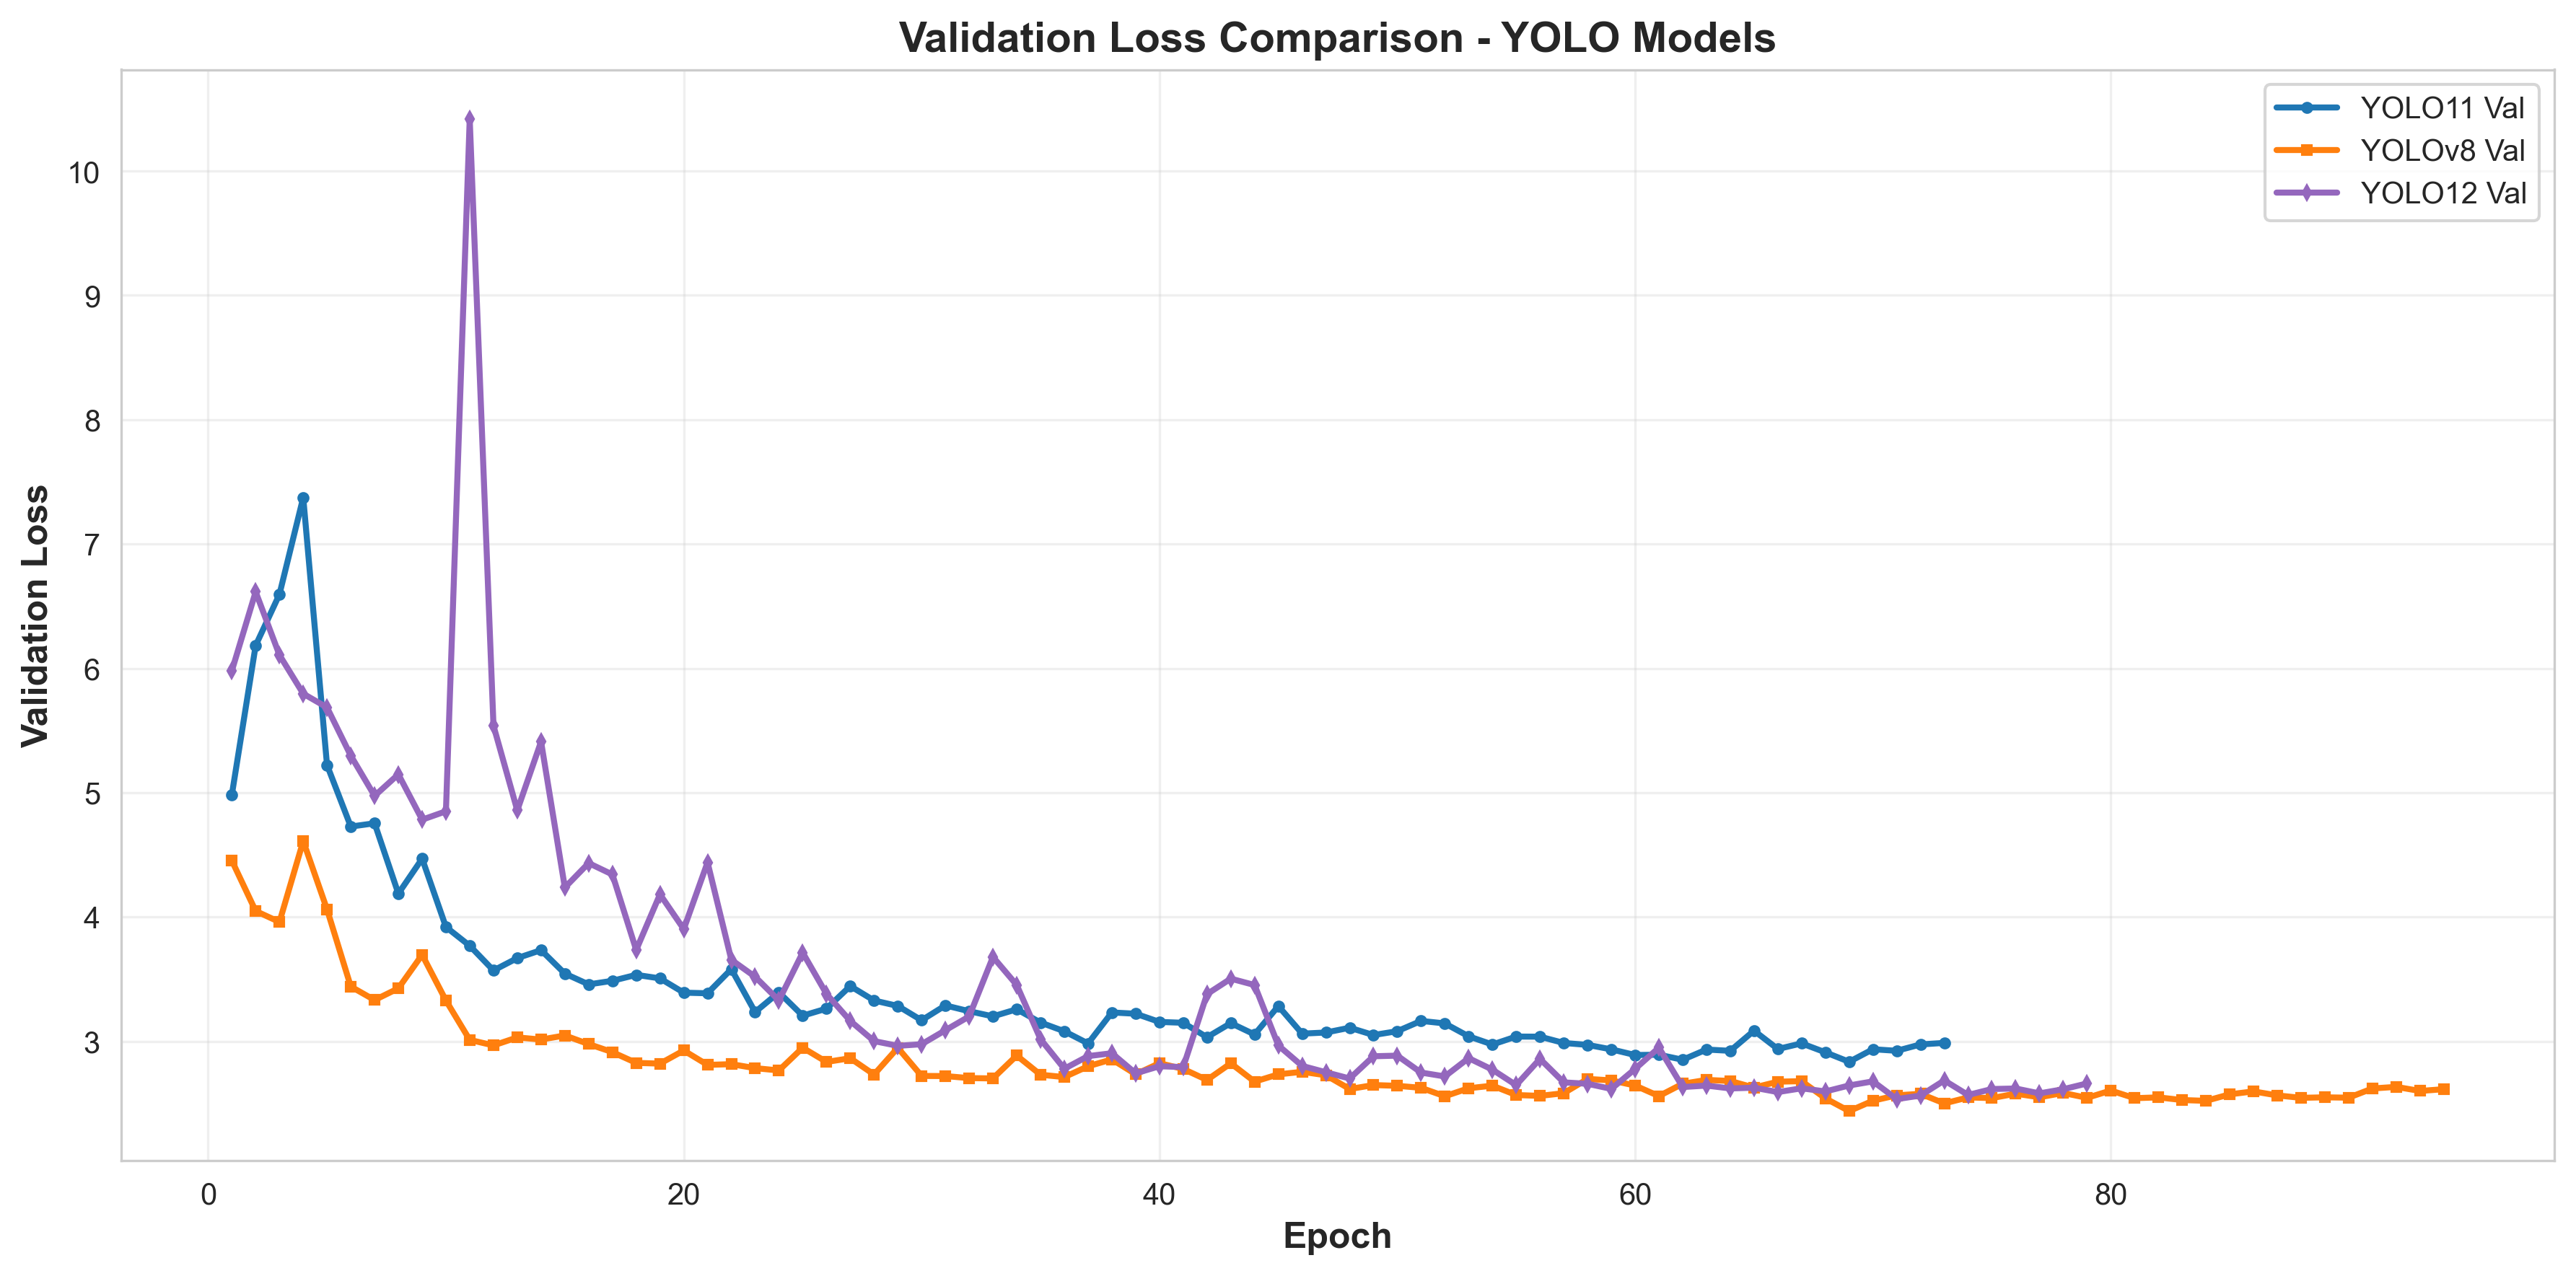

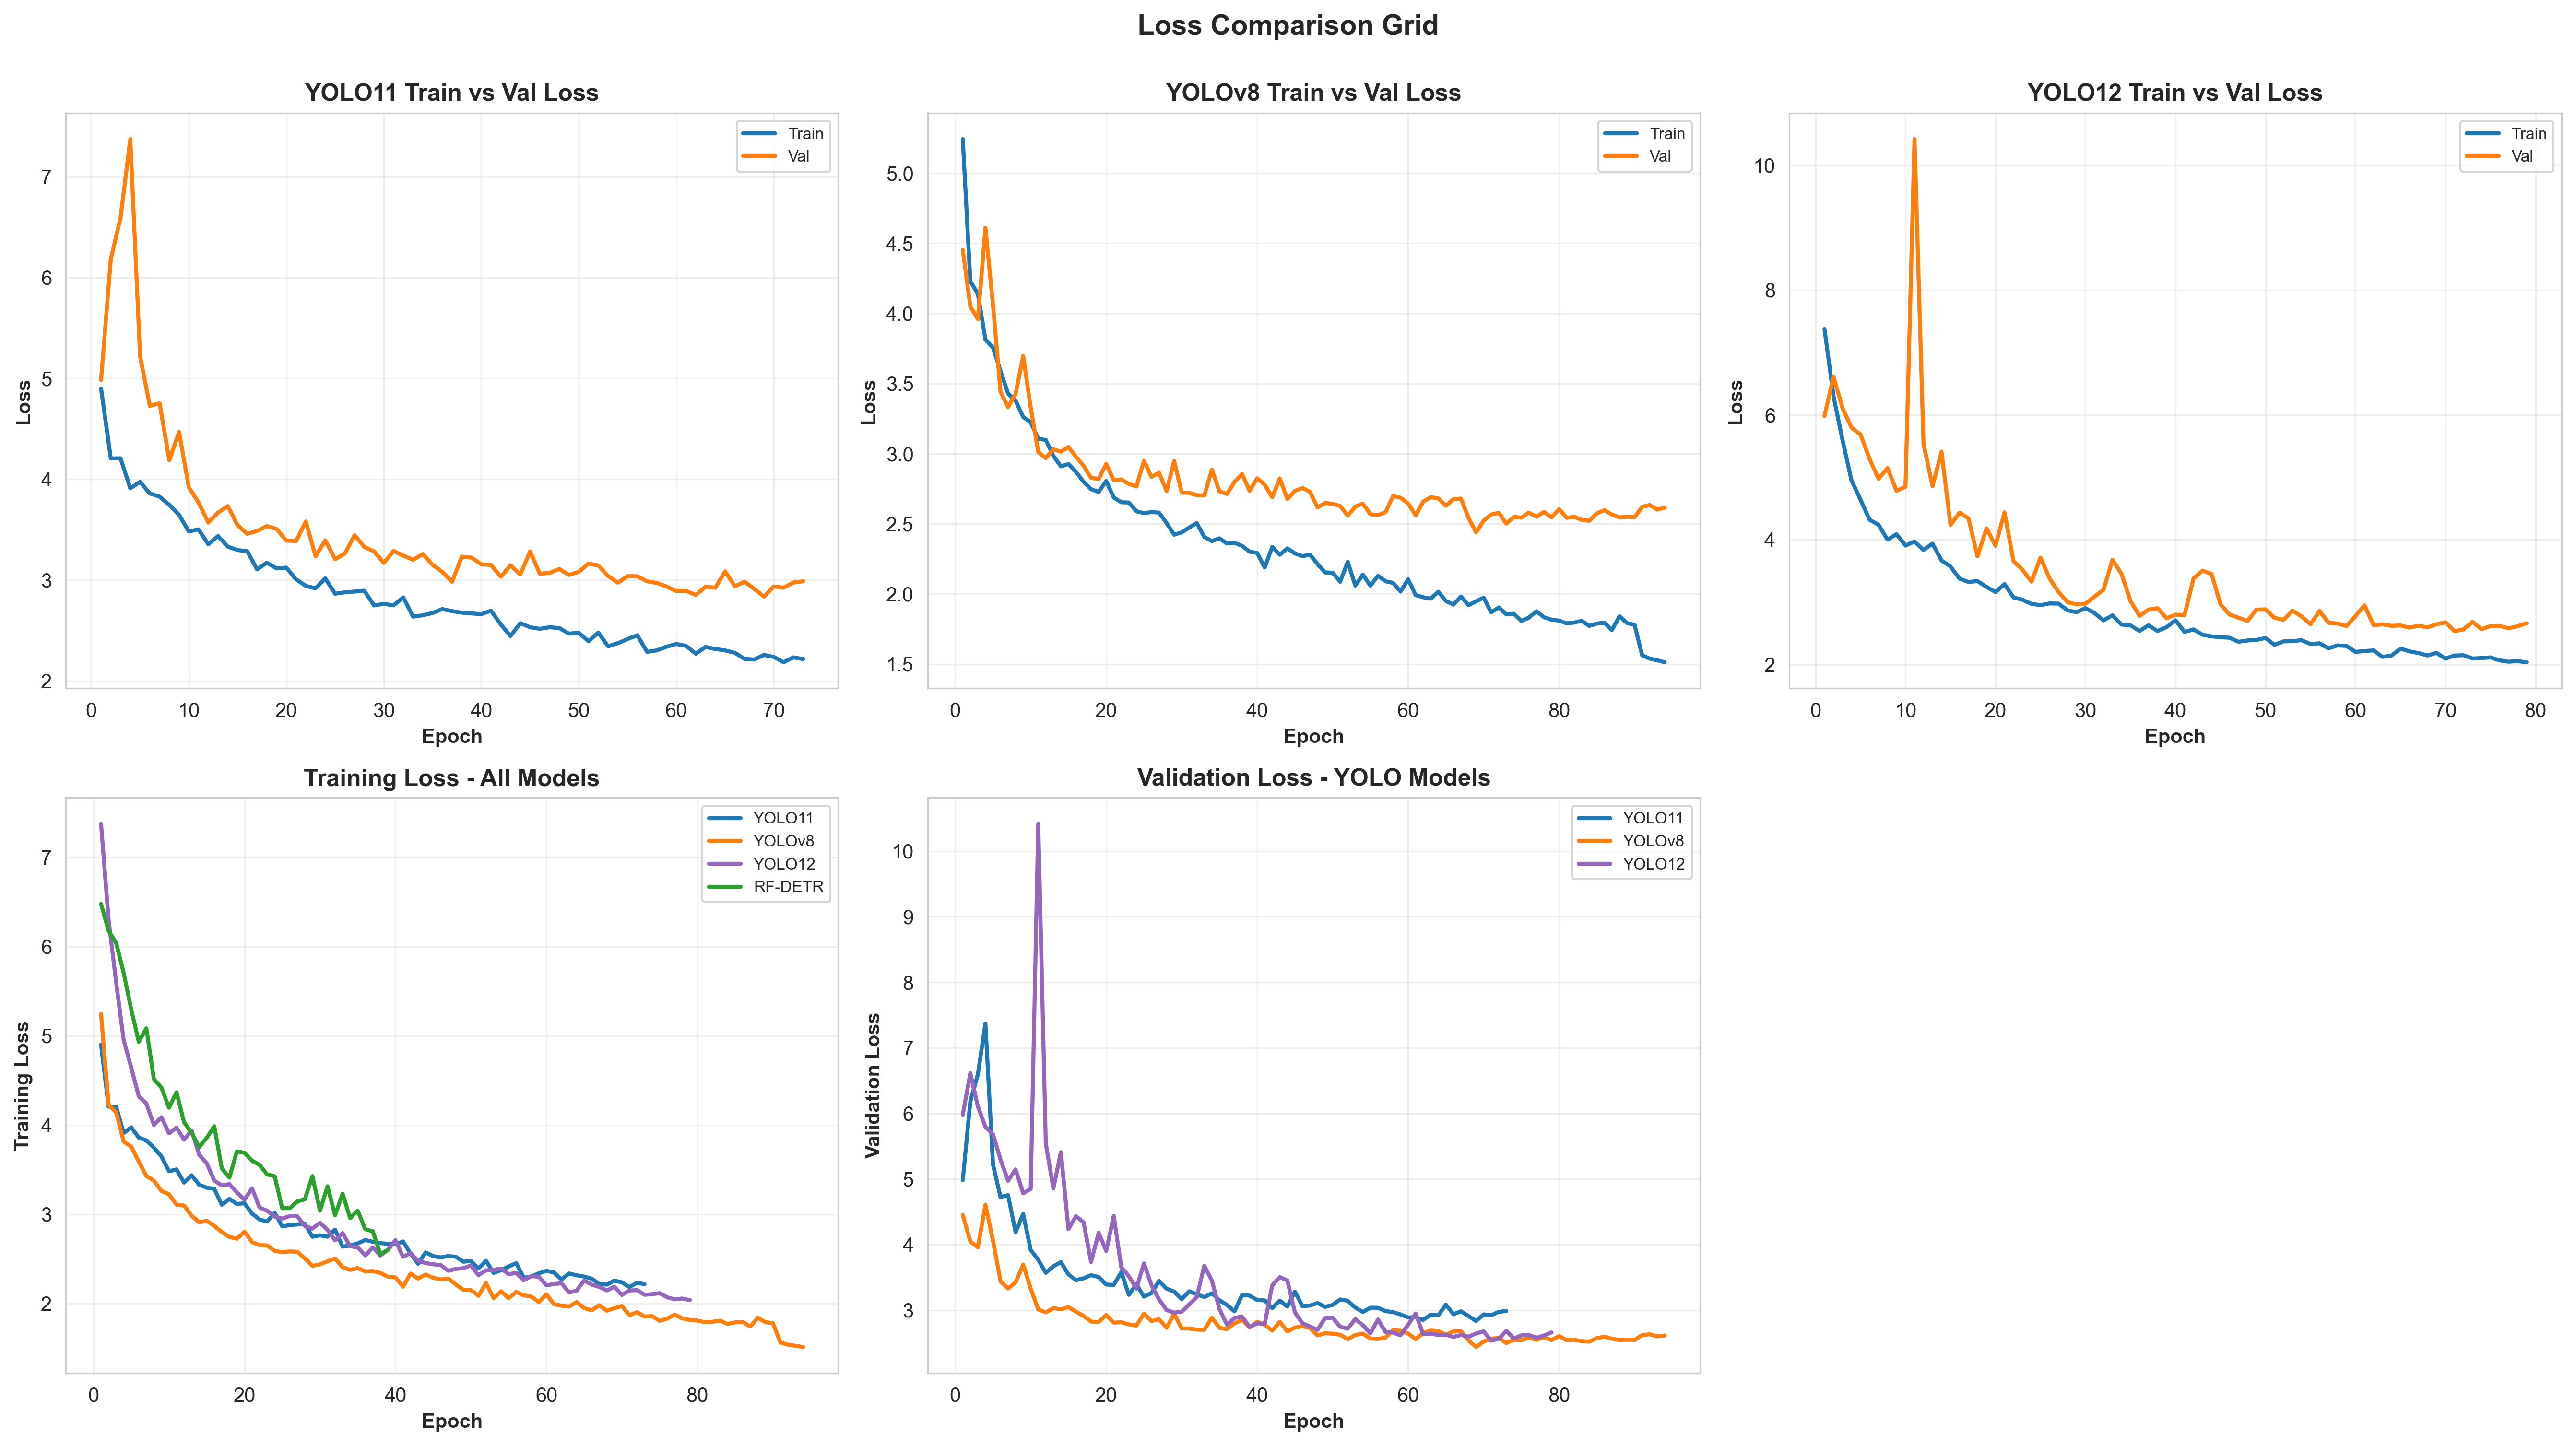

In [3]:
# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 300

# Load YOLO models data
yolo11_df = pd.read_csv('results.csv')
yolov8_df = pd.read_csv('results_YOLOv8.csv')
yolo12_df = pd.read_csv('results_YOLO12.csv')

# Parse RF-DETR data from the JSON lines format
rfdetr_data = []
rfdetr_log_path = 'log.txt'
try:
    with open(rfdetr_log_path, 'r') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            data = json.loads(line)
            epoch = data['epoch'] + 1
            test_results = data['test_results_json']['class_map']
            all_class = [c for c in test_results if c['class'] == 'all'][0]
            train_loss = data.get('train_loss', None)
            rfdetr_data.append({
                'epoch': epoch,
                'mAP50': all_class['map@50'],
                'mAP50-95': all_class['map@50:95'],
                'precision': all_class['precision'],
                'recall': all_class['recall'],
                'train_loss': train_loss
            })
    print(f"Successfully loaded {len(rfdetr_data)} epochs from file")
except FileNotFoundError:
    print(f"File not found.")

rfdetr_df = pd.DataFrame(rfdetr_data)

# data for comparison
yolo11_comparison = pd.DataFrame({
    'epoch': yolo11_df['epoch'],
    'mAP50': yolo11_df['metrics/mAP50(B)'],
    'mAP50-95': yolo11_df['metrics/mAP50-95(B)'],
    'precision': yolo11_df['metrics/precision(B)'],
    'recall': yolo11_df['metrics/recall(B)']
})

yolov8_comparison = pd.DataFrame({
    'epoch': yolov8_df['epoch'],
    'mAP50': yolov8_df['metrics/mAP50(B)'],
    'mAP50-95': yolov8_df['metrics/mAP50-95(B)'],
    'precision': yolov8_df['metrics/precision(B)'],
    'recall': yolov8_df['metrics/recall(B)']
})

yolo12_comparison = pd.DataFrame({
    'epoch': yolo12_df['epoch'],
    'mAP50': yolo12_df['metrics/mAP50(B)'],
    'mAP50-95': yolo12_df['metrics/mAP50-95(B)'],
    'precision': yolo12_df['metrics/precision(B)'],
    'recall': yolo12_df['metrics/recall(B)']
})

# Define colors
colors = {
    'YOLO11': '#1f77b4',
    'YOLOv8': '#ff7f0e',
    'YOLO12': '#9467bd',
    'RF-DETR': '#2ca02c'
}

# Individual metric comparisons
metrics = ['mAP50', 'mAP50-95', 'precision', 'recall']
metric_labels = {
    'mAP50': 'mAP@50',
    'mAP50-95': 'mAP@50-95',
    'precision': 'Precision',
    'recall': 'Recall'
}

for metric in metrics:
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(yolo11_comparison['epoch'], yolo11_comparison[metric], label='YOLO11', color=colors['YOLO11'], linewidth=2, marker='o', markersize=3)
    ax.plot(yolov8_comparison['epoch'], yolov8_comparison[metric], label='YOLOv8', color=colors['YOLOv8'], linewidth=2, marker='s', markersize=3)
    ax.plot(yolo12_comparison['epoch'], yolo12_comparison[metric], label='YOLO12', color=colors['YOLO12'], linewidth=2, marker='d', markersize=3)
    ax.plot(rfdetr_df['epoch'], rfdetr_df[metric], label='RF-DETR', color=colors['RF-DETR'], linewidth=2, marker='^', markersize=3)
    ax.set_xlabel('Epoch', fontsize=12, fontweight='bold')
    ax.set_ylabel(metric_labels[metric], fontsize=12, fontweight='bold')
    ax.set_title(f'{metric_labels[metric]} Comparison Across Models', fontsize=14, fontweight='bold')
    ax.legend(fontsize=10, loc='best')
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Combined metrics grid (2x2)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, metric in enumerate(metrics):
    ax = axes[idx]
    ax.plot(yolo11_comparison['epoch'], yolo11_comparison[metric], label='YOLO11', color=colors['YOLO11'], linewidth=2, marker='o', markersize=2)
    ax.plot(yolov8_comparison['epoch'], yolov8_comparison[metric], label='YOLOv8', color=colors['YOLOv8'], linewidth=2, marker='s', markersize=2)
    ax.plot(yolo12_comparison['epoch'], yolo12_comparison[metric], label='YOLO12', color=colors['YOLO12'], linewidth=2, marker='d', markersize=2)
    ax.plot(rfdetr_df['epoch'], rfdetr_df[metric], label='RF-DETR', color=colors['RF-DETR'], linewidth=2, marker='^', markersize=2)
    ax.set_xlabel('Epoch', fontsize=10, fontweight='bold')
    ax.set_ylabel(metric_labels[metric], fontsize=10, fontweight='bold')
    ax.set_title(metric_labels[metric], fontsize=12, fontweight='bold')
    ax.legend(fontsize=8, loc='best')
    ax.grid(True, alpha=0.3)

plt.suptitle('Model Performance Comparison - All Metrics', fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

# Final epoch performance comparison (bar chart)
final_yolo11 = yolo11_comparison.iloc[-1]
final_yolov8 = yolov8_comparison.iloc[-1]
final_yolo12 = yolo12_comparison.iloc[-1]
final_rfdetr = rfdetr_df.iloc[-1]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, metric in enumerate(metrics):
    ax = axes[idx]
    models = ['YOLO11', 'YOLOv8', 'YOLO12', 'RF-DETR']
    values = [final_yolo11[metric], final_yolov8[metric], final_yolo12[metric], final_rfdetr[metric]]
    bar_colors = [colors[m] for m in models]
    bars = ax.bar(models, values, color=bar_colors, alpha=0.7, edgecolor='black', linewidth=1.5)
    
    for bar, val in zip(bars, values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height, f'{val:.4f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    ax.set_ylabel(metric_labels[metric], fontsize=10, fontweight='bold')
    ax.set_title(f'Final {metric_labels[metric]}', fontsize=12, fontweight='bold')
    ax.set_ylim(0, max(values) * 1.15)
    ax.grid(True, alpha=0.3, axis='y')

plt.suptitle('Final Epoch Performance Comparison', fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

# Best performance comparison (bar chart)
best_yolo11 = yolo11_comparison.loc[yolo11_comparison['mAP50-95'].idxmax()]
best_yolov8 = yolov8_comparison.loc[yolov8_comparison['mAP50-95'].idxmax()]
best_yolo12 = yolo12_comparison.loc[yolo12_comparison['mAP50-95'].idxmax()]
best_rfdetr = rfdetr_df.loc[rfdetr_df['mAP50-95'].idxmax()]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, metric in enumerate(metrics):
    ax = axes[idx]
    models = ['YOLO11', 'YOLOv8', 'YOLO12', 'RF-DETR']
    values = [best_yolo11[metric], best_yolov8[metric], best_yolo12[metric], best_rfdetr[metric]]
    bar_colors = [colors[m] for m in models]
    bars = ax.bar(models, values, color=bar_colors, alpha=0.7, edgecolor='black', linewidth=1.5)
    
    for bar, val in zip(bars, values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height, f'{val:.4f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    ax.set_ylabel(metric_labels[metric], fontsize=10, fontweight='bold')
    ax.set_title(f'Best {metric_labels[metric]}', fontsize=12, fontweight='bold')
    ax.set_ylim(0, max(values) * 1.15)
    ax.grid(True, alpha=0.3, axis='y')

plt.suptitle('Best Performance Comparison (Based on mAP@50-95)', fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

# total losses for YOLO models
yolo11_train_loss = (yolo11_df['train/box_loss'] + yolo11_df['train/cls_loss'] + yolo11_df['train/dfl_loss'])
yolo11_val_loss = (yolo11_df['val/box_loss'] + yolo11_df['val/cls_loss'] + yolo11_df['val/dfl_loss'])

yolov8_train_loss = (yolov8_df['train/box_loss'] + yolov8_df['train/cls_loss'] + yolov8_df['train/dfl_loss'])
yolov8_val_loss = (yolov8_df['val/box_loss'] + yolov8_df['val/cls_loss'] + yolov8_df['val/dfl_loss'])

yolo12_train_loss = (yolo12_df['train/box_loss'] + yolo12_df['train/cls_loss'] + yolo12_df['train/dfl_loss'])
yolo12_val_loss = (yolo12_df['val/box_loss'] + yolo12_df['val/cls_loss'] + yolo12_df['val/dfl_loss'])

# YOLO11
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(yolo11_df['epoch'], yolo11_train_loss, label='Train Loss', color='#1f77b4', linewidth=2, marker='o', markersize=3)
ax.plot(yolo11_df['epoch'], yolo11_val_loss, label='Validation Loss', color='#ff7f0e', linewidth=2, marker='s', markersize=3)
ax.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax.set_ylabel('Total Loss', fontsize=12, fontweight='bold')
ax.set_title('YOLO11 - Train vs Validation Loss', fontsize=14, fontweight='bold')
ax.legend(fontsize=10, loc='best')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# YOLOv8
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(yolov8_df['epoch'], yolov8_train_loss, label='Train Loss', color='#1f77b4', linewidth=2, marker='o', markersize=3)
ax.plot(yolov8_df['epoch'], yolov8_val_loss, label='Validation Loss', color='#ff7f0e', linewidth=2, marker='s', markersize=3)
ax.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax.set_ylabel('Total Loss', fontsize=12, fontweight='bold')
ax.set_title('YOLOv8 - Train vs Validation Loss', fontsize=14, fontweight='bold')
ax.legend(fontsize=10, loc='best')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# YOLO12
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(yolo12_df['epoch'], yolo12_train_loss, label='Train Loss', color='#1f77b4', linewidth=2, marker='o', markersize=3)
ax.plot(yolo12_df['epoch'], yolo12_val_loss, label='Validation Loss', color='#ff7f0e', linewidth=2, marker='s', markersize=3)
ax.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax.set_ylabel('Total Loss', fontsize=12, fontweight='bold')
ax.set_title('YOLO12 - Train vs Validation Loss', fontsize=14, fontweight='bold')
ax.legend(fontsize=10, loc='best')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# RF-DETR
if 'train_loss' in rfdetr_df.columns and rfdetr_df['train_loss'].notna().any():
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(rfdetr_df['epoch'], rfdetr_df['train_loss'], label='Train Loss', color='#2ca02c', linewidth=2, marker='^', markersize=3)
    ax.set_xlabel('Epoch', fontsize=12, fontweight='bold')
    ax.set_ylabel('Train Loss', fontsize=12, fontweight='bold')
    ax.set_title('RF-DETR - Training Loss', fontsize=14, fontweight='bold')
    ax.legend(fontsize=10, loc='best')
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Combined comparison - Training loss across all models
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(yolo11_df['epoch'], yolo11_train_loss, label='YOLO11 Train', color=colors['YOLO11'], linewidth=2, marker='o', markersize=3)
ax.plot(yolov8_df['epoch'], yolov8_train_loss, label='YOLOv8 Train', color=colors['YOLOv8'], linewidth=2, marker='s', markersize=3)
ax.plot(yolo12_df['epoch'], yolo12_train_loss, label='YOLO12 Train', color=colors['YOLO12'], linewidth=2, marker='d', markersize=3)
if 'train_loss' in rfdetr_df.columns and rfdetr_df['train_loss'].notna().any():
    ax.plot(rfdetr_df['epoch'], rfdetr_df['train_loss'], label='RF-DETR Train', color=colors['RF-DETR'], linewidth=2, marker='^', markersize=3)
ax.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax.set_ylabel('Training Loss', fontsize=12, fontweight='bold')
ax.set_title('Training Loss Comparison Across Models', fontsize=14, fontweight='bold')
ax.legend(fontsize=10, loc='best')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Combined comparison - Validation loss across YOLO models
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(yolo11_df['epoch'], yolo11_val_loss, label='YOLO11 Val', color=colors['YOLO11'], linewidth=2, marker='o', markersize=3)
ax.plot(yolov8_df['epoch'], yolov8_val_loss, label='YOLOv8 Val', color=colors['YOLOv8'], linewidth=2, marker='s', markersize=3)
ax.plot(yolo12_df['epoch'], yolo12_val_loss, label='YOLO12 Val', color=colors['YOLO12'], linewidth=2, marker='d', markersize=3)
ax.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax.set_ylabel('Validation Loss', fontsize=12, fontweight='bold')
ax.set_title('Validation Loss Comparison - YOLO Models', fontsize=14, fontweight='bold')
ax.legend(fontsize=10, loc='best')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 2x3 Grid showing train and val losses
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# YOLO11 train vs val
ax = axes[0, 0]
ax.plot(yolo11_df['epoch'], yolo11_train_loss, label='Train', color='#1f77b4', linewidth=2)
ax.plot(yolo11_df['epoch'], yolo11_val_loss, label='Val', color='#ff7f0e', linewidth=2)
ax.set_xlabel('Epoch', fontsize=10, fontweight='bold')
ax.set_ylabel('Loss', fontsize=10, fontweight='bold')
ax.set_title('YOLO11 Train vs Val Loss', fontsize=12, fontweight='bold')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

# YOLOv8 train vs val
ax = axes[0, 1]
ax.plot(yolov8_df['epoch'], yolov8_train_loss, label='Train', color='#1f77b4', linewidth=2)
ax.plot(yolov8_df['epoch'], yolov8_val_loss, label='Val', color='#ff7f0e', linewidth=2)
ax.set_xlabel('Epoch', fontsize=10, fontweight='bold')
ax.set_ylabel('Loss', fontsize=10, fontweight='bold')
ax.set_title('YOLOv8 Train vs Val Loss', fontsize=12, fontweight='bold')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

# YOLO12 train vs val
ax = axes[0, 2]
ax.plot(yolo12_df['epoch'], yolo12_train_loss, label='Train', color='#1f77b4', linewidth=2)
ax.plot(yolo12_df['epoch'], yolo12_val_loss, label='Val', color='#ff7f0e', linewidth=2)
ax.set_xlabel('Epoch', fontsize=10, fontweight='bold')
ax.set_ylabel('Loss', fontsize=10, fontweight='bold')
ax.set_title('YOLO12 Train vs Val Loss', fontsize=12, fontweight='bold')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

# Combined training loss comparison
ax = axes[1, 0]
ax.plot(yolo11_df['epoch'], yolo11_train_loss, label='YOLO11', color=colors['YOLO11'], linewidth=2)
ax.plot(yolov8_df['epoch'], yolov8_train_loss, label='YOLOv8', color=colors['YOLOv8'], linewidth=2)
ax.plot(yolo12_df['epoch'], yolo12_train_loss, label='YOLO12', color=colors['YOLO12'], linewidth=2)
if 'train_loss' in rfdetr_df.columns and rfdetr_df['train_loss'].notna().any():
    ax.plot(rfdetr_df['epoch'], rfdetr_df['train_loss'], label='RF-DETR', color=colors['RF-DETR'], linewidth=2)
ax.set_xlabel('Epoch', fontsize=10, fontweight='bold')
ax.set_ylabel('Training Loss', fontsize=10, fontweight='bold')
ax.set_title('Training Loss - All Models', fontsize=12, fontweight='bold')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

# Combined validation loss comparison
ax = axes[1, 1]
ax.plot(yolo11_df['epoch'], yolo11_val_loss, label='YOLO11', color=colors['YOLO11'], linewidth=2)
ax.plot(yolov8_df['epoch'], yolov8_val_loss, label='YOLOv8', color=colors['YOLOv8'], linewidth=2)
ax.plot(yolo12_df['epoch'], yolo12_val_loss, label='YOLO12', color=colors['YOLO12'], linewidth=2)
ax.set_xlabel('Epoch', fontsize=10, fontweight='bold')
ax.set_ylabel('Validation Loss', fontsize=10, fontweight='bold')
ax.set_title('Validation Loss - YOLO Models', fontsize=12, fontweight='bold')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

# Hide the last subplot
axes[1, 2].axis('off')

plt.suptitle('Loss Comparison Grid', fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

In [4]:
report = f"""
Training Summary:
-----------------
YOLO11: {len(yolo11_comparison)} epochs
YOLOv8: {len(yolov8_comparison)} epochs
YOLO12: {len(yolo12_comparison)} epochs
RF-DETR: {len(rfdetr_df)} epochs

Final Epoch Performance:
------------------------
                YOLO11      YOLOv8      YOLO12      RF-DETR     Winner
mAP@50          {final_yolo11['mAP50']:.4f}     {final_yolov8['mAP50']:.4f}     {final_yolo12['mAP50']:.4f}     {final_rfdetr['mAP50']:.4f}     {'YOLO11' if final_yolo11['mAP50'] == max(final_yolo11['mAP50'], final_yolov8['mAP50'], final_yolo12['mAP50'], final_rfdetr['mAP50']) else 'YOLOv8' if final_yolov8['mAP50'] == max(final_yolo11['mAP50'], final_yolov8['mAP50'], final_yolo12['mAP50'], final_rfdetr['mAP50']) else 'YOLO12' if final_yolo12['mAP50'] == max(final_yolo11['mAP50'], final_yolov8['mAP50'], final_yolo12['mAP50'], final_rfdetr['mAP50']) else 'RF-DETR'}
mAP@50-95       {final_yolo11['mAP50-95']:.4f}     {final_yolov8['mAP50-95']:.4f}     {final_yolo12['mAP50-95']:.4f}     {final_rfdetr['mAP50-95']:.4f}     {'YOLO11' if final_yolo11['mAP50-95'] == max(final_yolo11['mAP50-95'], final_yolov8['mAP50-95'], final_yolo12['mAP50-95'], final_rfdetr['mAP50-95']) else 'YOLOv8' if final_yolov8['mAP50-95'] == max(final_yolo11['mAP50-95'], final_yolov8['mAP50-95'], final_yolo12['mAP50-95'], final_rfdetr['mAP50-95']) else 'YOLO12' if final_yolo12['mAP50-95'] == max(final_yolo11['mAP50-95'], final_yolov8['mAP50-95'], final_yolo12['mAP50-95'], final_rfdetr['mAP50-95']) else 'RF-DETR'}
Precision       {final_yolo11['precision']:.4f}     {final_yolov8['precision']:.4f}     {final_yolo12['precision']:.4f}     {final_rfdetr['precision']:.4f}     {'YOLO11' if final_yolo11['precision'] == max(final_yolo11['precision'], final_yolov8['precision'], final_yolo12['precision'], final_rfdetr['precision']) else 'YOLOv8' if final_yolov8['precision'] == max(final_yolo11['precision'], final_yolov8['precision'], final_yolo12['precision'], final_rfdetr['precision']) else 'YOLO12' if final_yolo12['precision'] == max(final_yolo11['precision'], final_yolov8['precision'], final_yolo12['precision'], final_rfdetr['precision']) else 'RF-DETR'}
Recall          {final_yolo11['recall']:.4f}     {final_yolov8['recall']:.4f}     {final_yolo12['recall']:.4f}     {final_rfdetr['recall']:.4f}     {'YOLO11' if final_yolo11['recall'] == max(final_yolo11['recall'], final_yolov8['recall'], final_yolo12['recall'], final_rfdetr['recall']) else 'YOLOv8' if final_yolov8['recall'] == max(final_yolo11['recall'], final_yolov8['recall'], final_yolo12['recall'], final_rfdetr['recall']) else 'YOLO12' if final_yolo12['recall'] == max(final_yolo11['recall'], final_yolov8['recall'], final_yolo12['recall'], final_rfdetr['recall']) else 'RF-DETR'}

Best Performance (Based on mAP@50-95):
---------------------------------------
                YOLO11      YOLOv8      YOLO12      RF-DETR     Winner
                (Epoch {int(best_yolo11['epoch'])})  (Epoch {int(best_yolov8['epoch'])})  (Epoch {int(best_yolo12['epoch'])})  (Epoch {int(best_rfdetr['epoch'])})
mAP@50          {best_yolo11['mAP50']:.4f}     {best_yolov8['mAP50']:.4f}     {best_yolo12['mAP50']:.4f}     {best_rfdetr['mAP50']:.4f}     {'YOLO11' if best_yolo11['mAP50'] == max(best_yolo11['mAP50'], best_yolov8['mAP50'], best_yolo12['mAP50'], best_rfdetr['mAP50']) else 'YOLOv8' if best_yolov8['mAP50'] == max(best_yolo11['mAP50'], best_yolov8['mAP50'], best_yolo12['mAP50'], best_rfdetr['mAP50']) else 'YOLO12' if best_yolo12['mAP50'] == max(best_yolo11['mAP50'], best_yolov8['mAP50'], best_yolo12['mAP50'], best_rfdetr['mAP50']) else 'RF-DETR'}
mAP@50-95       {best_yolo11['mAP50-95']:.4f}     {best_yolov8['mAP50-95']:.4f}     {best_yolo12['mAP50-95']:.4f}     {best_rfdetr['mAP50-95']:.4f}     {'YOLO11' if best_yolo11['mAP50-95'] == max(best_yolo11['mAP50-95'], best_yolov8['mAP50-95'], best_yolo12['mAP50-95'], best_rfdetr['mAP50-95']) else 'YOLOv8' if best_yolov8['mAP50-95'] == max(best_yolo11['mAP50-95'], best_yolov8['mAP50-95'], best_yolo12['mAP50-95'], best_rfdetr['mAP50-95']) else 'YOLO12' if best_yolo12['mAP50-95'] == max(best_yolo11['mAP50-95'], best_yolov8['mAP50-95'], best_yolo12['mAP50-95'], best_rfdetr['mAP50-95']) else 'RF-DETR'}
Precision       {best_yolo11['precision']:.4f}     {best_yolov8['precision']:.4f}     {best_yolo12['precision']:.4f}     {best_rfdetr['precision']:.4f}     {'YOLO11' if best_yolo11['precision'] == max(best_yolo11['precision'], best_yolov8['precision'], best_yolo12['precision'], best_rfdetr['precision']) else 'YOLOv8' if best_yolov8['precision'] == max(best_yolo11['precision'], best_yolov8['precision'], best_yolo12['precision'], best_rfdetr['precision']) else 'YOLO12' if best_yolo12['precision'] == max(best_yolo11['precision'], best_yolov8['precision'], best_yolo12['precision'], best_rfdetr['precision']) else 'RF-DETR'}
Recall          {best_yolo11['recall']:.4f}     {best_yolov8['recall']:.4f}     {best_yolo12['recall']:.4f}     {best_rfdetr['recall']:.4f}     {'YOLO11' if best_yolo11['recall'] == max(best_yolo11['recall'], best_yolov8['recall'], best_yolo12['recall'], best_rfdetr['recall']) else 'YOLOv8' if best_yolov8['recall'] == max(best_yolo11['recall'], best_yolov8['recall'], best_yolo12['recall'], best_rfdetr['recall']) else 'YOLO12' if best_yolo12['recall'] == max(best_yolo11['recall'], best_yolov8['recall'], best_yolo12['recall'], best_rfdetr['recall']) else 'RF-DETR'}
"""

print("\n" + report)



Training Summary:
-----------------
YOLO11: 73 epochs
YOLOv8: 94 epochs
YOLO12: 79 epochs
RF-DETR: 39 epochs

Final Epoch Performance:
------------------------
                YOLO11      YOLOv8      YOLO12      RF-DETR     Winner
mAP@50          0.7994     0.7824     0.7977     0.7483     YOLO11
mAP@50-95       0.5817     0.6161     0.5940     0.5421     YOLOv8
Precision       0.8905     0.8693     0.8925     0.8061     YOLO12
Recall          0.7429     0.7411     0.7783     0.6900     YOLO12

Best Performance (Based on mAP@50-95):
---------------------------------------
                YOLO11      YOLOv8      YOLO12      RF-DETR     Winner
                (Epoch 63)  (Epoch 69)  (Epoch 59)  (Epoch 29)
mAP@50          0.8226     0.8161     0.8019     0.7585     YOLO11
mAP@50-95       0.6210     0.6396     0.6072     0.5521     YOLOv8
Precision       0.8720     0.8845     0.8830     0.8545     YOLOv8
Recall          0.7522     0.7865     0.7487     0.6600     YOLOv8



## Part 2 - Sign Attributes Model Comparison/Analysis

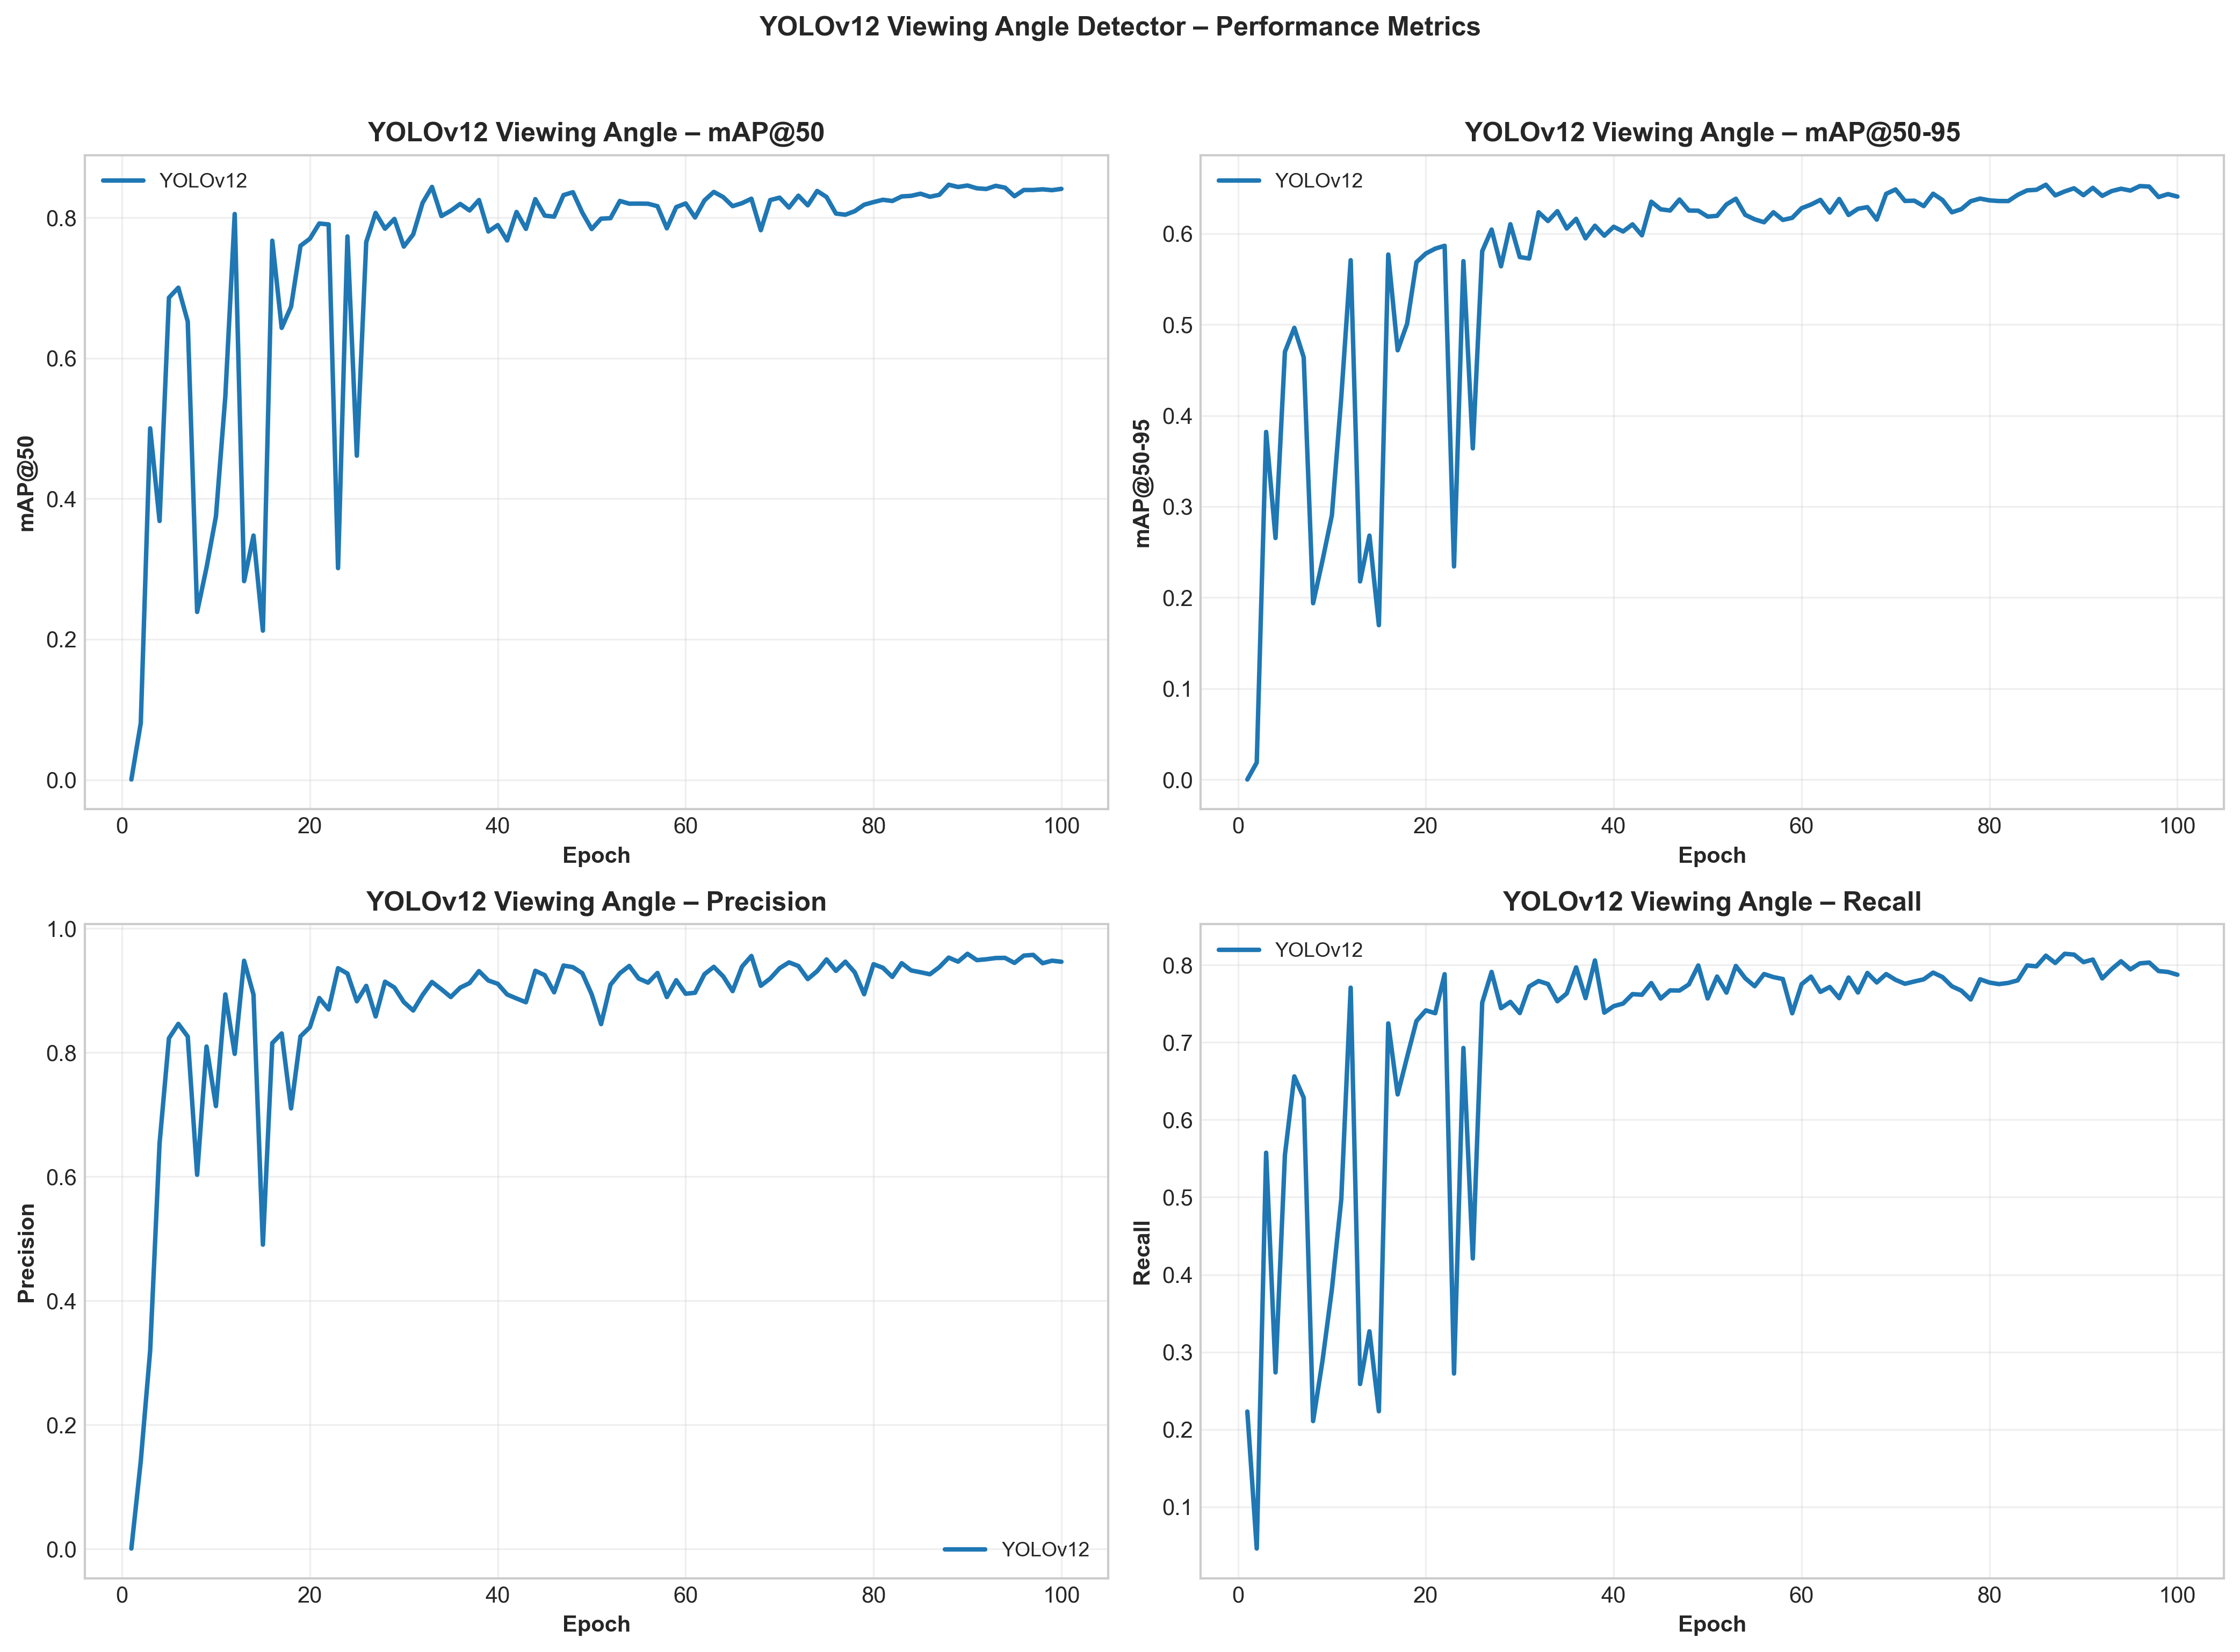

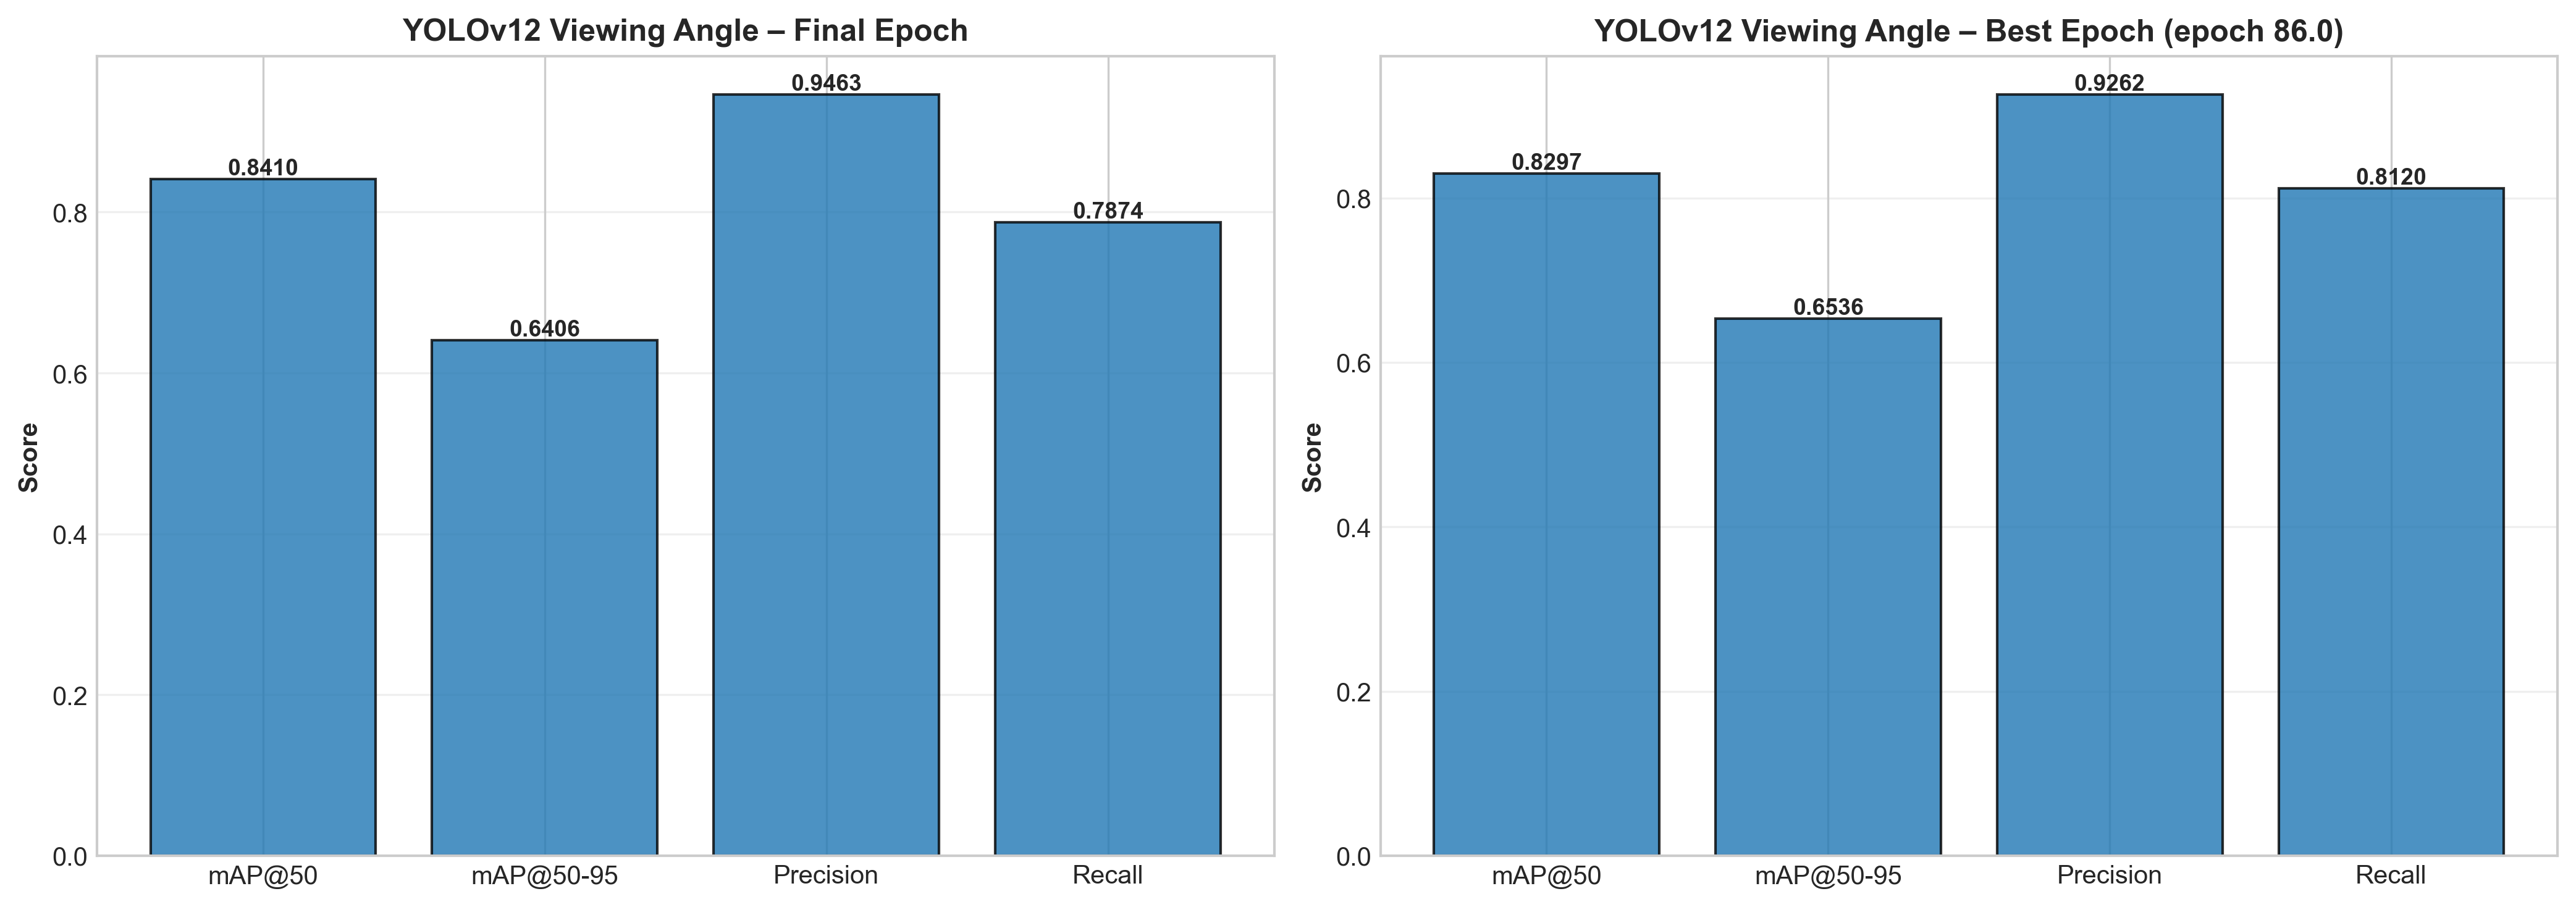

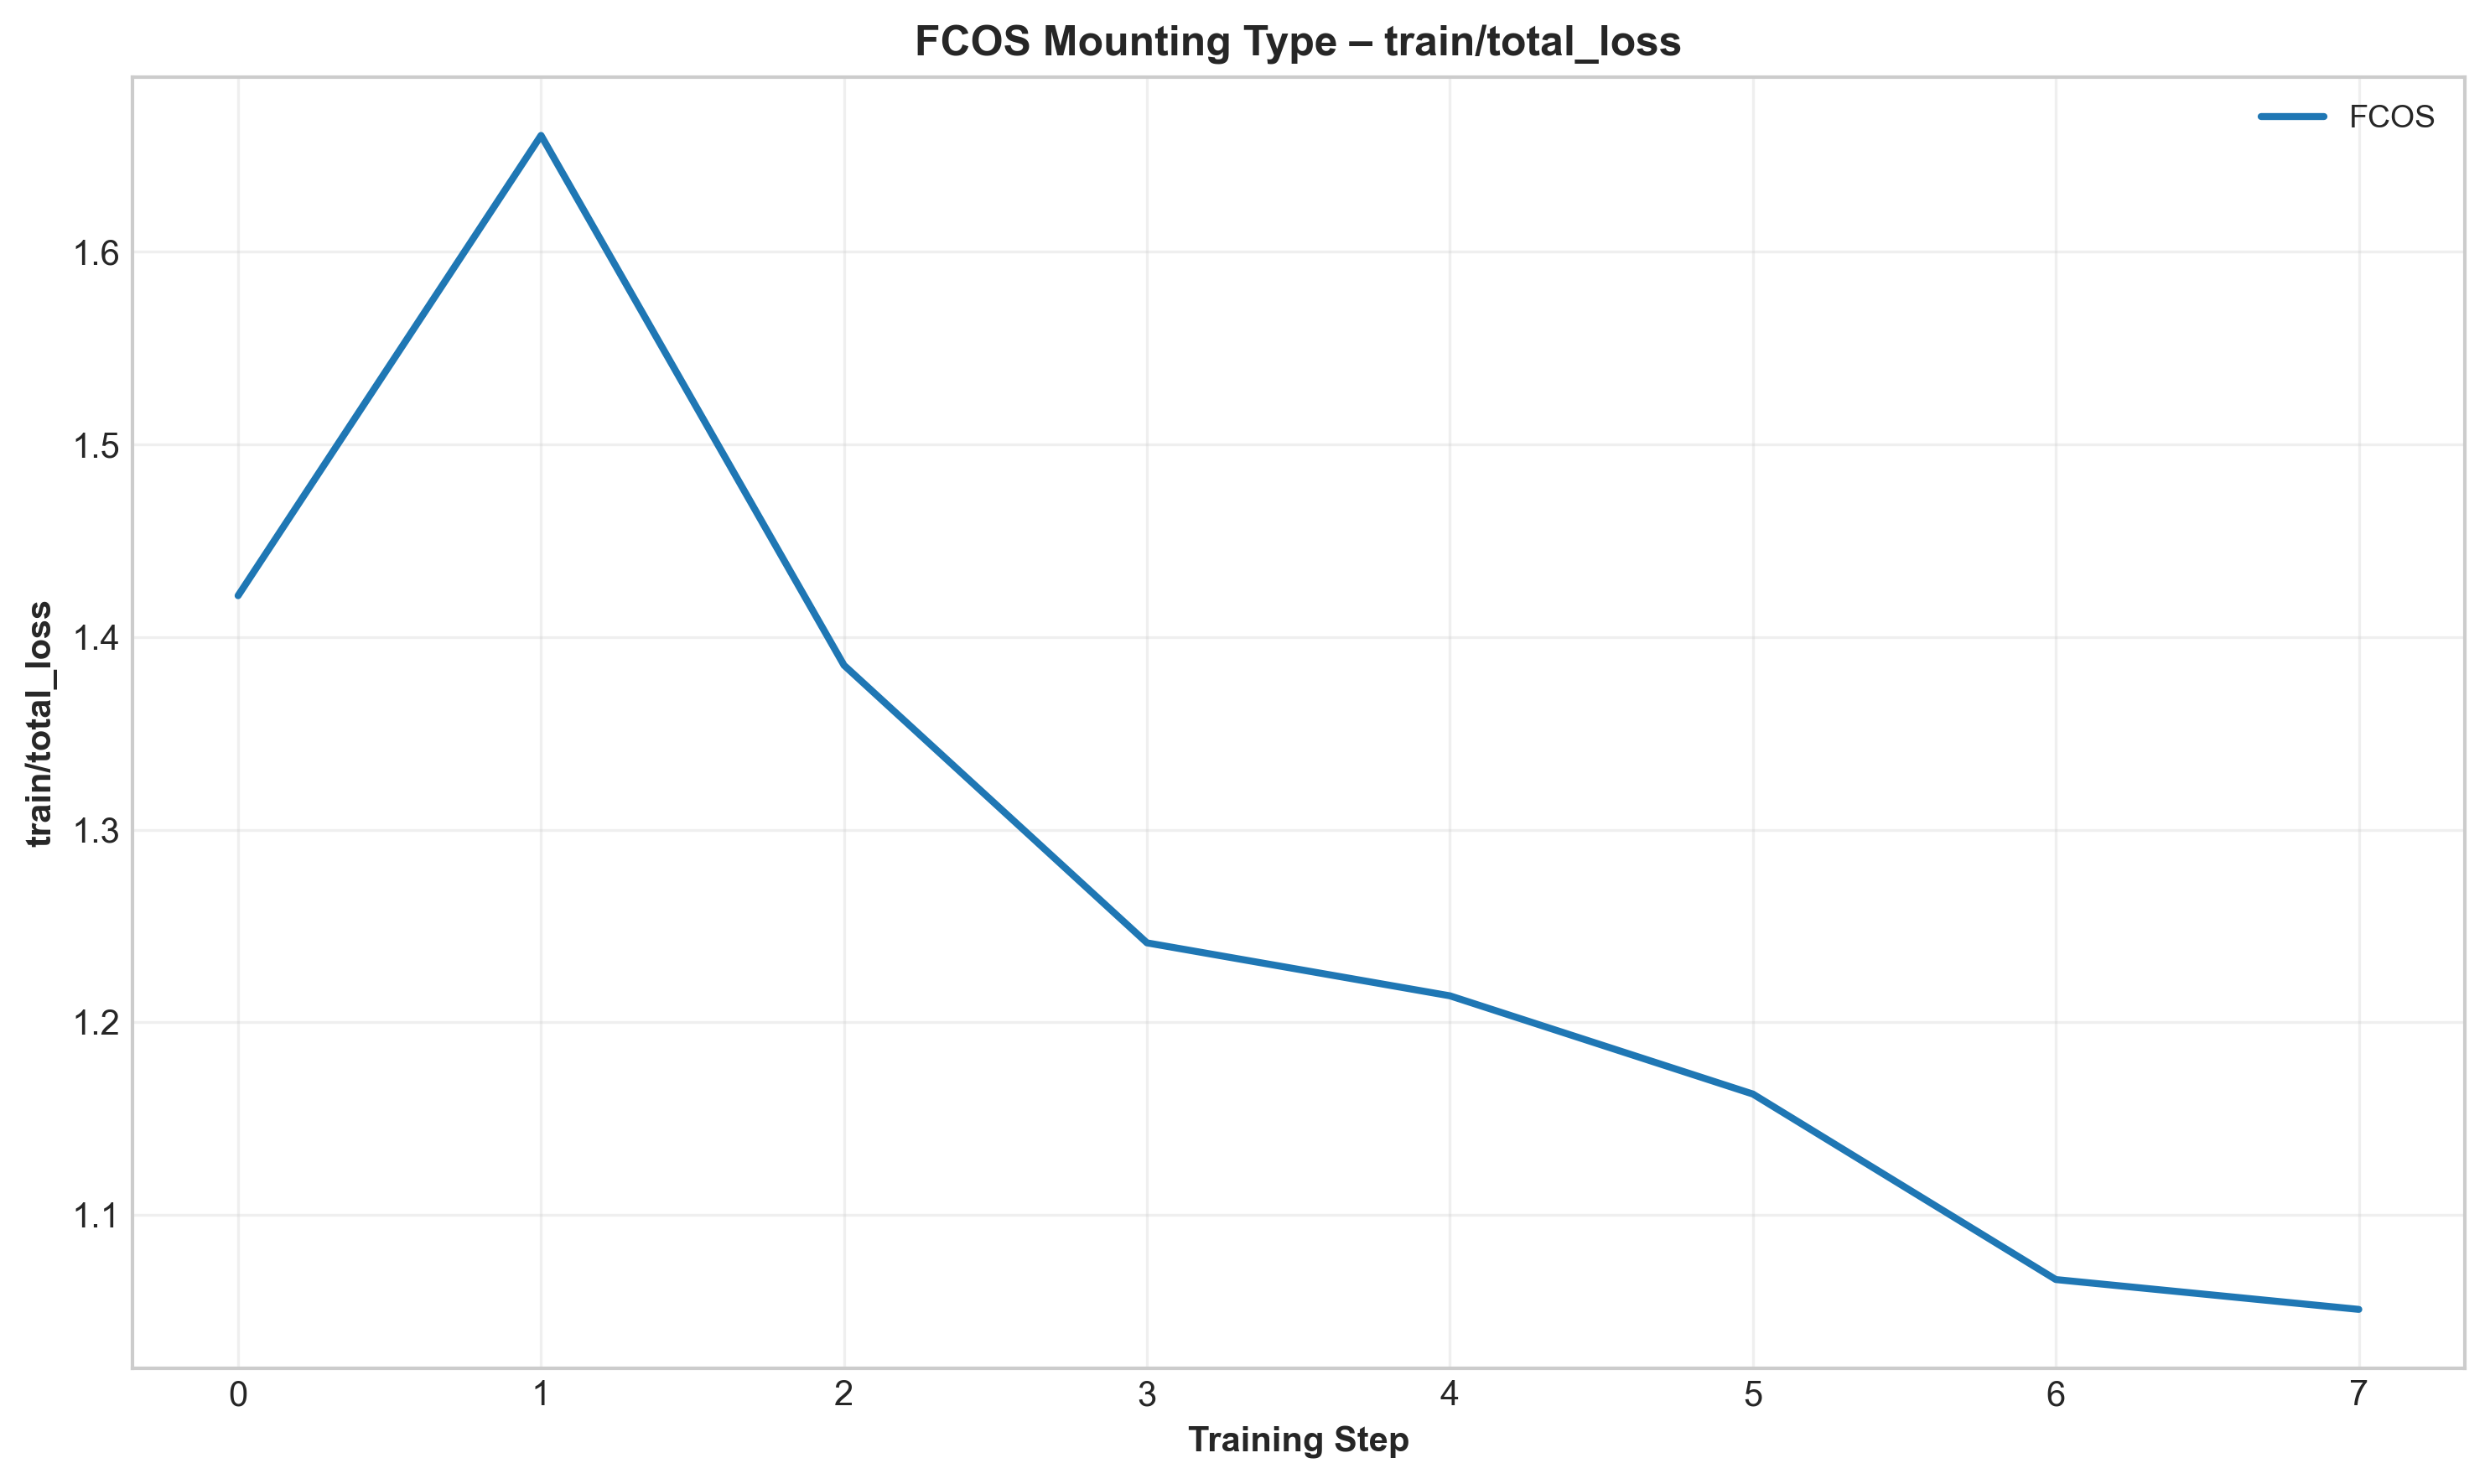

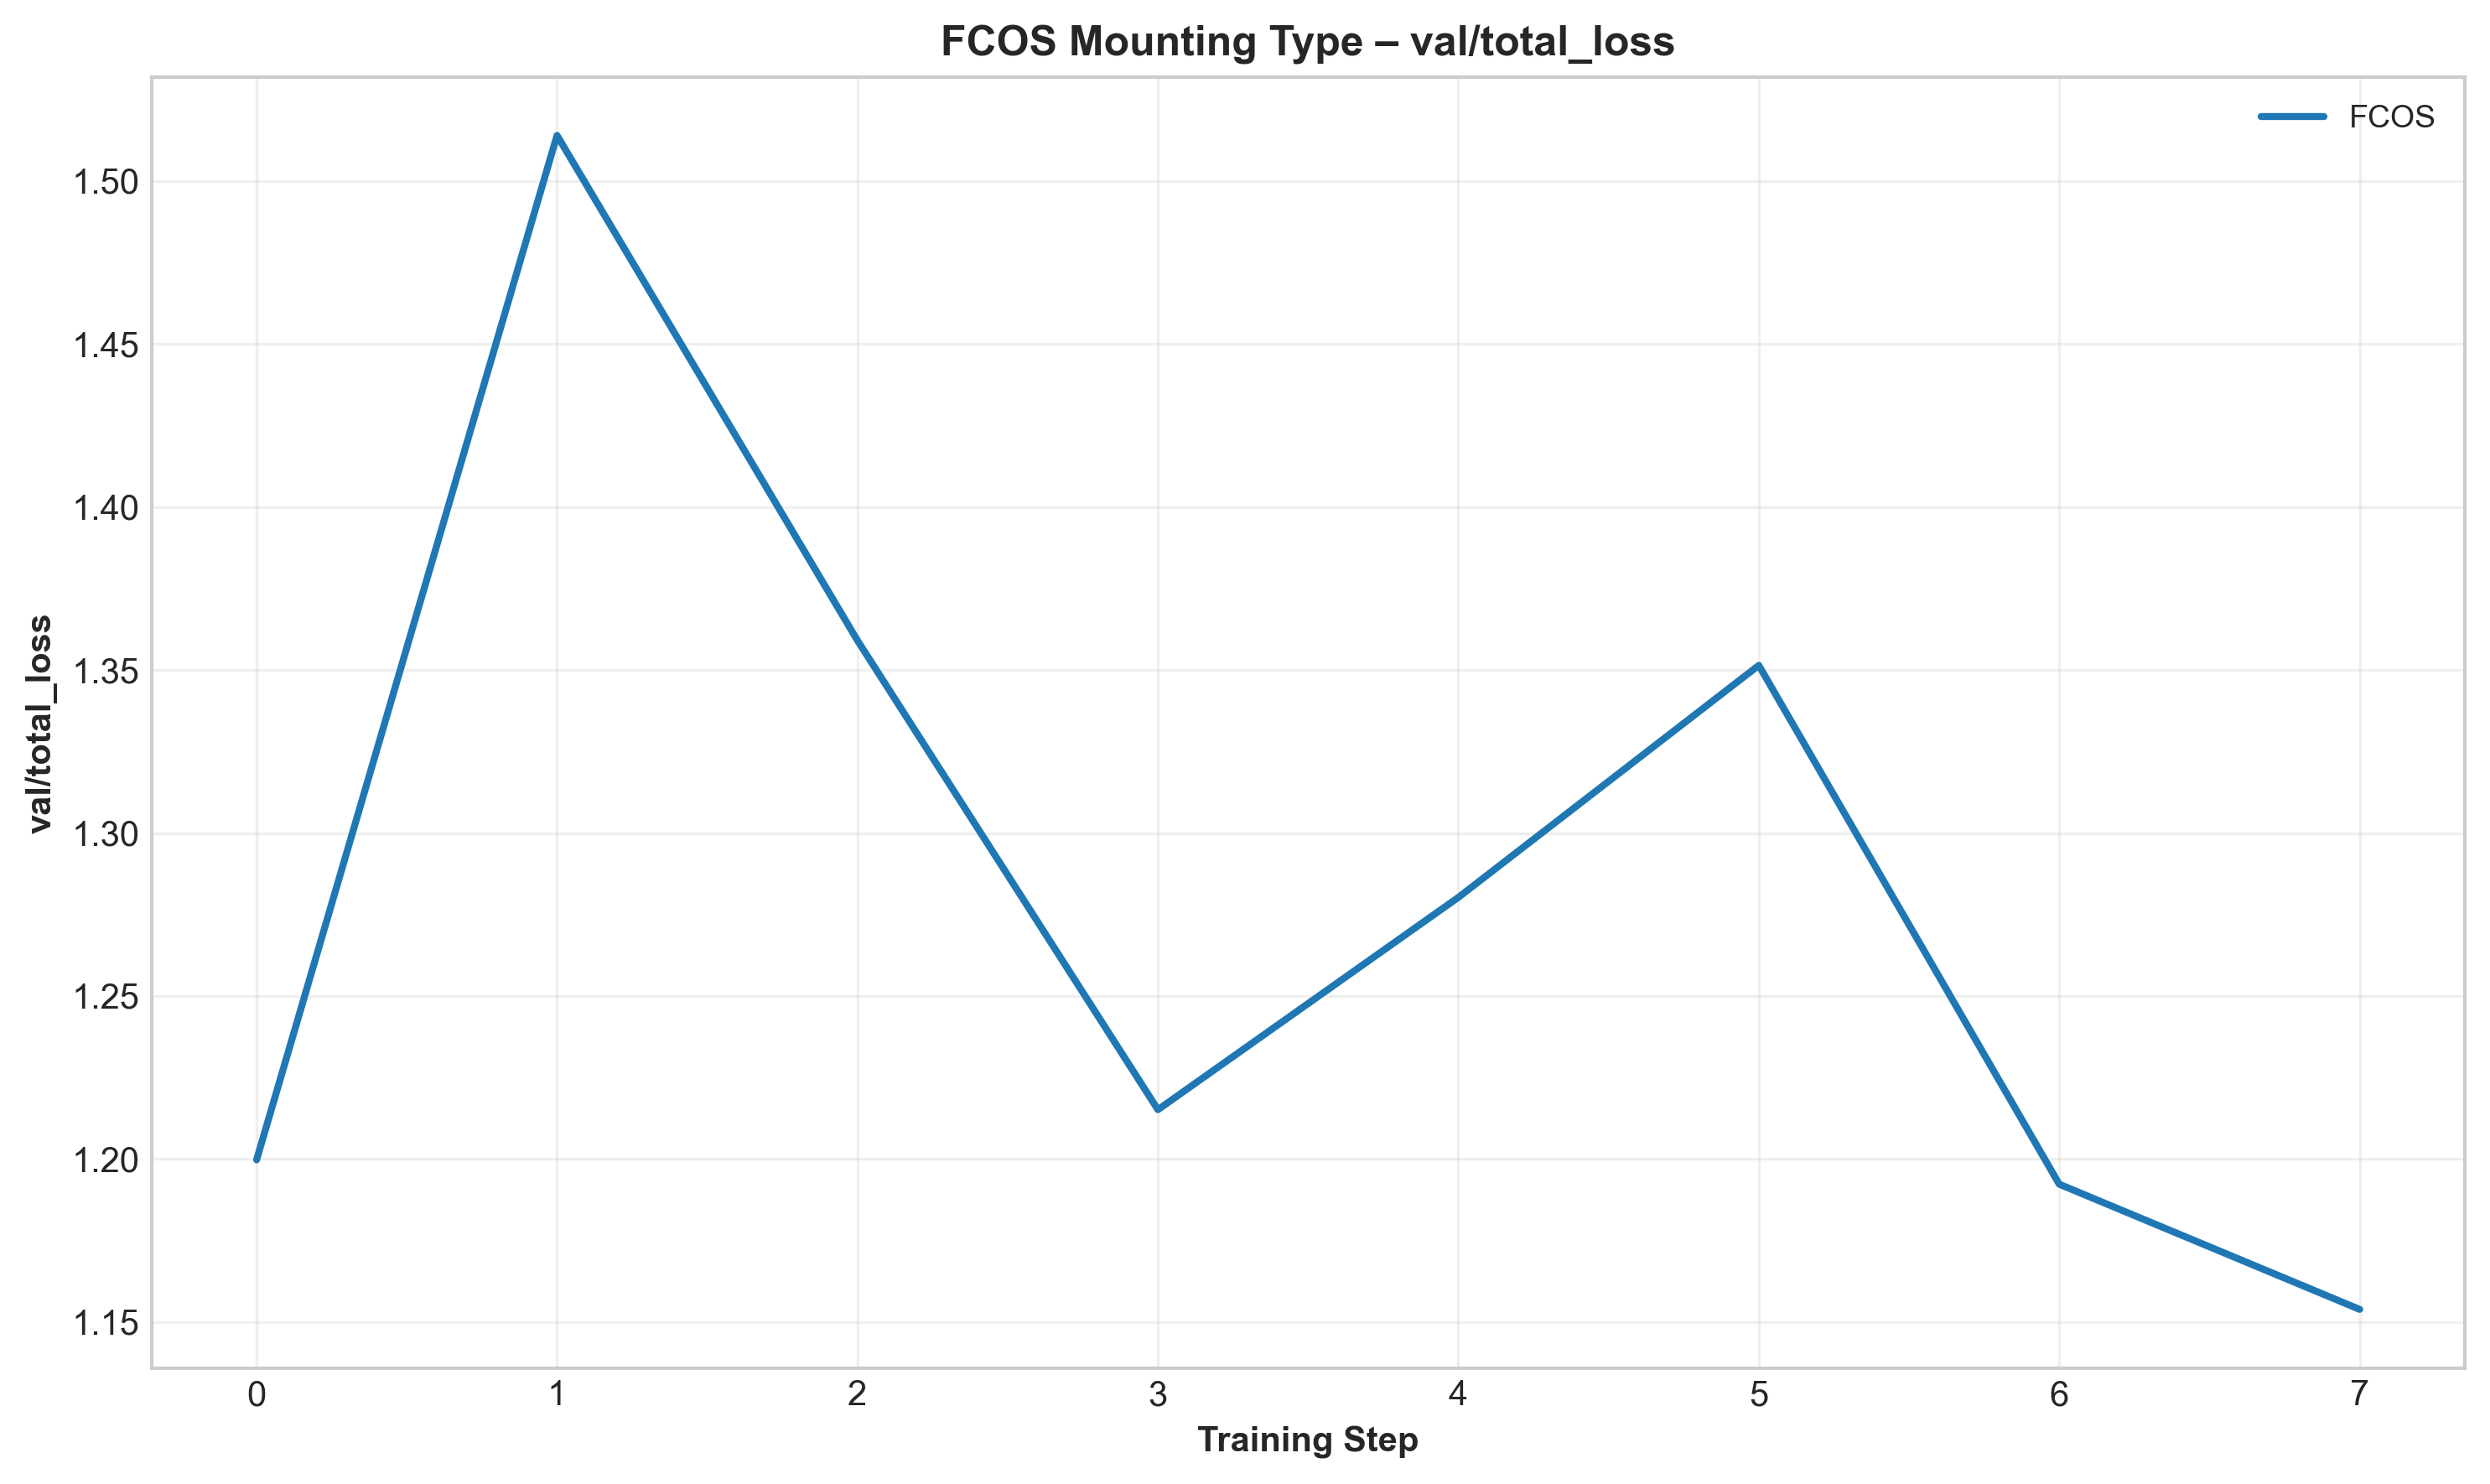

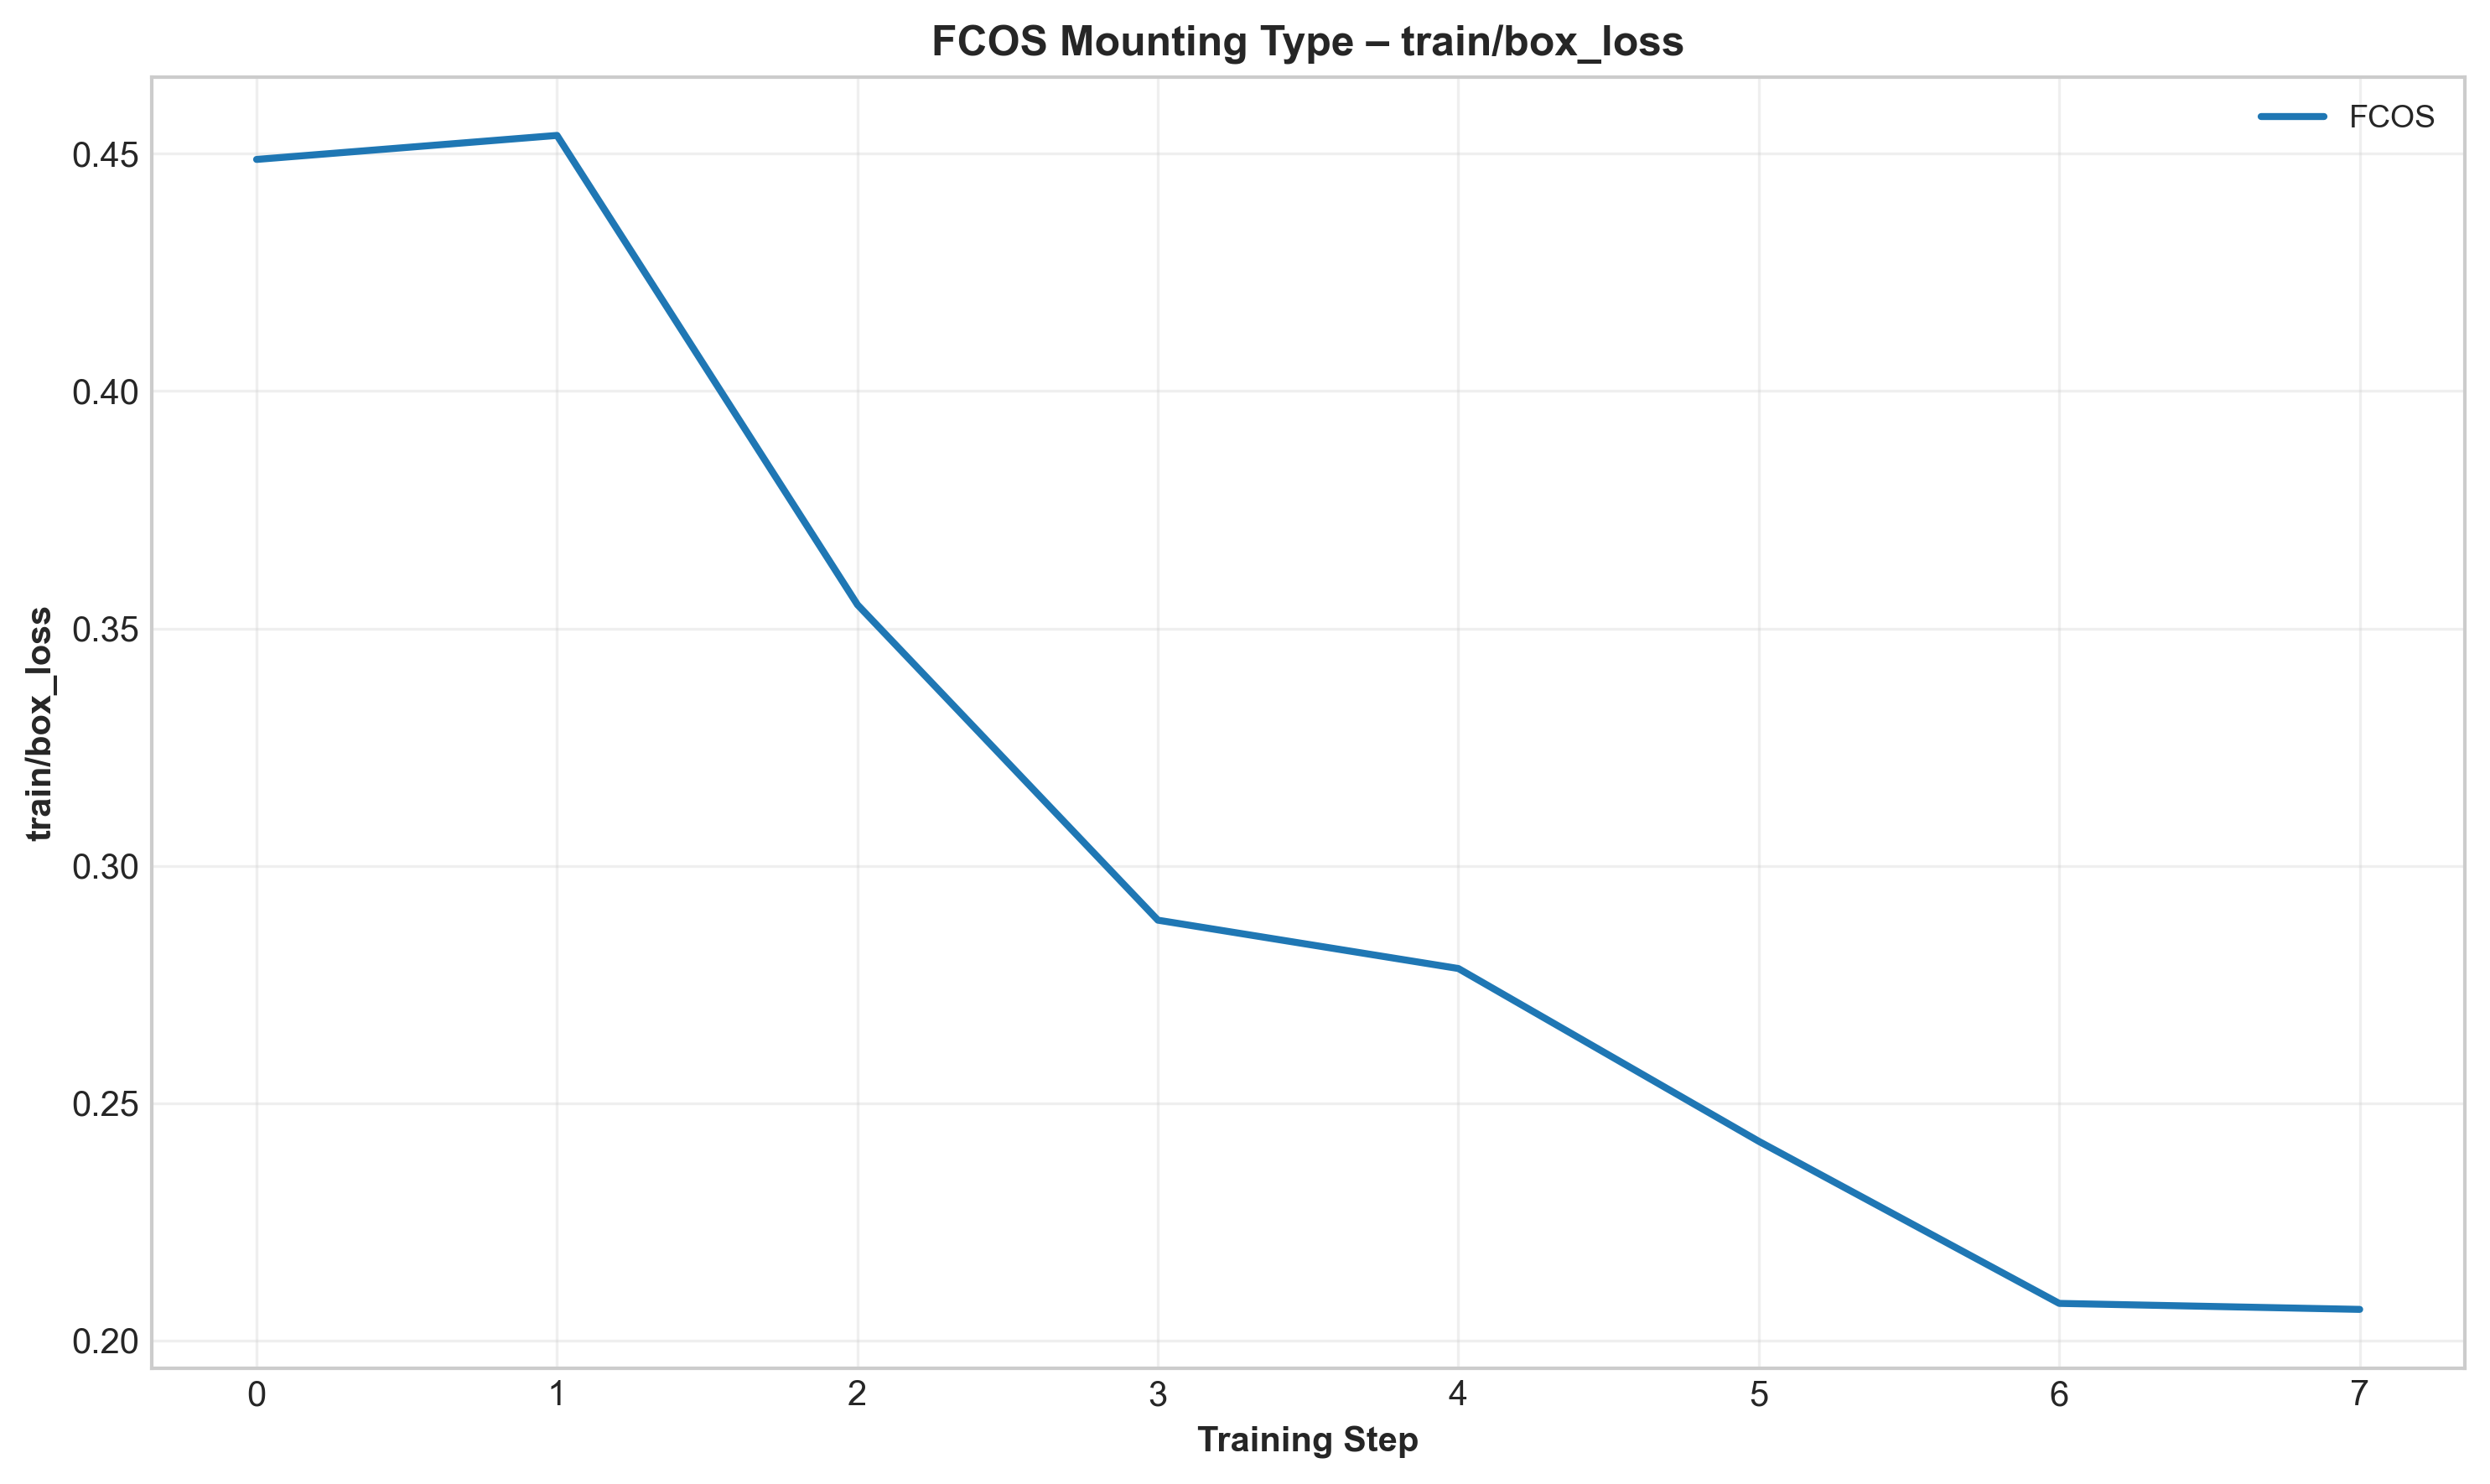

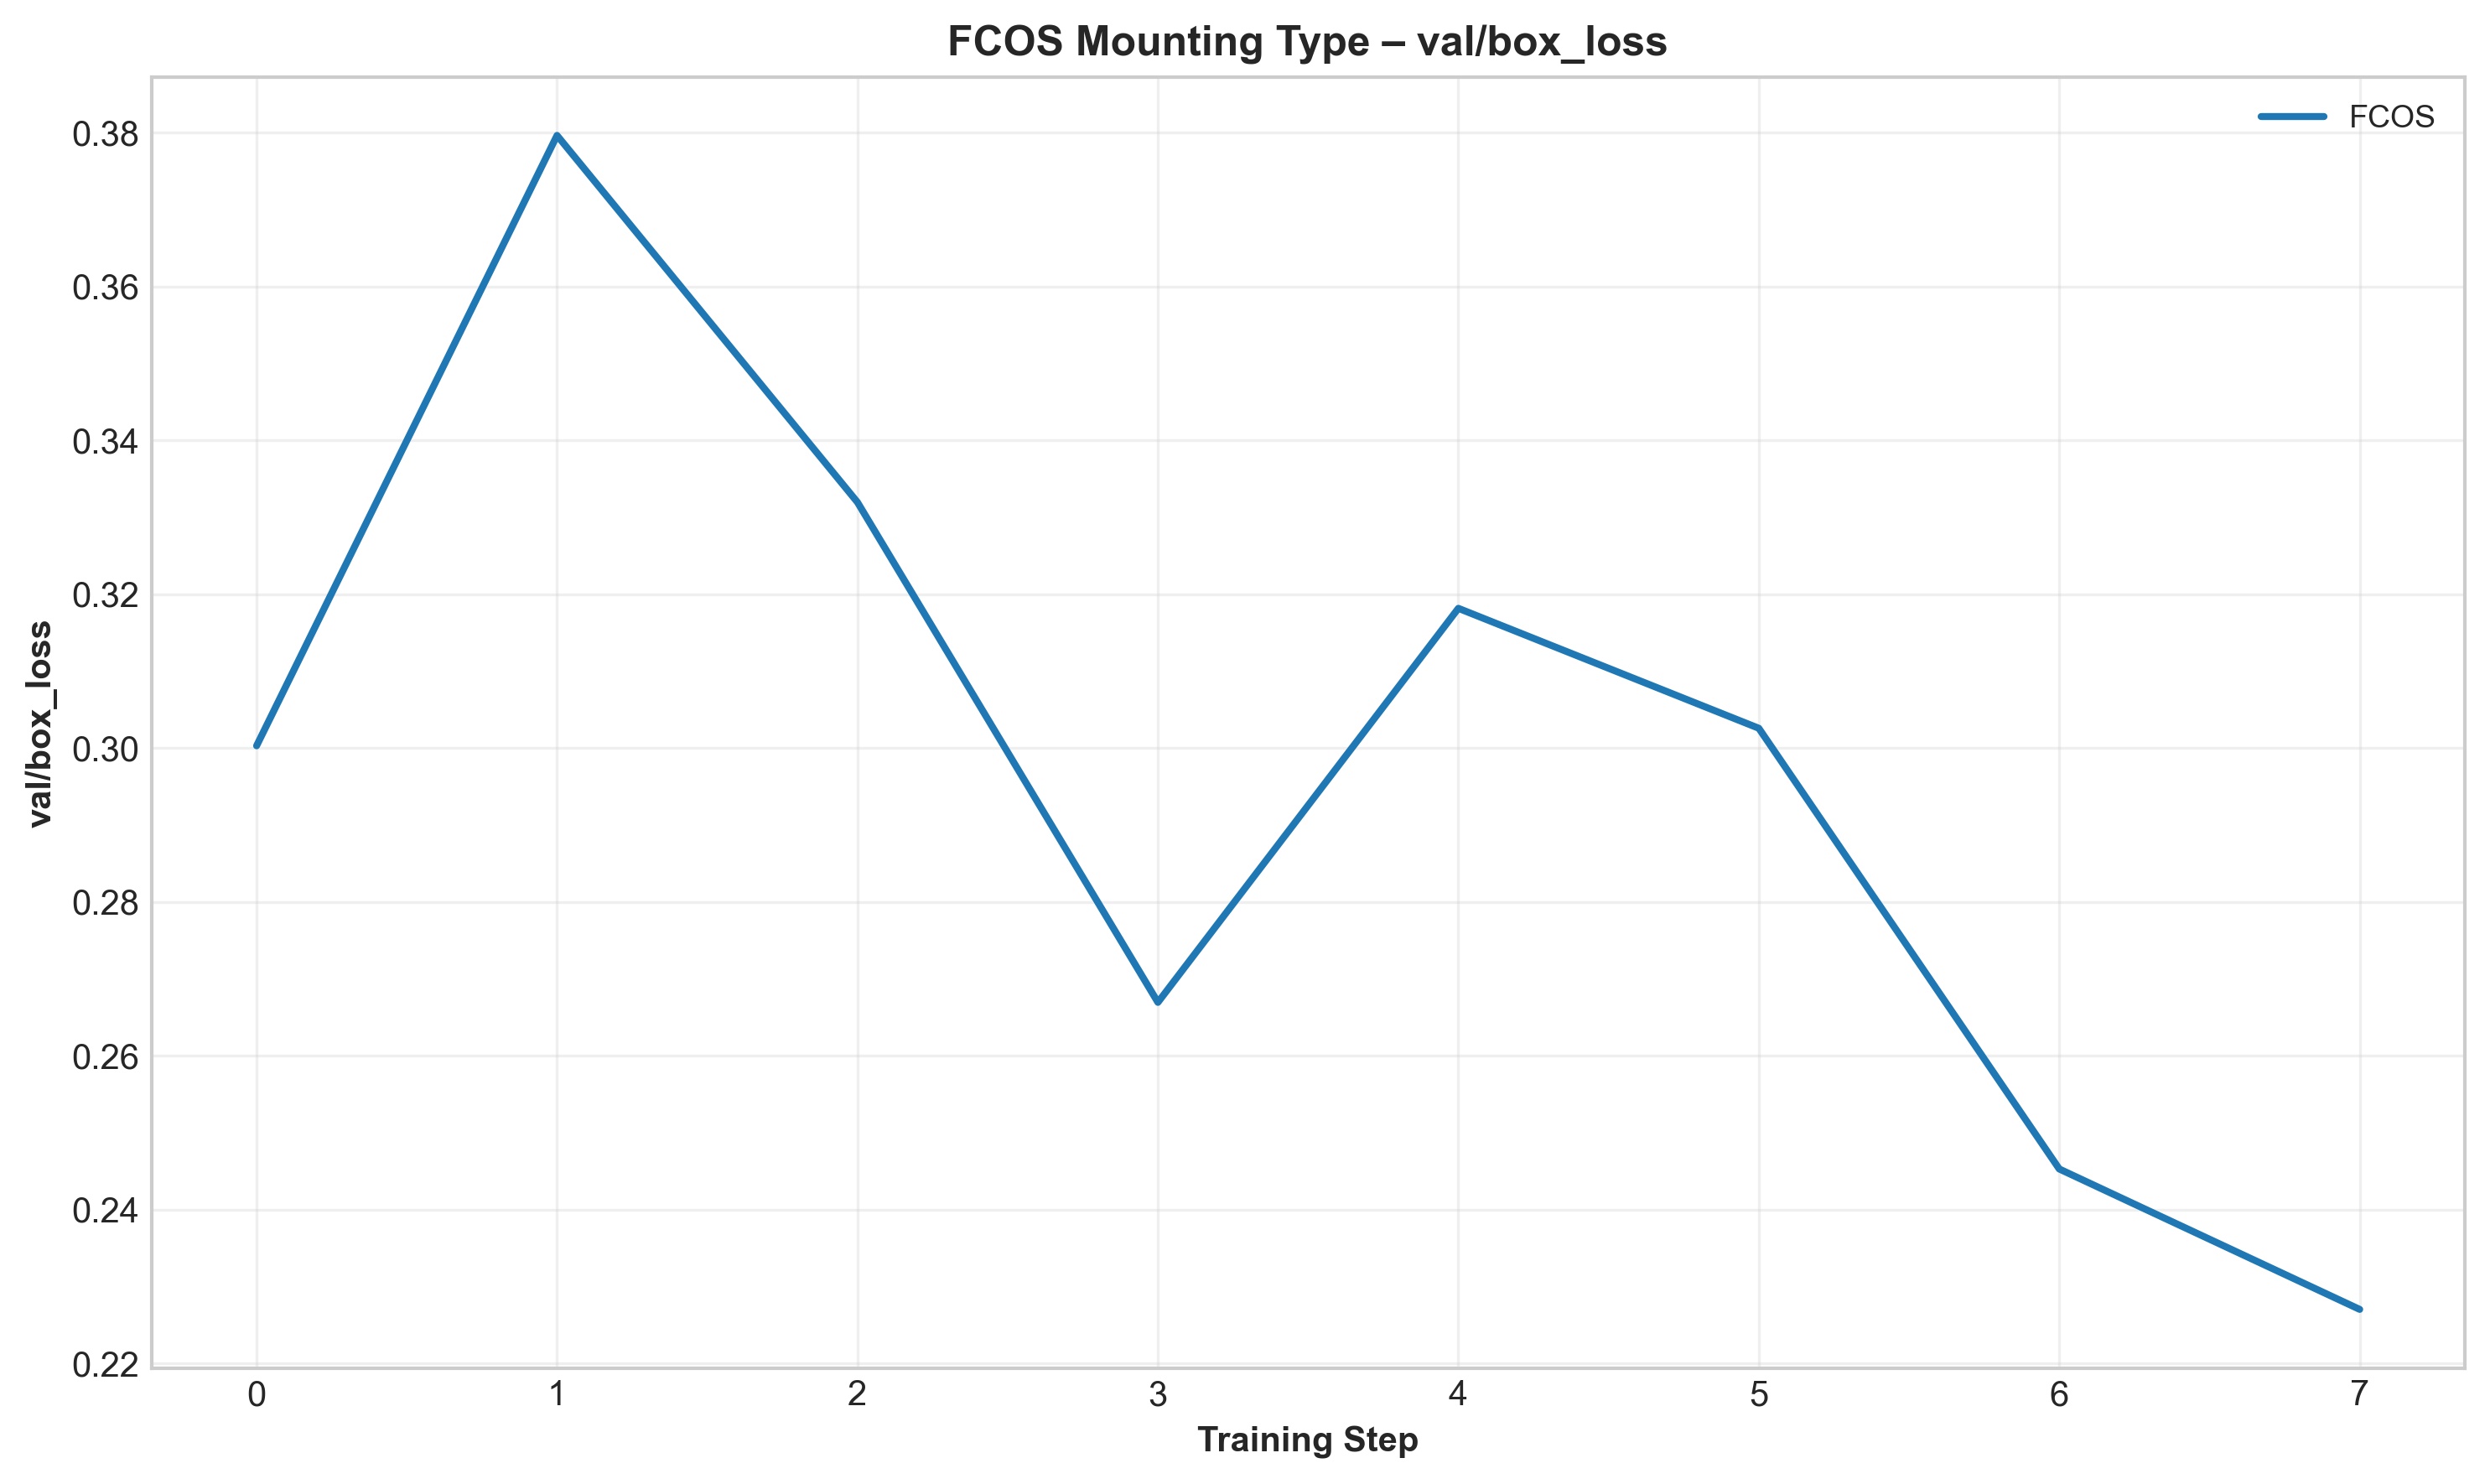

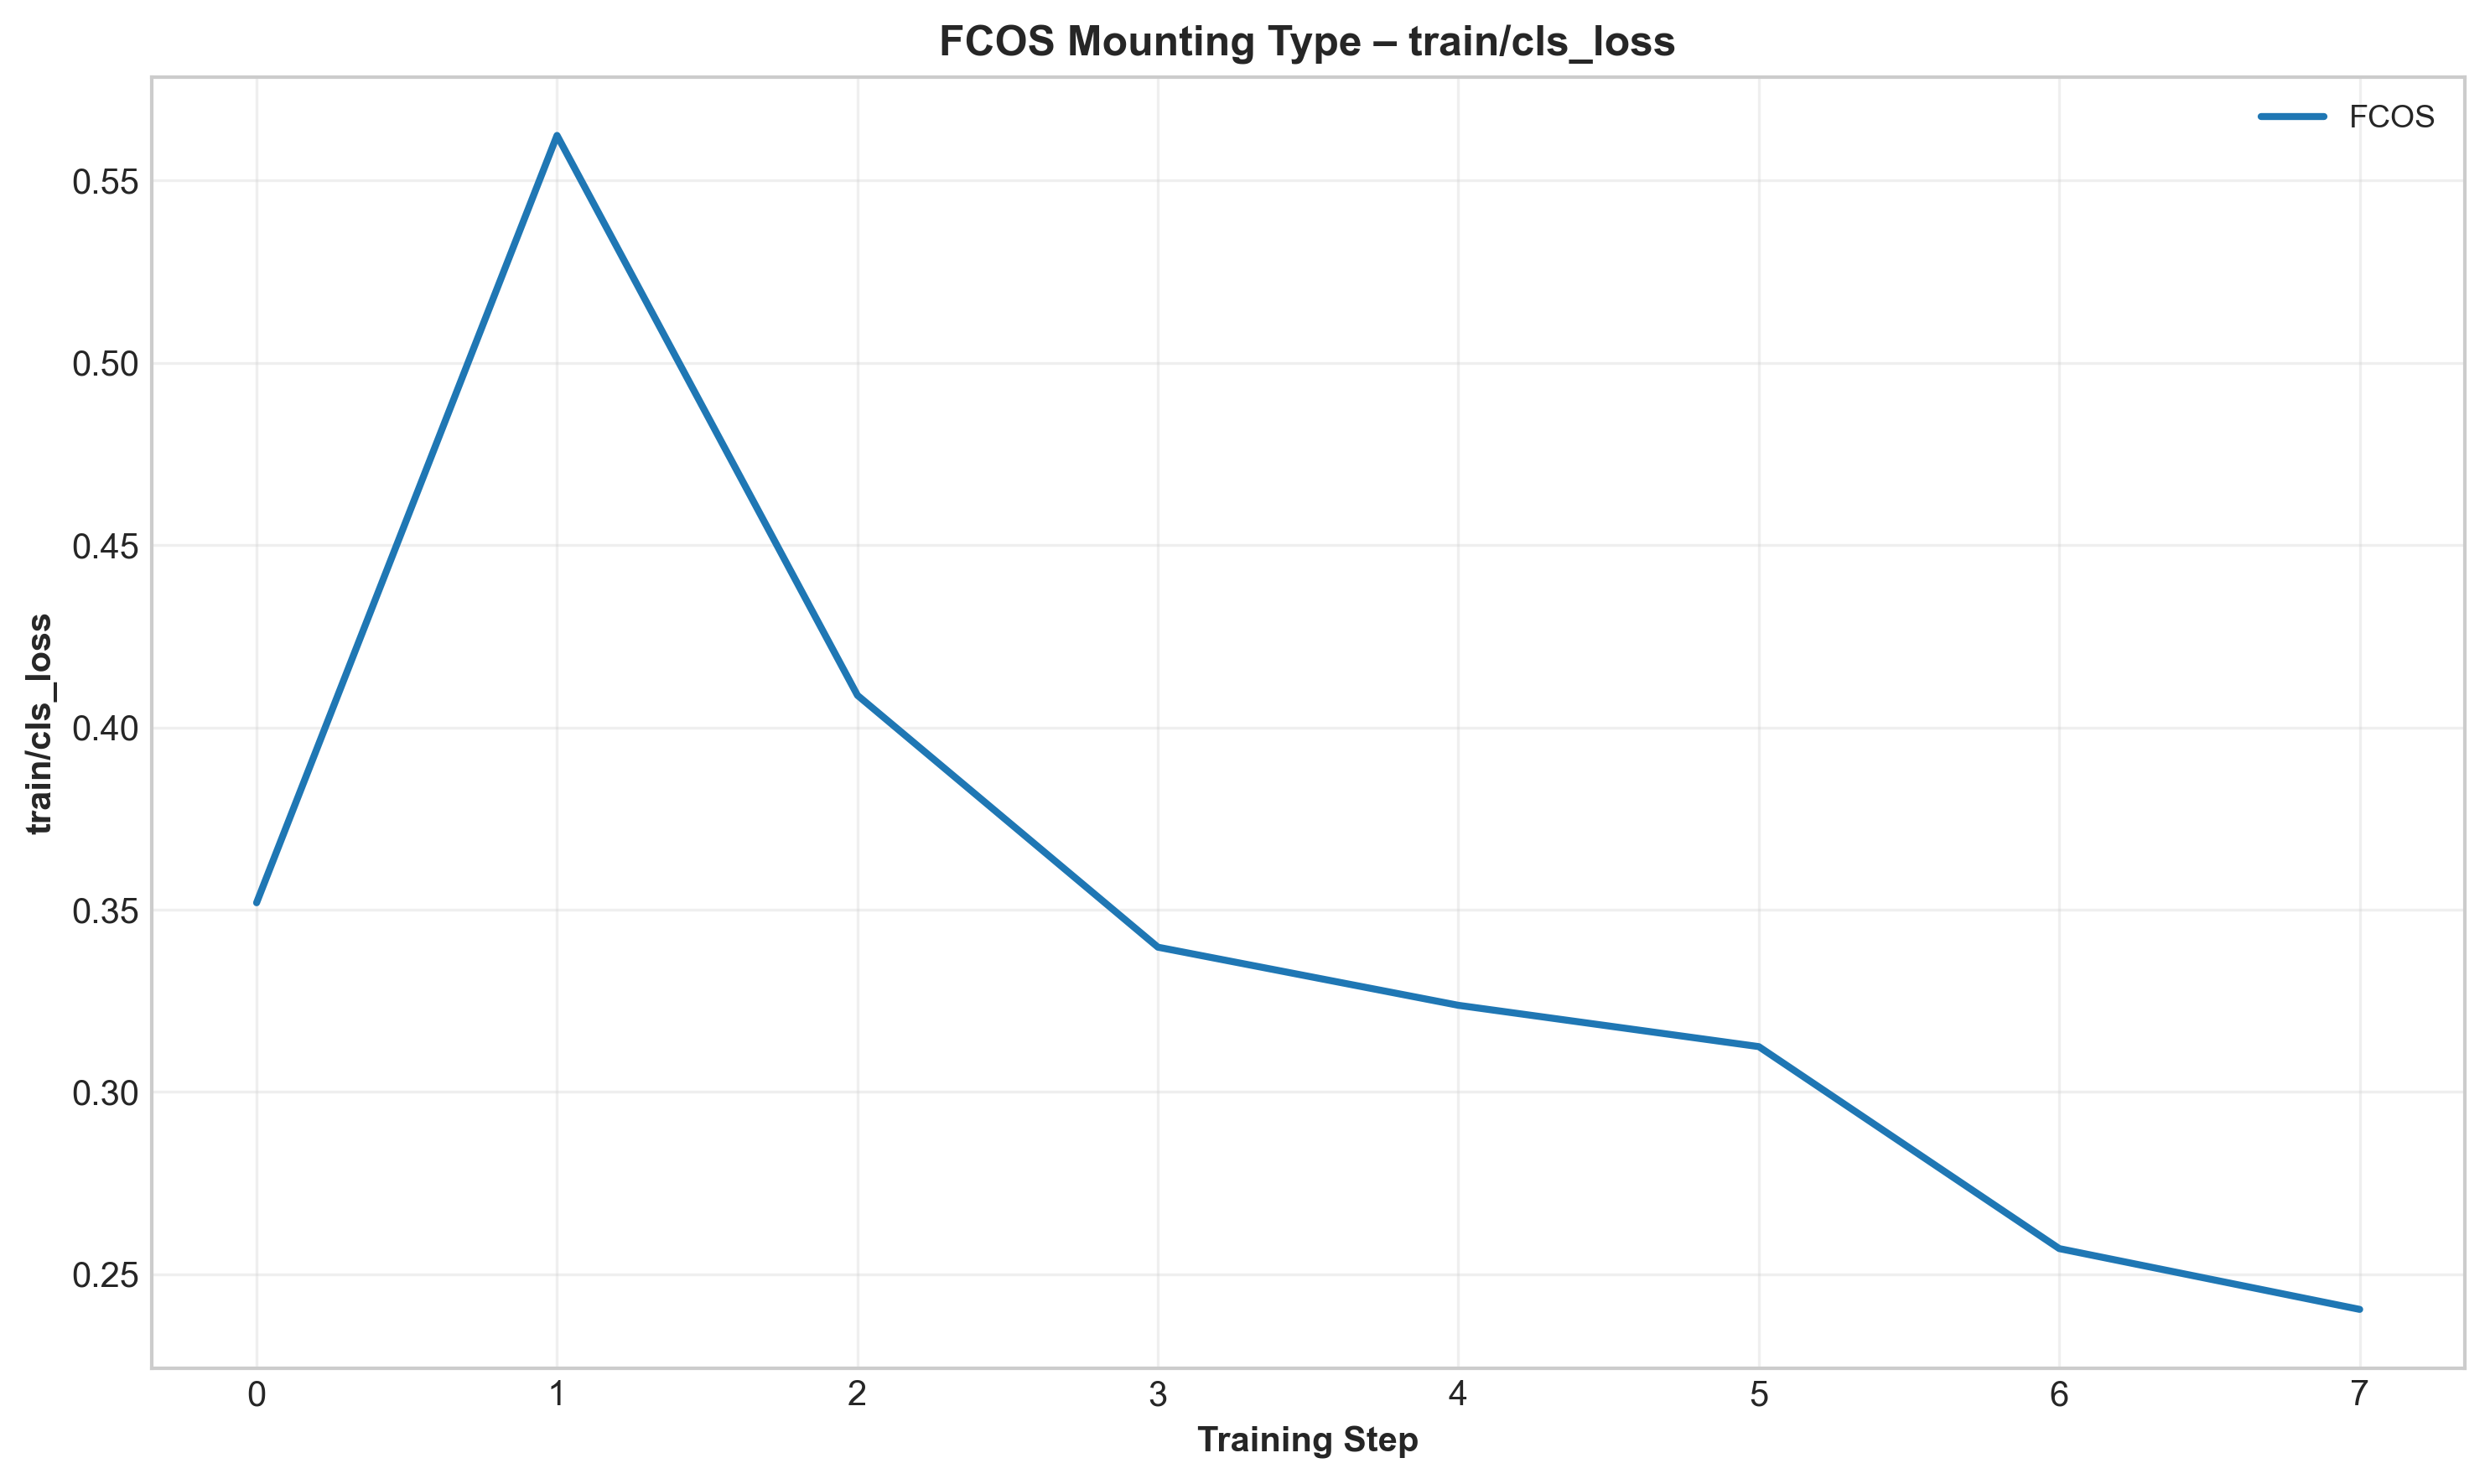

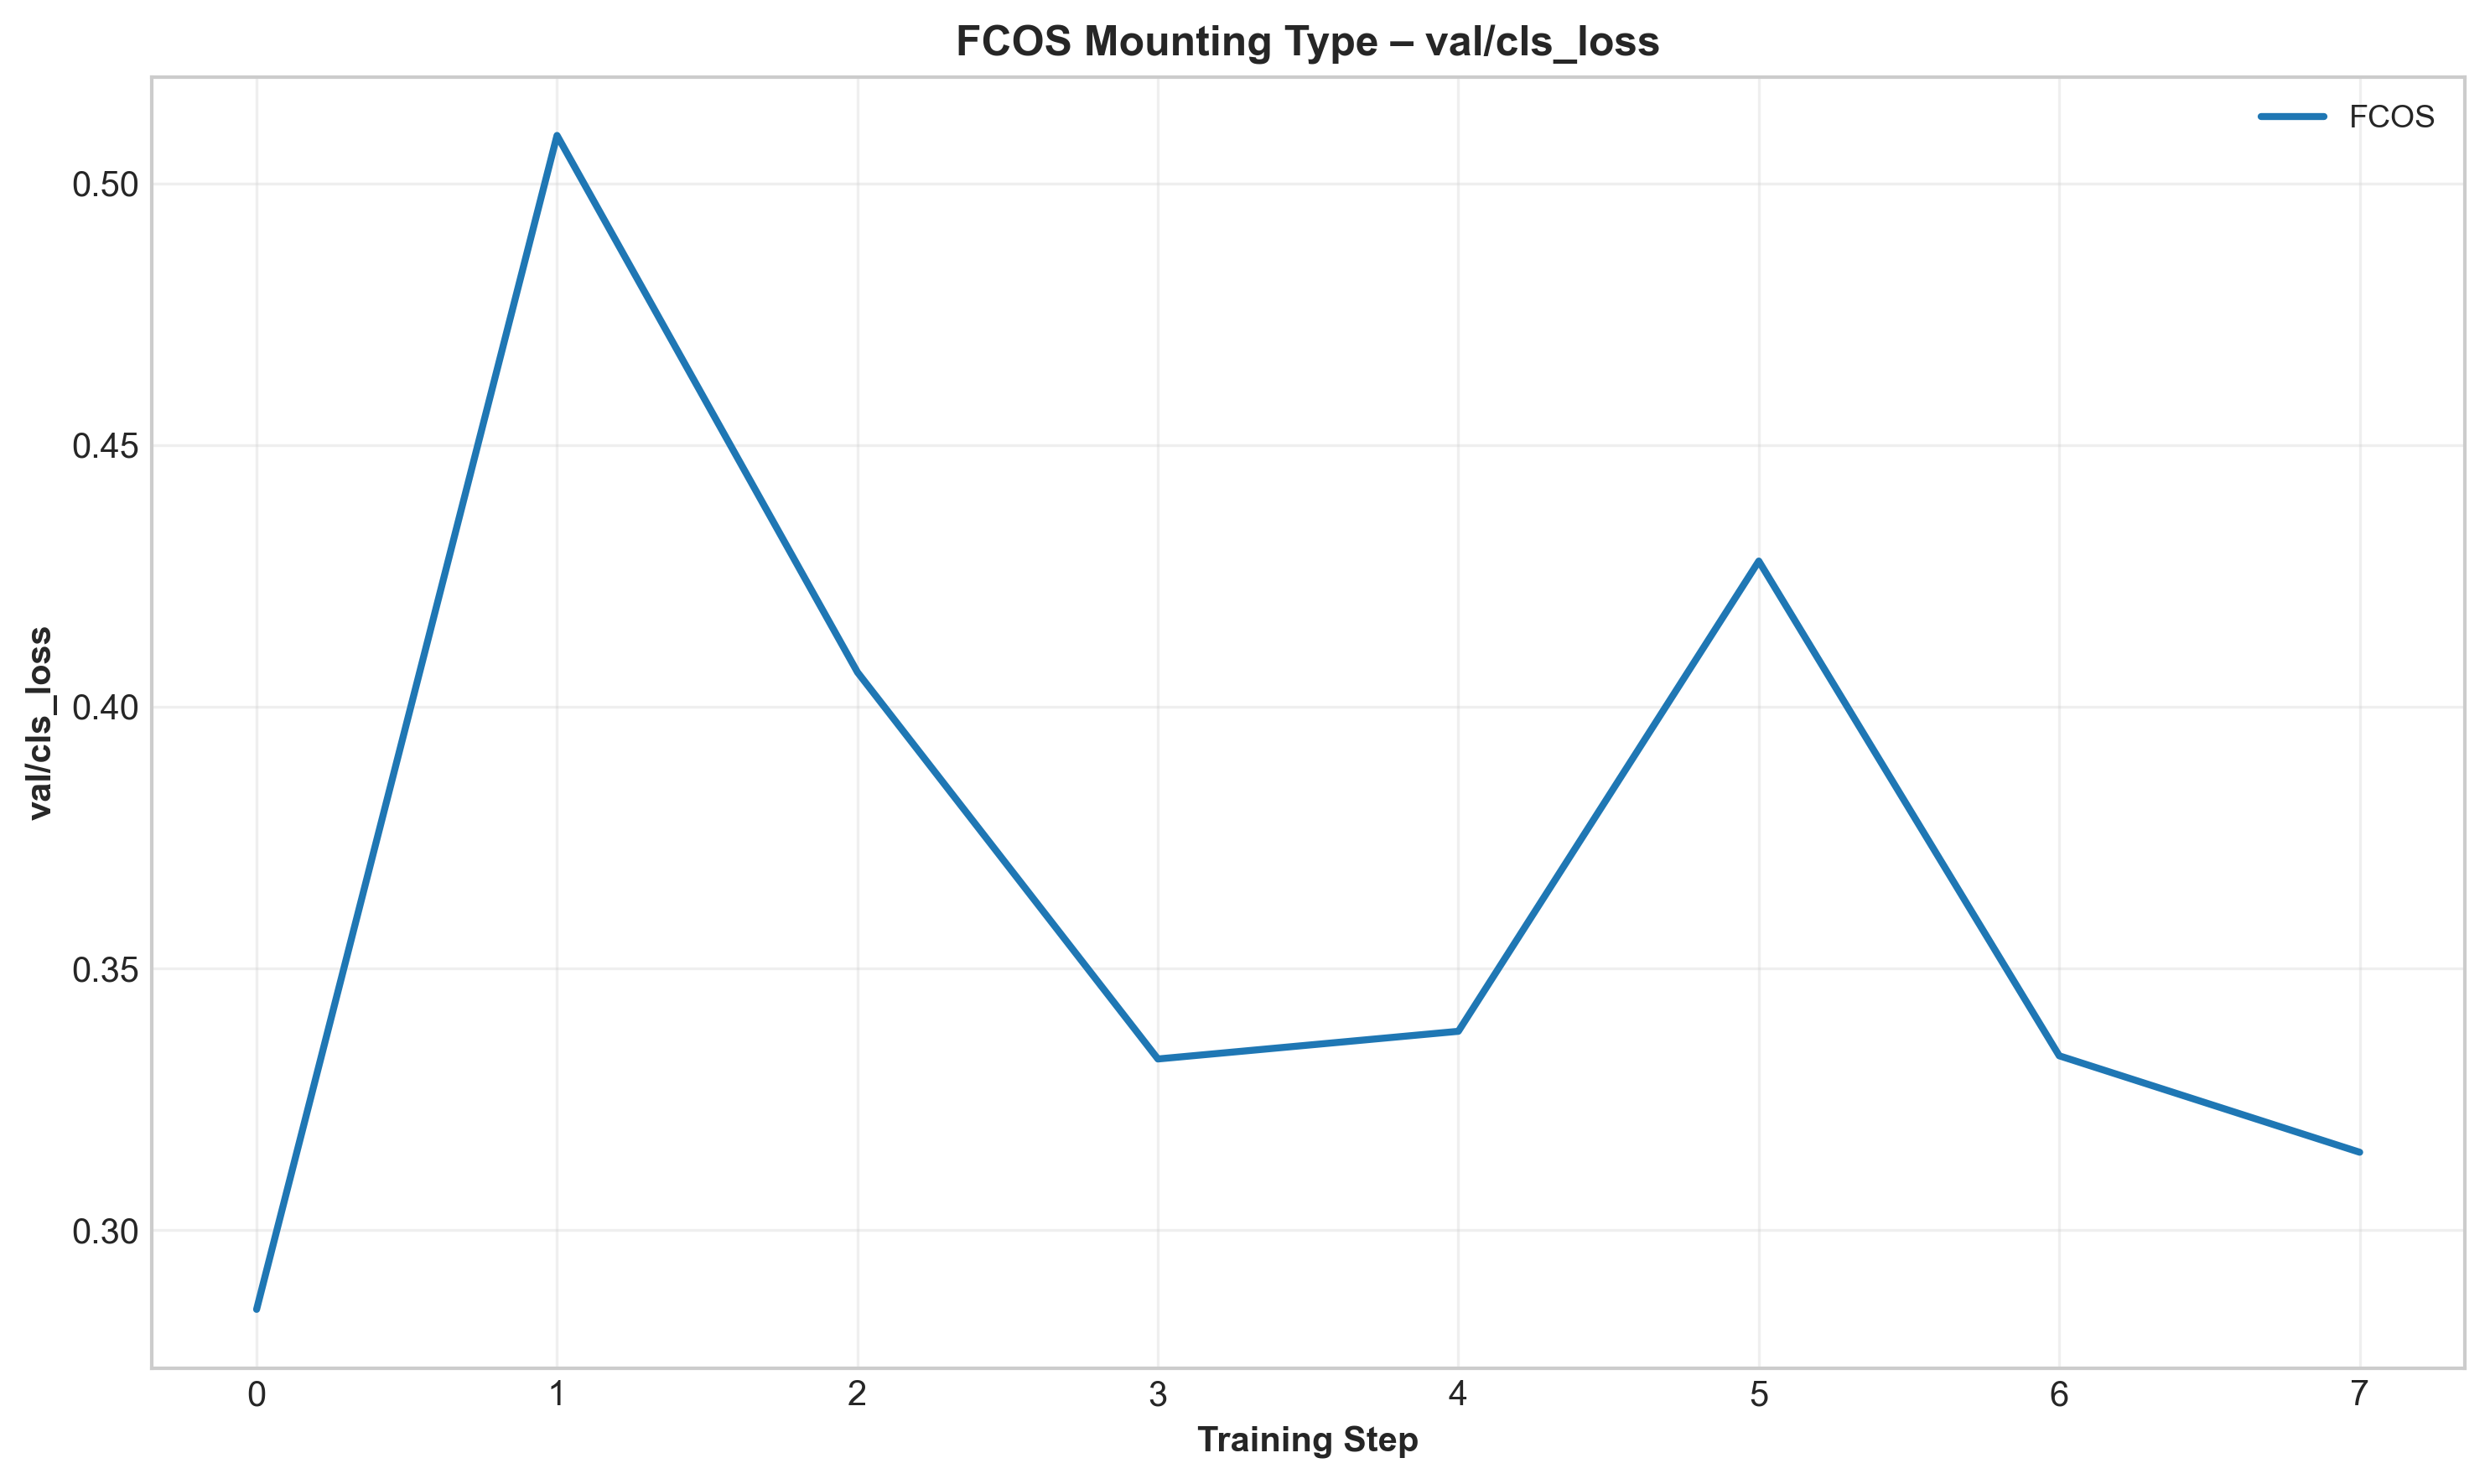

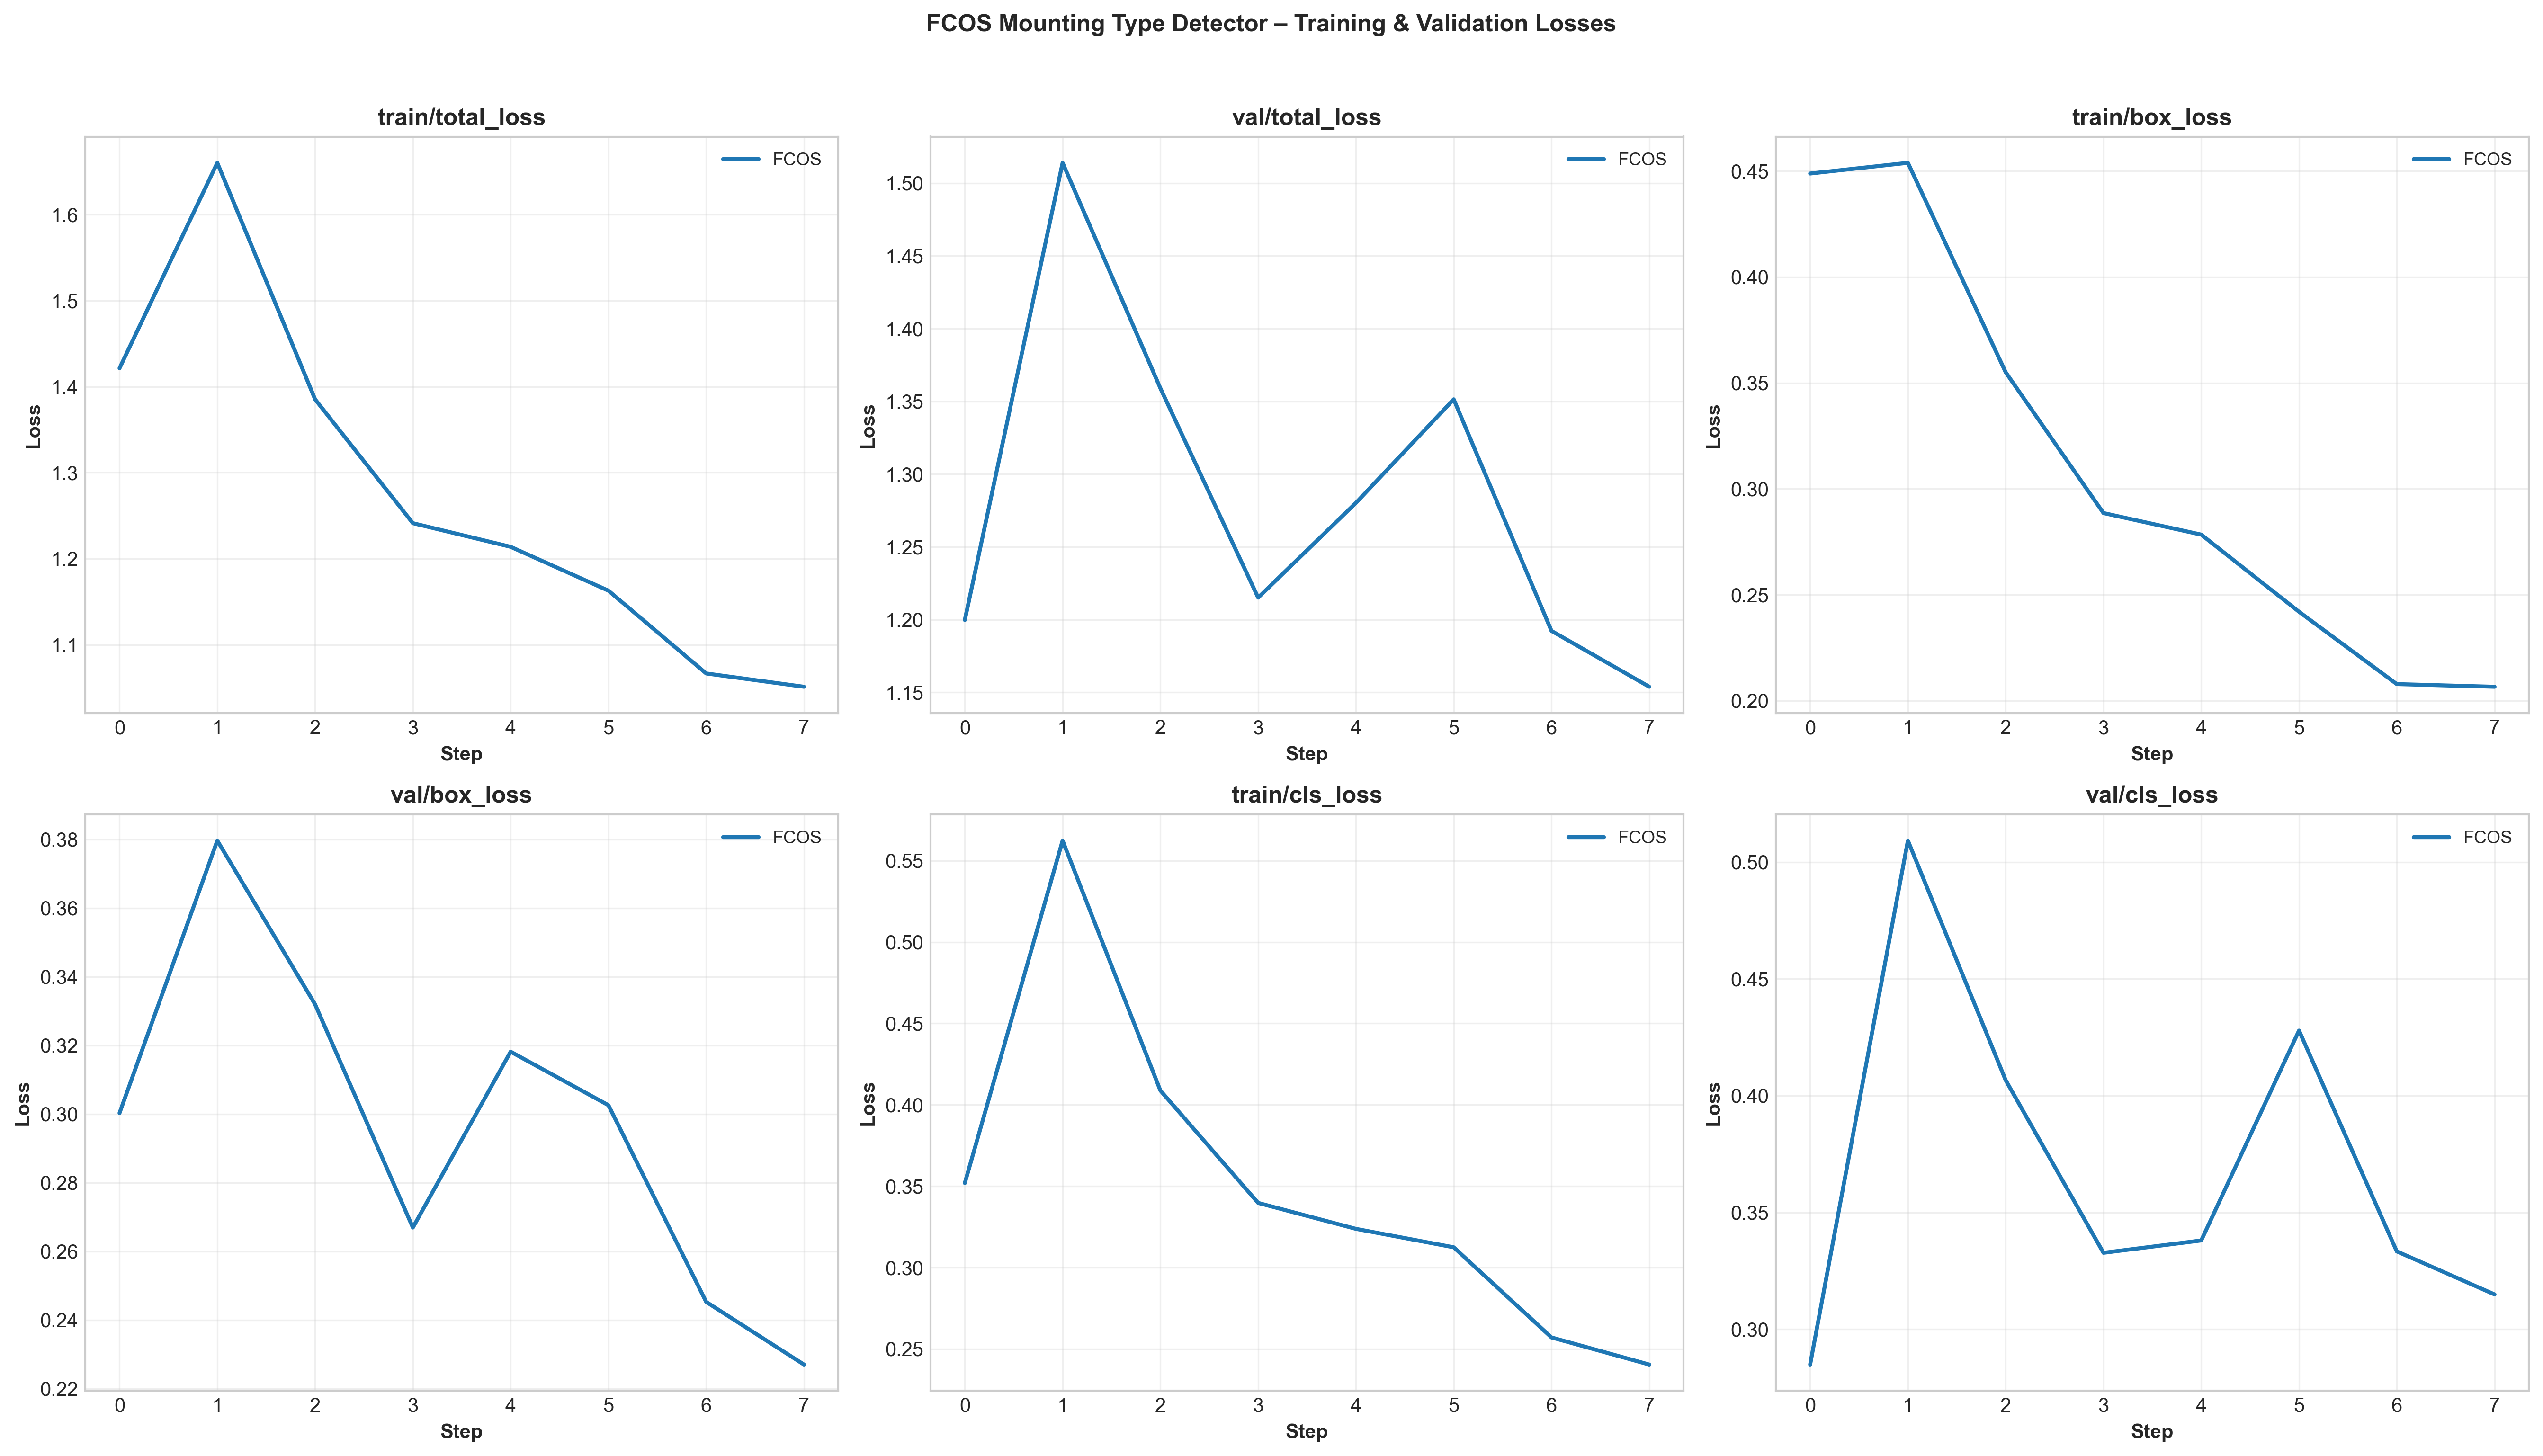

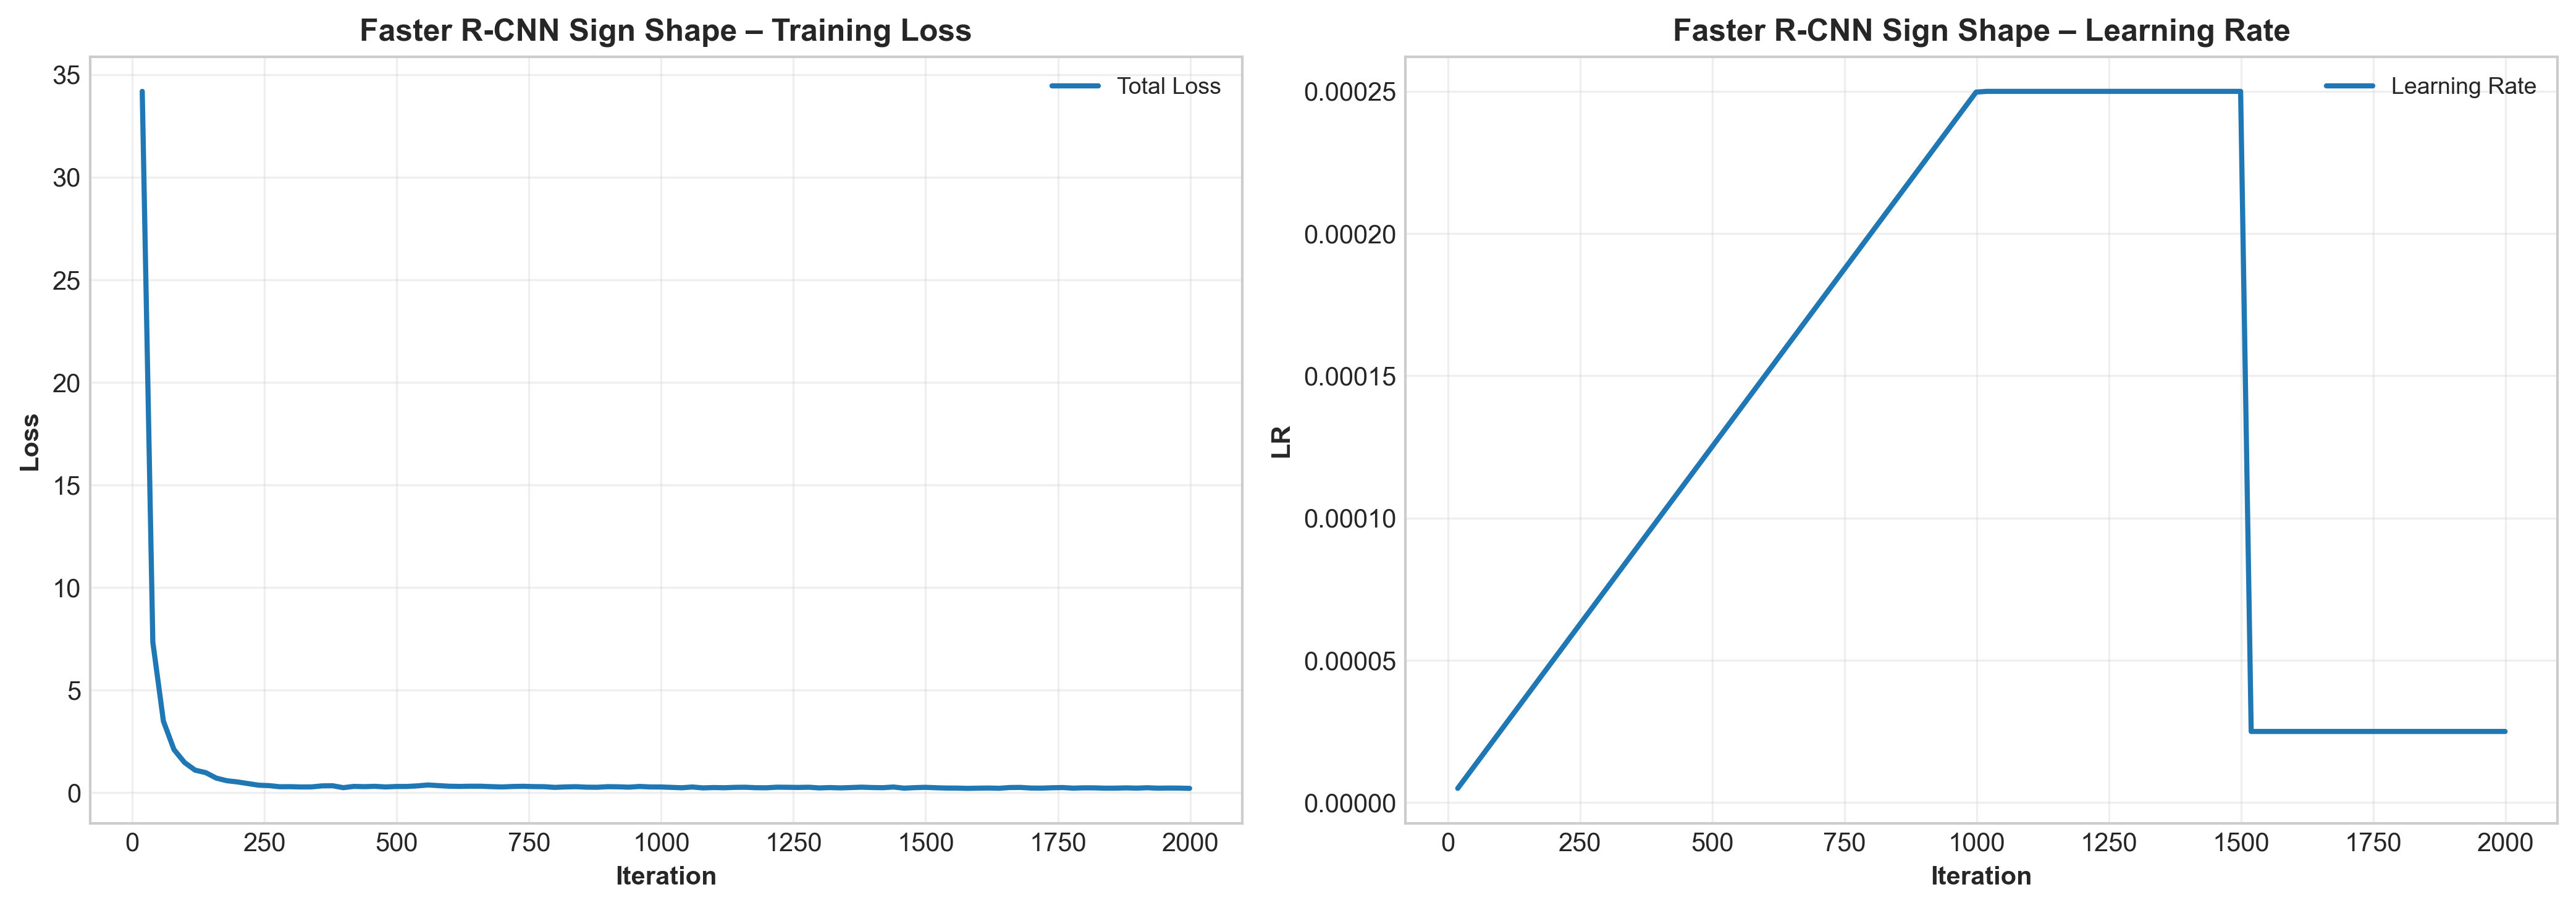

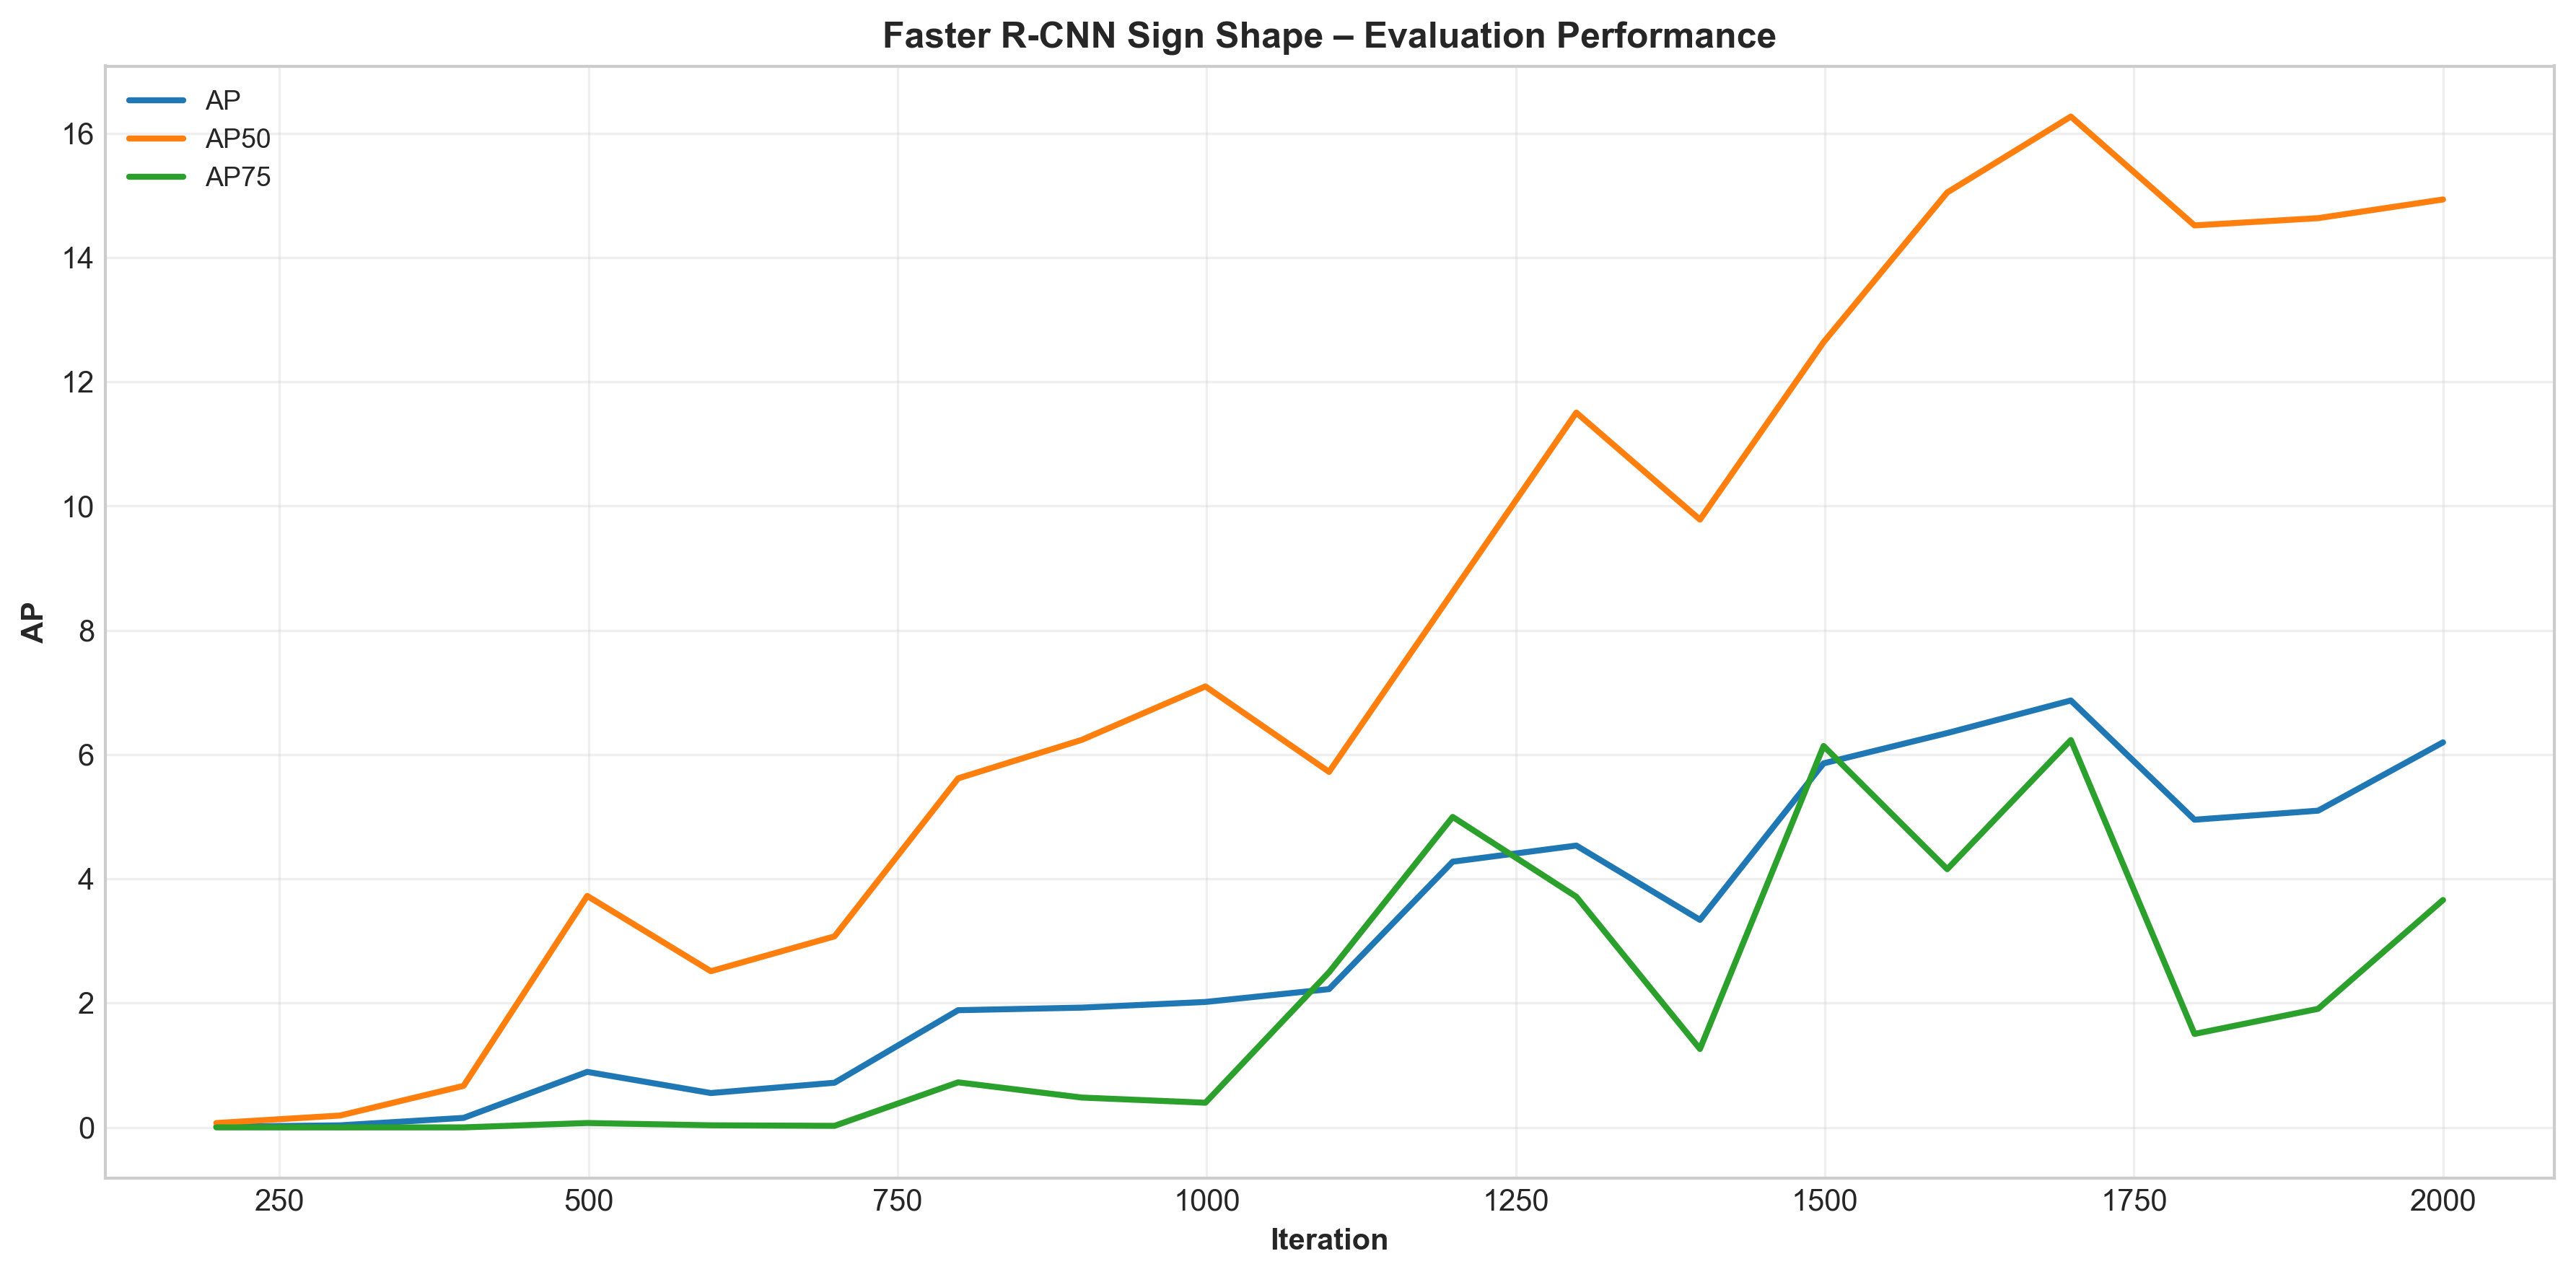

In [ ]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams["figure.dpi"] = 300

# Paths
YOLO_RESULTS_CSV = "results.csv"          # YOLOv12 – viewing angle
FCOS_METRICS_LONG = "metrics_long.csv"    # FCOS – mounting type
FASTRCNN_JSONL = "metrics.json"           # Faster R-CNN – sign shape


def pivot_long_metrics(long_df):
    wide = (
        long_df.pivot_table(
            index="step",
            columns="metric",
            values="value",
            aggfunc="mean"
        )
        .sort_index()
        .reset_index()
    )
    wide.columns.name = None
    return wide


def plot_lines(ax, x, series, title, xlabel, ylabel):
    for label, y in series.items():
        if y is not None:
            ax.plot(x, y, label=label, linewidth=2)
    ax.set_title(title, fontweight="bold")
    ax.set_xlabel(xlabel, fontweight="bold")
    ax.set_ylabel(ylabel, fontweight="bold")
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=9)


def bar_compare(ax, labels, values, title, ylabel):
    bars = ax.bar(labels, values, alpha=0.8, edgecolor="black")
    ax.set_title(title, fontweight="bold")
    ax.set_ylabel(ylabel, fontweight="bold")
    ax.grid(True, axis="y", alpha=0.3)
    for bar, val in zip(bars, values):
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height(),
            f"{val:.4f}",
            ha="center",
            va="bottom",
            fontsize=9,
            fontweight="bold"
        )


yolo_df = pd.read_csv(YOLO_RESULTS_CSV)
fcos_long = pd.read_csv(FCOS_METRICS_LONG)
fcos_df = pivot_long_metrics(fcos_long)

with open(FASTRCNN_JSONL) as f:
    fastrcnn_df = pd.DataFrame(json.loads(l) for l in f if l.strip())


fastrcnn_train = fastrcnn_df[fastrcnn_df.get("total_loss").notna()]
fastrcnn_eval = fastrcnn_df[fastrcnn_df.get("bbox/AP").notna()]


# 1) YOLOv12 – Viewing Angle Detector (results.csv)


yolo_cols = [
    "metrics/mAP50(B)",
    "metrics/mAP50-95(B)",
    "metrics/precision(B)",
    "metrics/recall(B)",
]
yolo_labels = ["mAP@50", "mAP@50-95", "Precision", "Recall"]

# Build series for line plots 
yolo_series = dict(zip(yolo_labels, [yolo_df[c] for c in yolo_cols]))

x_epoch = yolo_df["epoch"] if "epoch" in yolo_df.columns else np.arange(len(yolo_df))


fig, axes = plt.subplots(2, 2, figsize=(14, 10))
for ax, (label, series) in zip(axes.flatten(), yolo_series.items()):
    plot_lines(
        ax,
        x_epoch,
        {"YOLOv12": series},
        f"YOLOv12 Viewing Angle – {label}",
        "Epoch",
        label,
    )
plt.suptitle("YOLOv12 Viewing Angle Detector – Performance Metrics", fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()

# Final vs Best epoch 
map5095_col = "metrics/mAP50-95(B)"
best_idx = yolo_df[map5095_col].astype(float).idxmax() if map5095_col in yolo_df.columns else yolo_df.index[-1]

final_row = yolo_df.iloc[-1]
best_row = yolo_df.loc[best_idx]

final_vals = [float(final_row[c]) for c in yolo_cols]
best_vals  = [float(best_row[c]) for c in yolo_cols]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
bar_compare(
    axes[0],
    yolo_labels,
    final_vals,
    "YOLOv12 Viewing Angle – Final Epoch",
    "Score",
)
bar_compare(
    axes[1],
    yolo_labels,
    best_vals,
    f"YOLOv12 Viewing Angle – Best Epoch (epoch {best_row.get('epoch', best_idx)})",
    "Score",
)
plt.tight_layout()
plt.show()

# 2) FCOS – Mounting Type Detector (metrics_long.csv)

x_step = fcos_df["step"]

candidate_metrics = [
    "train/total_loss",
    "val/total_loss",
    "train/box_loss",
    "val/box_loss",
    "train/cls_loss",
    "val/cls_loss",
]

available = [m for m in candidate_metrics if m in fcos_df.columns]

for m in available:
    fig, ax = plt.subplots(figsize=(10, 6))
    plot_lines(
        ax,
        x_step,
        {"FCOS": fcos_df[m]},
        f"FCOS Mounting Type – {m}",
        "Training Step",
        m
    )
    plt.tight_layout()
    plt.show()


fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, m in enumerate(available[:6]):
    plot_lines(
        axes[i],
        x_step,
        {"FCOS": fcos_df[m]},
        m,
        "Step",
        "Loss"
    )

for ax in axes[len(available):]:
    ax.axis("off")

plt.suptitle("FCOS Mounting Type Detector – Training & Validation Losses", fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()


# 3) Faster R-CNN – Sign Shape Detector (metrics.json)

if not fastrcnn_train.empty:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    plot_lines(
        axes[0],
        fastrcnn_train["iteration"],
        {"Total Loss": fastrcnn_train["total_loss"]},
        "Faster R-CNN Sign Shape – Training Loss",
        "Iteration",
        "Loss"
    )

    if "lr" in fastrcnn_train.columns:
        plot_lines(
            axes[1],
            fastrcnn_train["iteration"],
            {"Learning Rate": fastrcnn_train["lr"]},
            "Faster R-CNN Sign Shape – Learning Rate",
            "Iteration",
            "LR"
        )

    plt.tight_layout()
    plt.show()

# AP curves
if not fastrcnn_eval.empty:
    fig, ax = plt.subplots(figsize=(12, 6))
    plot_lines(
        ax,
        fastrcnn_eval["iteration"],
        {
            "AP": fastrcnn_eval["bbox/AP"],
            "AP50": fastrcnn_eval.get("bbox/AP50"),
            "AP75": fastrcnn_eval.get("bbox/AP75"),
        },
        "Faster R-CNN Sign Shape – Evaluation Performance",
        "Iteration",
        "AP"
    )
    plt.tight_layout()
    plt.show()




## RetinaNet

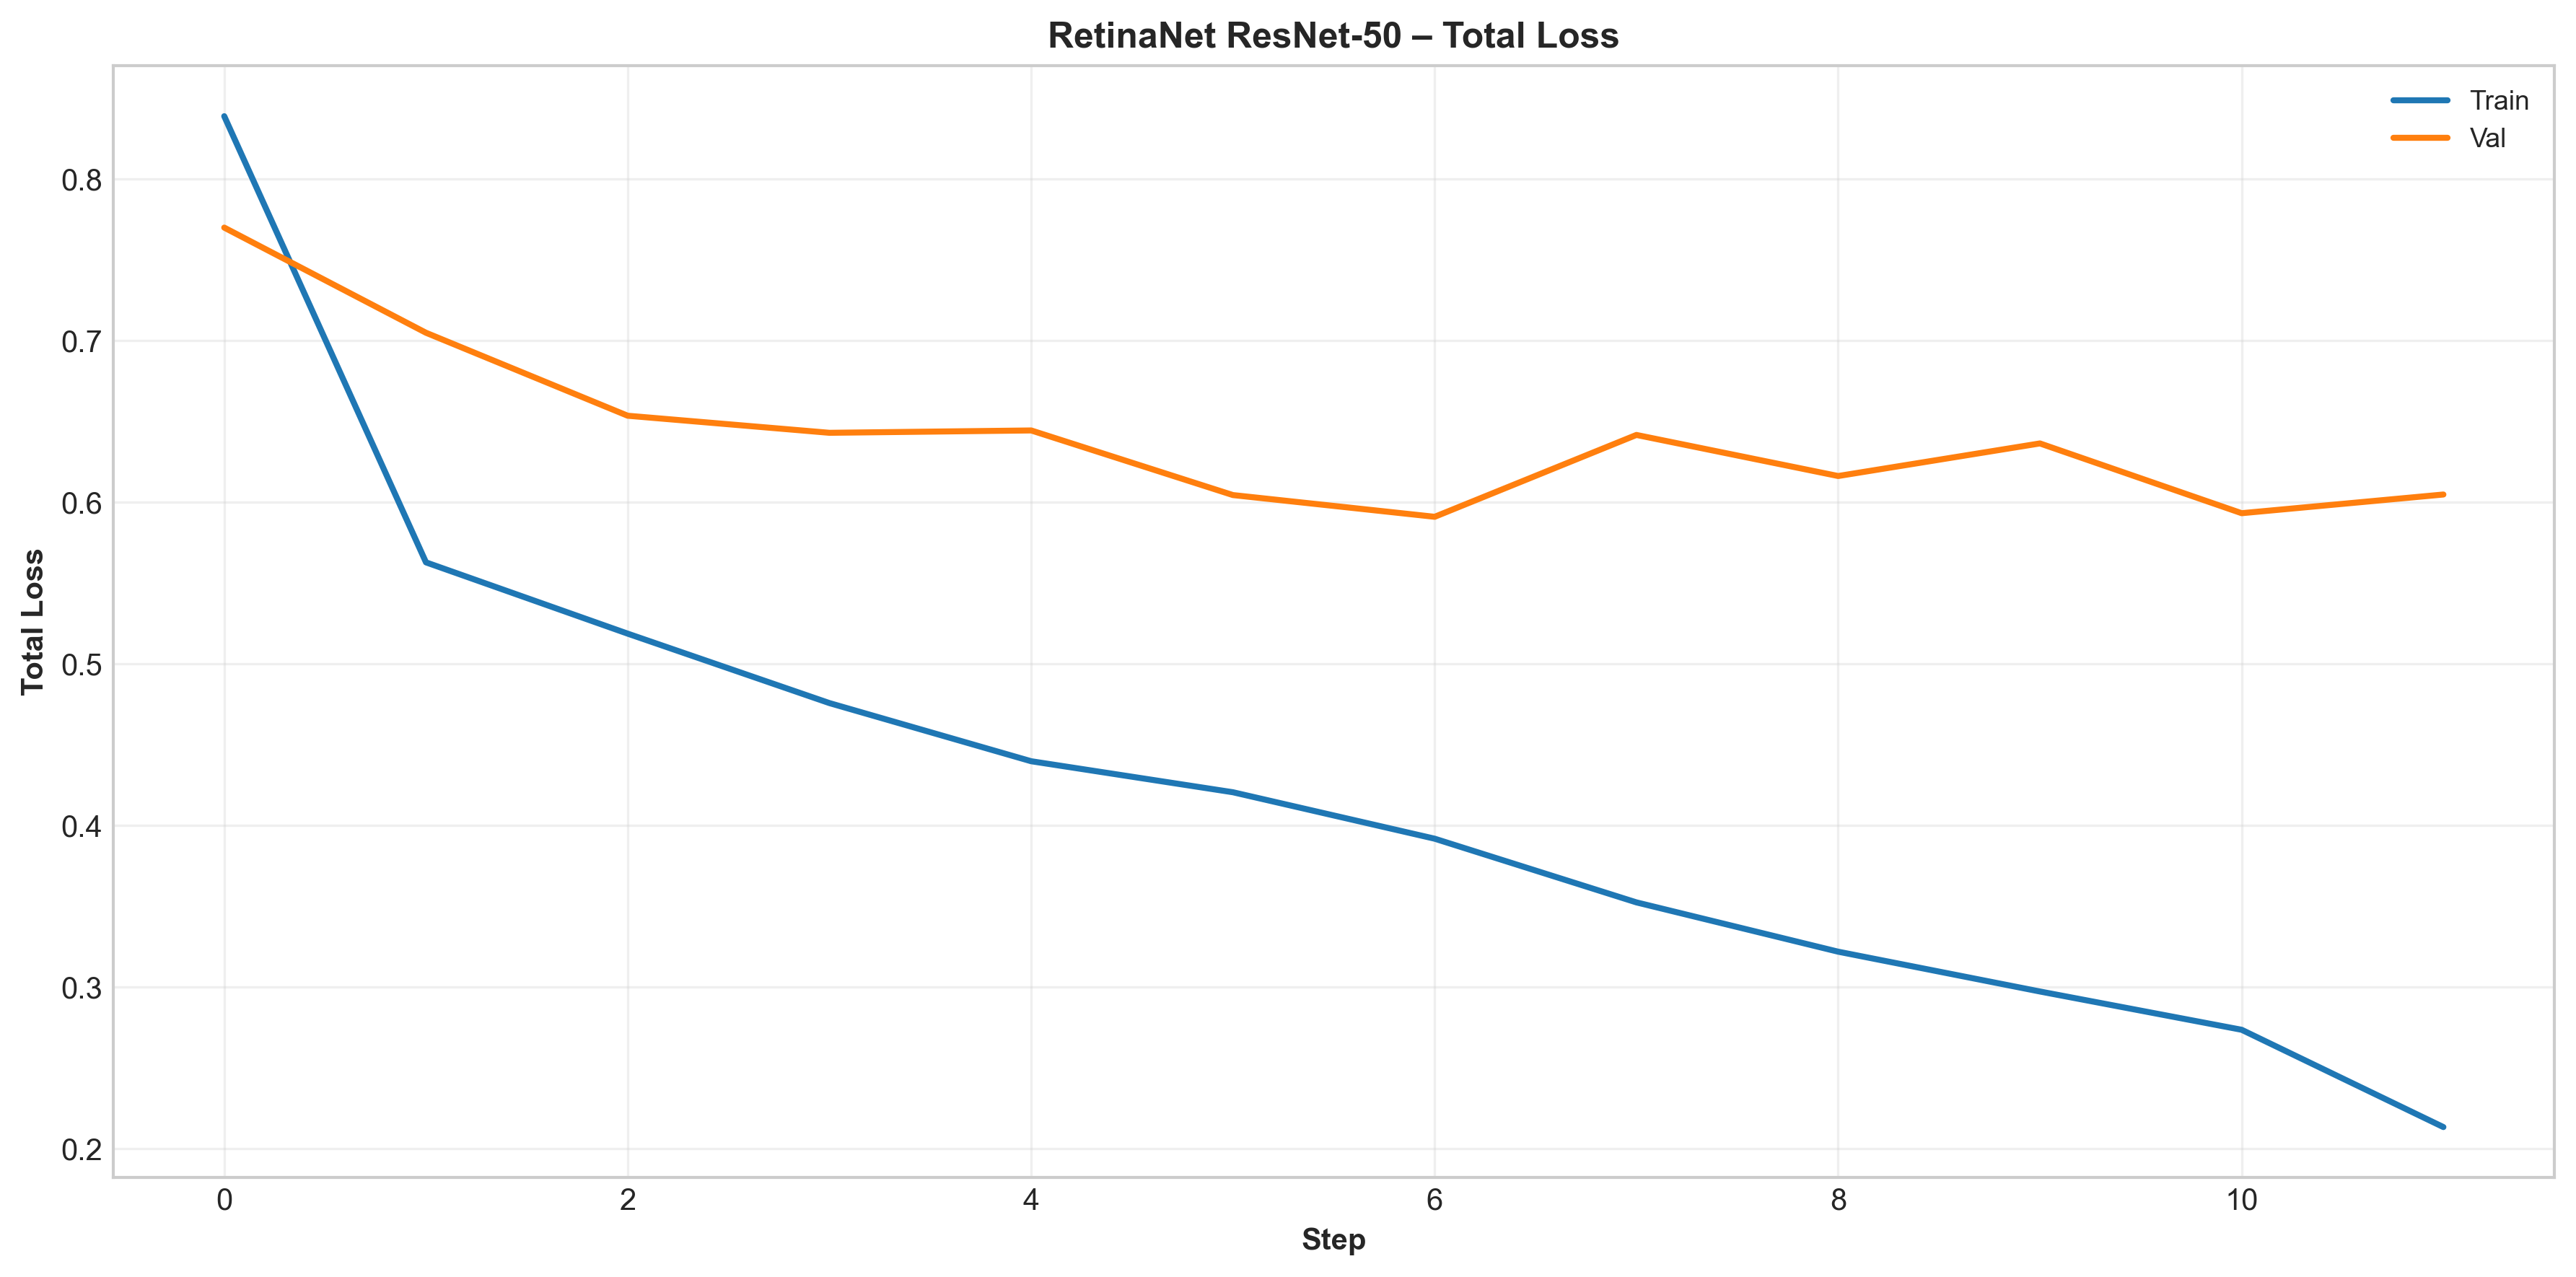

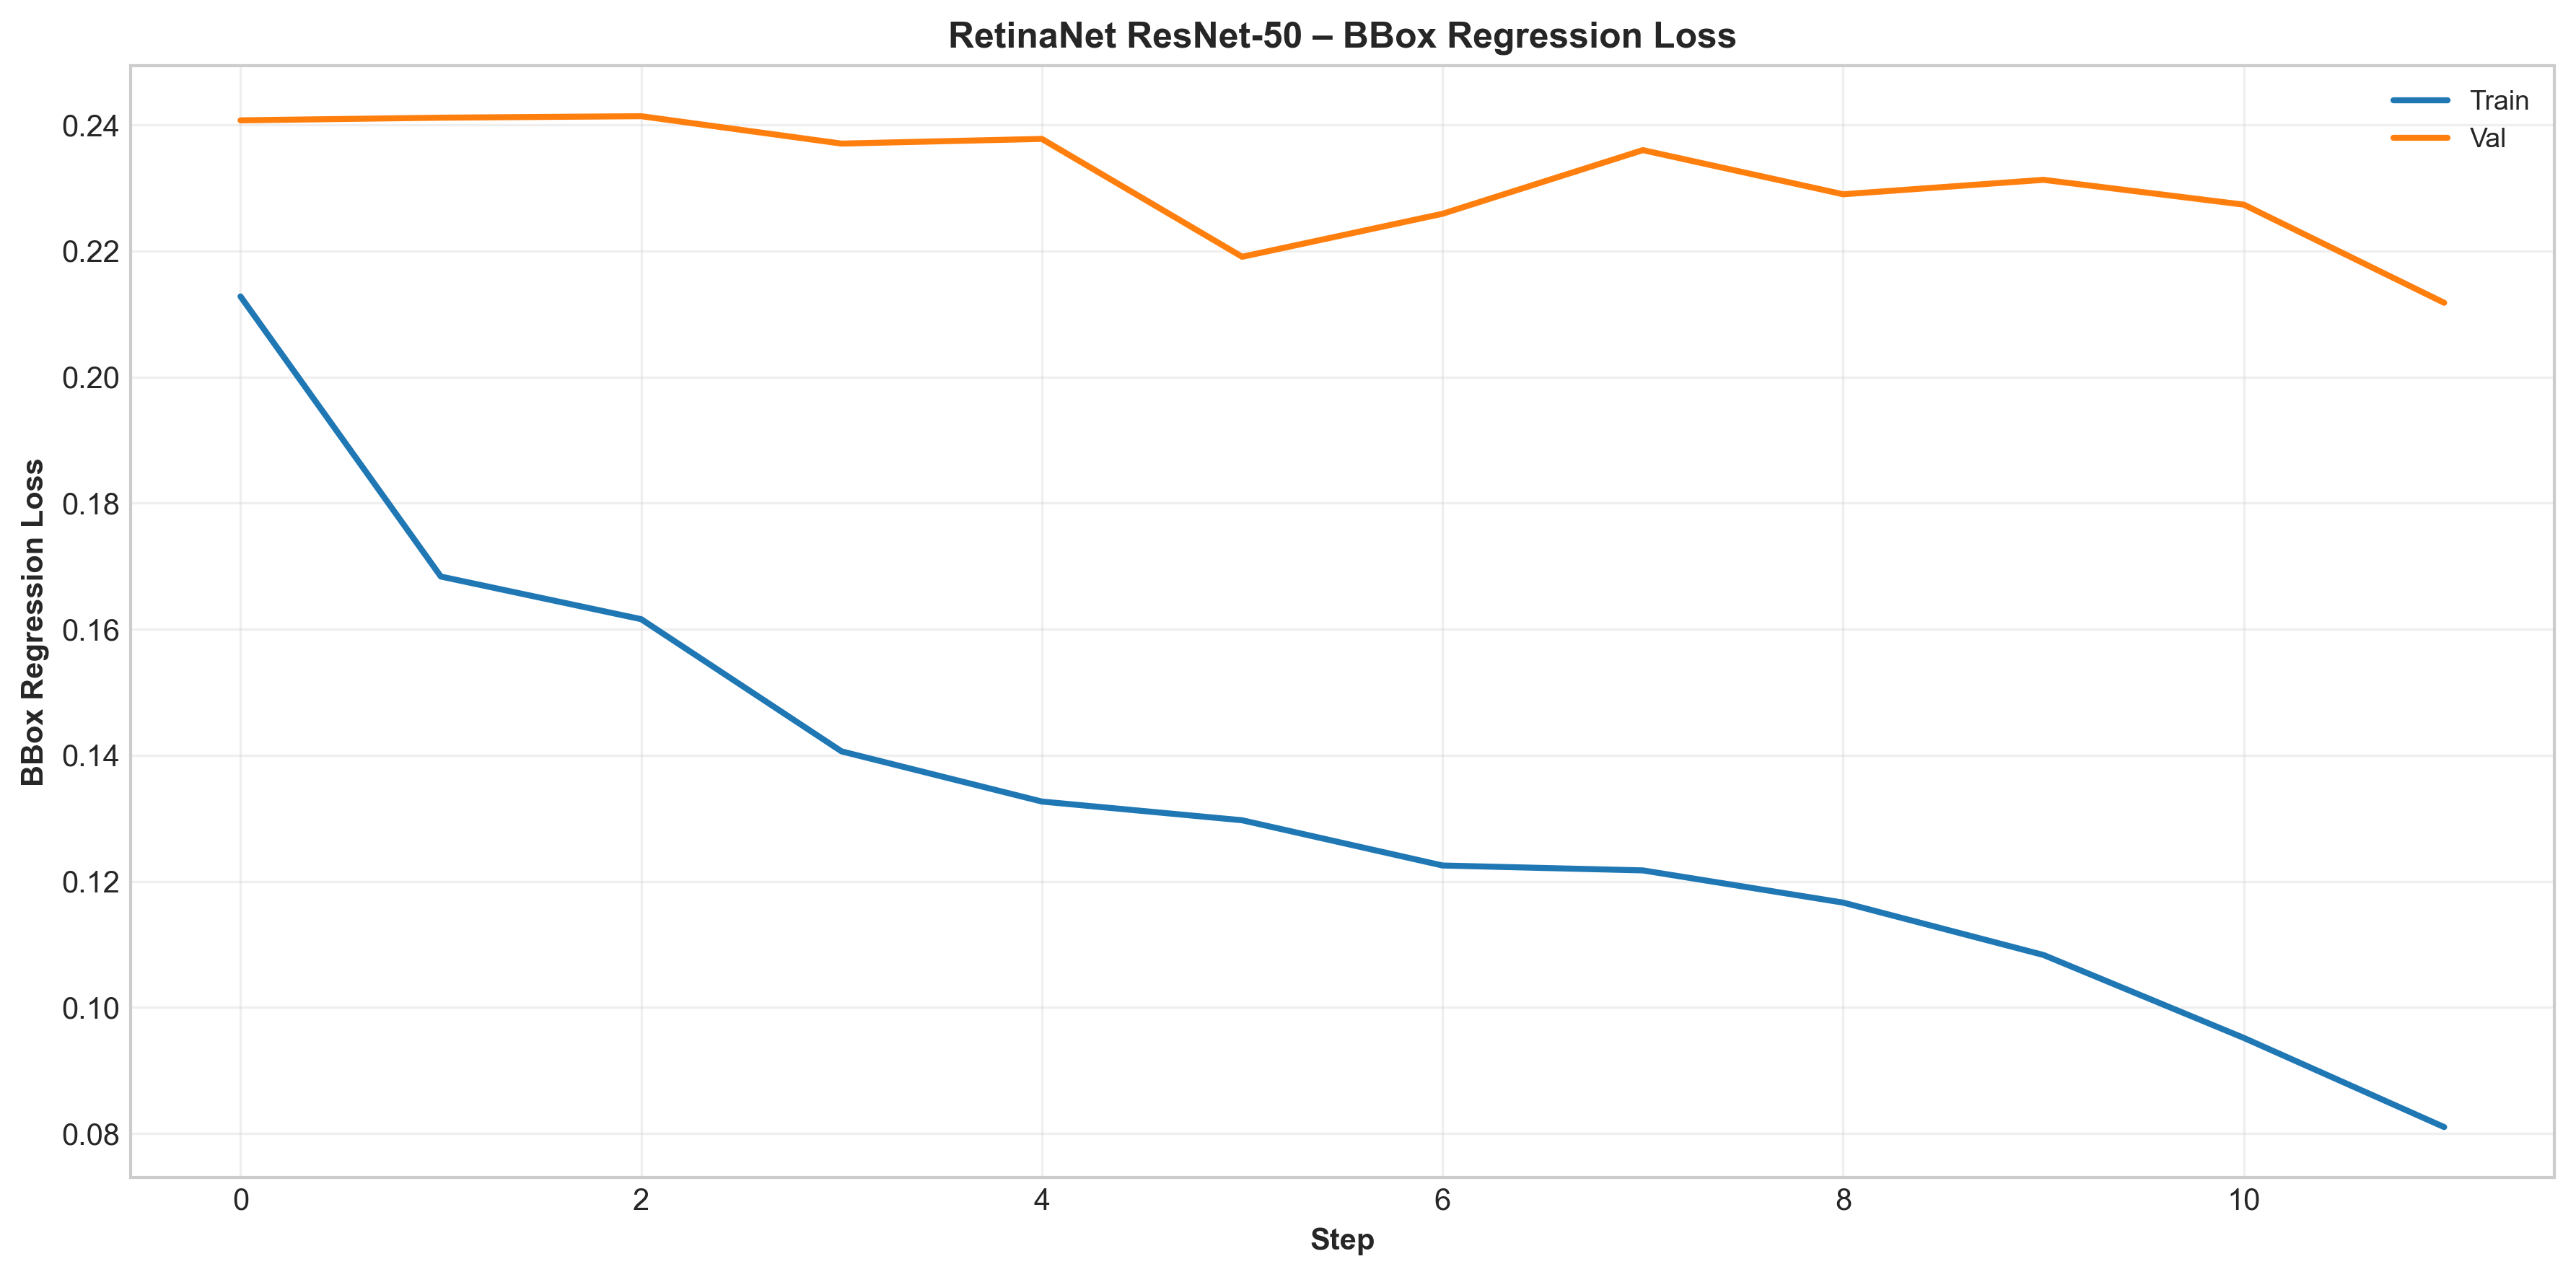

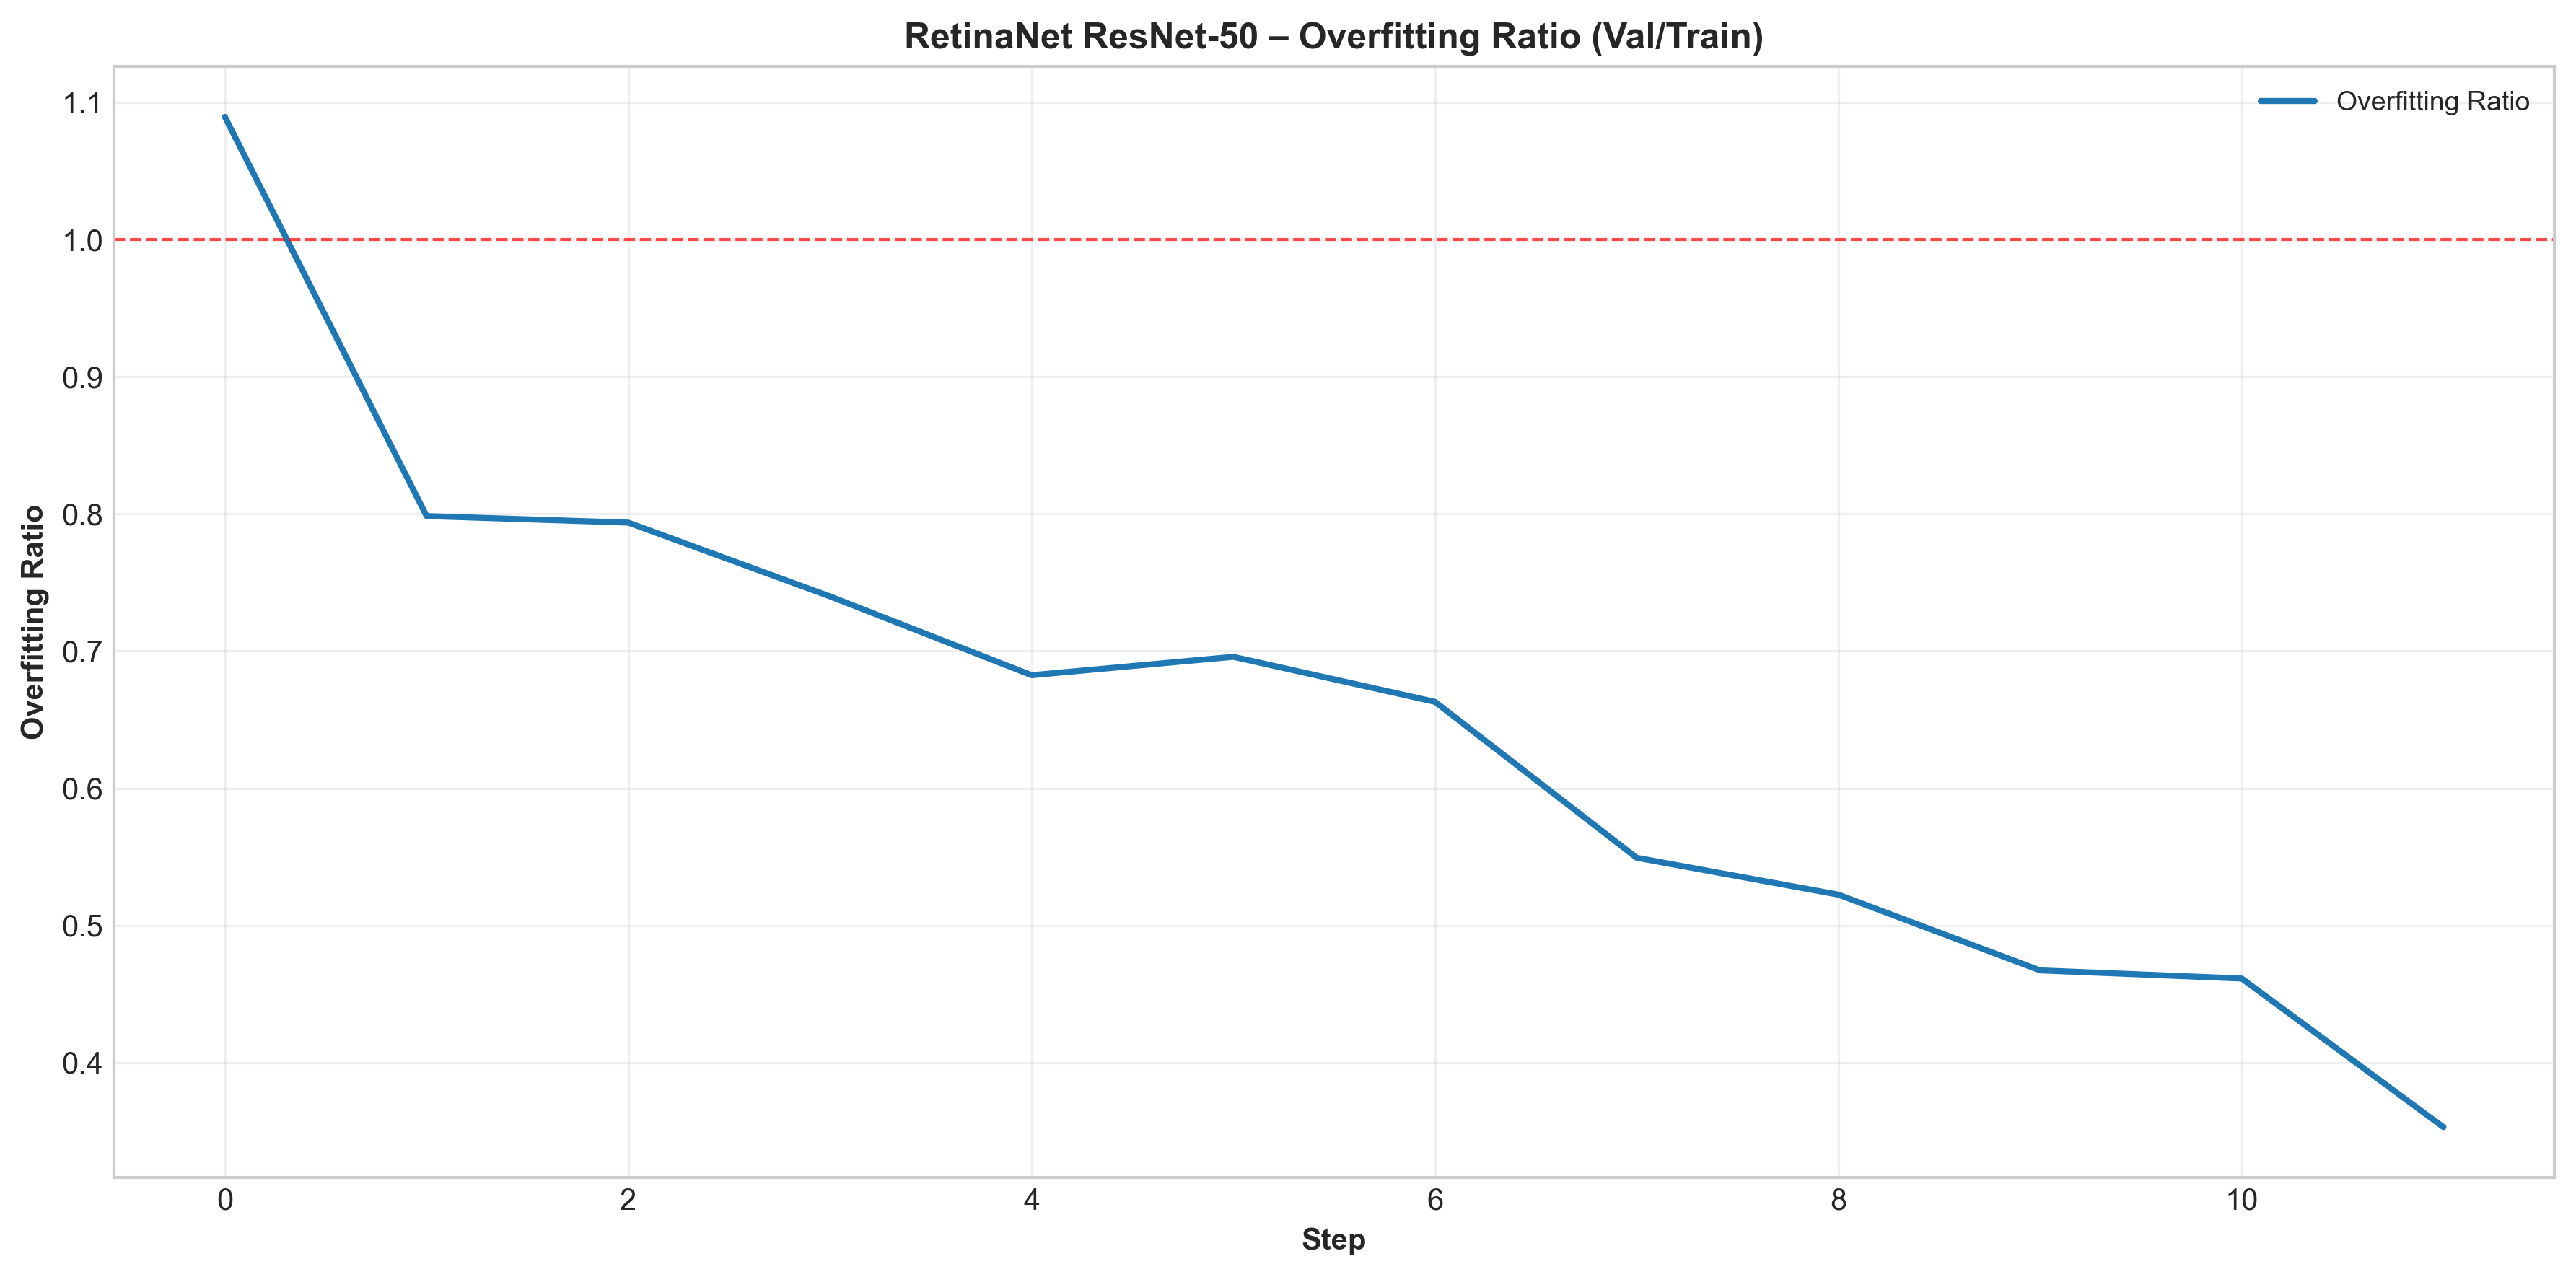

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams["figure.dpi"] = 300
#files
RETINANET_TOTAL_TRAIN = "retinanet_balanced_20260122_231010_Loss_Total_train.csv"
RETINANET_TOTAL_VAL = "retinanet_balanced_20260122_231010_Loss_Total_val.csv"
RETINANET_BBOX_TRAIN = "retinanet_balanced_20260122_231010_Loss_BBox_Regression_train.csv"
RETINANET_BBOX_VAL = "retinanet_balanced_20260122_231010_Loss_BBox_Regression_val.csv"
RETINANET_METRICS = "retinanet_balanced_20260122_231010.csv"


def plot_lines(ax, x, series, title, xlabel, ylabel):
    for label, y in series.items():
        if y is not None:
            ax.plot(x, y, label=label, linewidth=2)
    ax.set_title(title, fontweight="bold")
    ax.set_xlabel(xlabel, fontweight="bold")
    ax.set_ylabel(ylabel, fontweight="bold")
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=9)


retinanet_total_train = pd.read_csv(RETINANET_TOTAL_TRAIN)
retinanet_total_val = pd.read_csv(RETINANET_TOTAL_VAL)
retinanet_bbox_train = pd.read_csv(RETINANET_BBOX_TRAIN)
retinanet_bbox_val = pd.read_csv(RETINANET_BBOX_VAL)
retinanet_metrics = pd.read_csv(RETINANET_METRICS)

fig, ax = plt.subplots(figsize=(12, 6))
plot_lines(
    ax,
    retinanet_total_train["Step"],
    {
        "Train": retinanet_total_train["Value"],
        "Val": retinanet_total_val["Value"],
    },
    "RetinaNet ResNet-50 – Total Loss",
    "Step",
    "Total Loss",
)
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(12, 6))
plot_lines(
    ax,
    retinanet_bbox_train["Step"],
    {
        "Train": retinanet_bbox_train["Value"],
        "Val": retinanet_bbox_val["Value"],
    },
    "RetinaNet ResNet-50 – BBox Regression Loss",
    "Step",
    "BBox Regression Loss",
)
plt.tight_layout()
plt.show()

#less overfitting_ratio = the bigger the overfitting gap
overfitting_ratio = retinanet_total_train["Value"] / retinanet_total_val["Value"]

fig, ax = plt.subplots(figsize=(12, 6))
plot_lines(
    ax,
    retinanet_total_train["Step"],
    {
        "Overfitting Ratio": overfitting_ratio,
    },
    "RetinaNet ResNet-50 – Overfitting Ratio (Val/Train)",
    "Step",
    "Overfitting Ratio",
)
ax.axhline(y=1.0, color='r', linestyle='--', linewidth=1, alpha=0.7)
plt.tight_layout()
plt.show()